In [4]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth
!pip install python-dotenv

In [5]:
from huggingface_hub import login
import os
from dotenv import load_dotenv

load_dotenv("/content/drive/MyDrive/shin_colab/tokens.env")
HUGGINGFACE_API_KEY = os.getenv("HUGGINGFACE_API_KEY")
# Replace 'your_token' with the token you copied from your Hugging Face account
login(token=HUGGINGFACE_API_KEY)

In [ ]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, HfArgumentParser, TrainingArguments, pipeline, logging
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
import os,torch
from datasets import Dataset
from trl import SFTTrainer

In [ ]:
# Load dataset
import pandas as pd

splits = {'train': 'datasets/train.tsv',
          'test': 'datasets/test.tsv'}
#Loading train dataset
train_df = pd.read_csv(splits['train'], sep="\t", index_col=0)

#Loading test dataset
test_df = pd.read_csv(splits['test'], sep="\t", index_col=0)

print("Train Dataset:")
print(train_df.head())

print("Test Dataset:")
print(test_df.head())

Train Dataset:
                        drugName                     condition  \
206461                 Valsartan  Left Ventricular Dysfunction   
95260                 Guanfacine                          ADHD   
92703                     Lybrel                 Birth Control   
138000                Ortho Evra                 Birth Control   
35696   Buprenorphine / naloxone             Opiate Dependence   

                                                   review  rating  \
206461  "It has no side effect, I take it in combinati...     9.0   
95260   "My son is halfway through his fourth week of ...     8.0   
92703   "I used to take another oral contraceptive, wh...     5.0   
138000  "This is my first time using any form of birth...     8.0   
35696   "Suboxone has completely turned my life around...     9.0   

                     date  usefulCount  
206461       May 20, 2012           27  
95260      April 27, 2010          192  
92703   December 14, 2009           17  
138000   

In [ ]:
selected_columns = ['review', 'rating']

train_df = train_df[selected_columns]
test_df = test_df[selected_columns]


# Firstly, define a function to classify sentiment based on rating
def sentiment(rating):
  if rating >= 1 and rating <= 4:
    return 'Negative'
  elif rating >= 5 and rating <=6:
    return 'Neutral'
  elif rating >= 7 and rating <= 10:
    return 'Positive'

# Apply the function to the 'rating' column to create a new 'Sentiment' column
train_df['Sentiment'] = train_df['rating'].apply(sentiment)
test_df['Sentiment'] = test_df['rating'].apply(sentiment)

# Random take 10.000 samples from training dataset
# from sklearn.model_selection import train_test_split

# sampled_train_df, _ = train_test_split(train_df, train_size=10000, stratify=train_df['Sentiment'], random_state=27)
# print(len(sampled_train_df))
# print(sampled_train_df.head(10))

sampled_train_df = (
    train_df
    .groupby('Sentiment', group_keys=False)
    .apply(lambda x: x.sample(n=500, random_state=27))
    .reset_index(drop=True)
)
# Shuffle the dataset
sampled_train_df = sampled_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(len(sampled_train_df))
print(sampled_train_df['Sentiment'].value_counts())
print(sampled_train_df.head())



1500
Sentiment
Positive    500
Negative    500
Neutral     500
Name: count, dtype: int64
                                              review  rating Sentiment
0  "On 7/19/11 I had a routine A1C and my Doctor ...     9.0  Positive
1  "I started at 330lb in 10/2016 I am currently ...    10.0  Positive
2  "These reviews are total shams. The successful...     1.0  Negative
3  "I am 72 years old and have suffered with Chro...     2.0  Negative
4  "My GP prescribed this for anxiety and directe...     1.0  Negative


<ipython-input-6-20753cec0946>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=500, random_state=27))


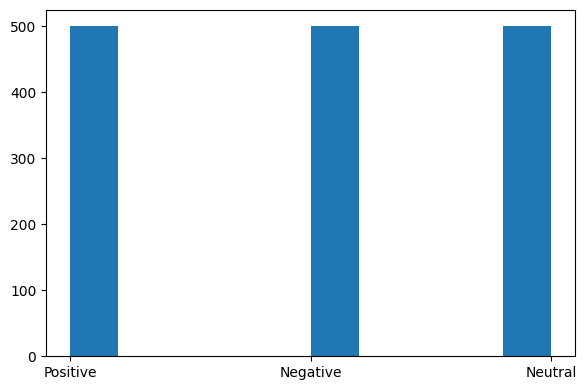

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(sampled_train_df['Sentiment'])


plt.tight_layout()
plt.show()

In [ ]:
def input_prompt(input_text):
  prompt = f"""[INST]
You are an expert in analyzing sentiment from drug reviews. Your task is to classify a given drug review as **Positive, Negative, or Neutral** based on the user's experience.

### **Criteria for Sentiment Classification:**
- **Positive**: The review expresses satisfaction with the drug, mentioning effectiveness, relief from symptoms, or minimal side effects.
- **Negative**: The review expresses dissatisfaction, describing strong side effects, lack of effectiveness, or worsening of the condition.
- **Neutral**: The review is mixed or inconclusive, mentioning both pros and cons without strong emotions, or if the experience is unclear.

### **Only return one of the following labels: Positive, Negative, or Neutral. Do not provide explanations.

### **Examples:**

#### **Example 1:**
**Review:** "This medication completely stopped my migraines within a week. I haven't had a single headache since!"
**Sentiment:** Positive

#### **Example 2:**
**Review:** "I had high hopes, but this drug didn’t help my pain at all. On top of that, I had severe nausea."
**Sentiment:** Negative

#### **Example 3:**
**Review:** "The drug helped somewhat with my anxiety, but I still experience occasional panic attacks. No major side effects so far."
**Sentiment:** Neutral

---

### **Now classify the following review:**
**Review:** "{input_text}"
**Sentiment:**
[/INST]"""
  return prompt

In [ ]:
# test_df = sampled_train_df.iloc[[0]].copy()
# Data preparation
def format_mistral_instruction(row):
    return f"<s>{input_prompt(row['review'])} {row['Sentiment']}</s>"

sampled_train_df['text'] = sampled_train_df.apply(format_mistral_instruction, axis=1)

sampled_train_df.head()

,review,rating,Sentiment,text
0,"""On 7/19/11 I had a routine A1C and my Doctor ...",9.0,Positive,<s>[INST]\nYou are an expert in analyzing sent...
1,"""I started at 330lb in 10/2016 I am currently ...",10.0,Positive,<s>[INST]\nYou are an expert in analyzing sent...
2,"""These reviews are total shams. The successful...",1.0,Negative,<s>[INST]\nYou are an expert in analyzing sent...
3,"""I am 72 years old and have suffered with Chro...",2.0,Negative,<s>[INST]\nYou are an expert in analyzing sent...
4,"""My GP prescribed this for anxiety and directe...",1.0,Negative,<s>[INST]\nYou are an expert in analyzing sent...


In [ ]:

dataset = Dataset.from_pandas(sampled_train_df[["text"]])


In [ ]:
dataset[0]

{'text': '<s>[INST]\nYou are an expert in analyzing sentiment from drug reviews. Your task is to classify a given drug review as **Positive, Negative, or Neutral** based on the user\'s experience.\n\n### **Criteria for Sentiment Classification:**\n- **Positive**: The review expresses satisfaction with the drug, mentioning effectiveness, relief from symptoms, or minimal side effects.\n- **Negative**: The review expresses dissatisfaction, describing strong side effects, lack of effectiveness, or worsening of the condition.\n- **Neutral**: The review is mixed or inconclusive, mentioning both pros and cons without strong emotions, or if the experience is unclear.\n\n### **Only return one of the following labels: Positive, Negative, or Neutral. Do not provide explanations.\n\n### **Examples:**\n\n#### **Example 1:**\n**Review:** "This medication completely stopped my migraines within a week. I haven\'t had a single headache since!"\n**Sentiment:** Positive\n\n#### **Example 2:**\n**Review:*

## Set up the model and tokenizer

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

In [ ]:
# Apply LoRA finetuning to model
model = FastLanguageModel.get_peft_model(
    model,
    # Rank of the LoRA adaptations
    r = 16,
    # Specific layers/modules in the model where LoRA.
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], #
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2025.5.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# Setting up an SFTTrainer from the Hugging Face PEFT (Parameter-Efficient Fine-Tuning)
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    # Training hyperparameters
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = 60,
        num_train_epochs = 2,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "/content/drive/MyDrive/shin_colab/ft_mistral_outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1500 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,500 | Num Epochs = 2 | Total steps = 186
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040/7,000,000,000 (0.60% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.833600
2,1.887500
3,1.670600
4,1.466300
5,1.246100
6,1.089100
7,0.921400
8,0.762700
9,0.696200
10,0.671000


In [ ]:
model.save_pretrained("/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs")
tokenizer.save_pretrained("/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs")

('/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs/tokenizer_config.json',
 '/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs/special_tokens_map.json',
 '/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs/tokenizer.model',
 '/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs/added_tokens.json',
 '/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs/tokenizer.json')

In [ ]:
def inference_model(input_text, model):
  prompt = input_prompt(input_text)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  encodeds = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
  model_inputs = encodeds.to(device)

  generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=False, temperature=0.5)

  decoded = tokenizer.batch_decode(generated_ids,skip_special_tokens=True)
  # print(decoded[0])

  # Get the output only instead of whole prompt
  output_text = decoded[0][len(prompt)-40:].strip().split("\n")[-1]


  return output_text.strip()

In [ ]:
input_text = 'This drug is pretty amazing. I&#039;ve had hyperhydrosis of the palms, soles and underarms since hitting puberty. I was skeptic since I&#039;ve previously tried botox, iontophoresis and drysol with limited results. However, after three days of taking oxybutynin (5mg 3x a day) I was 95% sweat-free. My only negative things to say about the drug is about side effects. I have gotten fairly dizzy/spaced out a few times, and I experience dry mouth pretty often. However, that&#039;s not bad in comparison to the acne I&#039;ve gotten. I used to get pimples around once a month, however now I have ones lasting for &lt;6 wks, varying in size/colour. I constantly have groups of acne on my face. Does anyone have any remedies? I&#039;ve tried acne masks, cleansers and tea tree oil.'
predict_sentiment = inference_model(input_text = input_text, model = model)
print(predict_sentiment)

Positive


In [ ]:
import time
import psutil
from tqdm import tqdm # For progress tracking
# Process each row
save_path = "/content/drive/MyDrive/shin_colab/2_epochs_processed_ft.csv"

test_df['Predict_sentiment'] = None

latencies = []  # Store inference times
start_time = time.time()  # Start tracking total processing time
process = psutil.Process()  # Track memory usage
total_samples = 0  # Track number of processed reviews

for index, row in tqdm(test_df.iloc[:500].iterrows(), total=500):
    if pd.isna(row['Predict_sentiment']):  # Process only if not already done
        input_text = test_df.at[index, "review"]

        # Measure inference latency
        inference_start = time.time()
        test_df.at[index, 'Predict_sentiment'] = inference_model(input_text=input_text, model=model, tokenizer=tokenizer)
        inference_end = time.time()

        # Compute latency and store it
        latency = inference_end - inference_start
        latencies.append(latency)

        GT = test_df.at[index, 'Sentiment']
        print(f"Review number {index}: {input_text} have GT {GT} and predict {test_df.at[index, 'Predict_sentiment']}")
        # Save after processing each row
        test_df.to_csv(save_path, index=False)
        print(f"Row {index} processed and saved.")

         # Increment processed sample count
        total_samples += 1

        # Compute final runtime metrics
total_time = time.time() - start_time
avg_latency = sum(latencies) / len(latencies)
throughput = len(latencies) / total_time  # Reviews per second
memory_usage = process.memory_info().rss / (1024 * 1024)  # Convert bytes to MB

# Print performance results
print("\n=== Runtime Performance Metrics ===")
print(f"Total samples processed: {total_samples}")
print(f"Total Inference Time: {total_time:.2f} sec")
print(f"Average Latency per Review: {avg_latency:.4f} sec")
print(f"Throughput: {throughput:.2f} reviews/sec")
print(f"Memory Usage (RSS): {memory_usage:.2f} MB")

  0%|          | 0/500 [00:00<?, ?it/s]

Review number 163740: "I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me." have GT Positive and predict Positive


  0%|          | 1/500 [00:02<18:27,  2.22s/it]

Row 163740 processed and saved.
Review number 206473: "My son has Crohn&#039;s disease and has done very well on the Asacol.  He has no complaints and shows no side effects.  He has taken as many as nine tablets per day at one time.  I&#039;ve been very happy with the results, reducing his bouts of diarrhea drastically." have GT Positive and predict Positive


  0%|          | 2/500 [00:07<33:07,  3.99s/it]

Row 206473 processed and saved.
Review number 159672: "Quick reduction of symptoms" have GT Positive and predict Positive


  1%|          | 3/500 [00:08<23:34,  2.85s/it]

Row 159672 processed and saved.
Review number 39293: "Contrave combines drugs that were used for alcohol, smoking, and opioid cessation. People lose weight on it because it also helps control over-eating. I have no doubt that most obesity is caused from sugar/carb addiction, which is just as powerful as any drug. I have been taking it for five days, and the good news is, it seems to go to work immediately. I feel hungry before I want food now. I really don&#039;t care to eat; it&#039;s just to fill my stomach. Since I have only been on it a few days, I don&#039;t know if I&#039;ve lost weight (I don&#039;t have a scale), but my clothes do feel a little looser, so maybe a pound or two. I&#039;m hoping that after a few months on this medication, I will develop healthier habits that I can continue without the aid of Contrave." have GT Positive and predict Positive


  1%|          | 4/500 [00:10<19:07,  2.31s/it]

Row 39293 processed and saved.
Review number 97768: "I have been on this birth control for one cycle. After reading some of the reviews on this type and similar birth controls I was a bit apprehensive to start. Im giving this birth control a 9 out of 10 as I have not been on it long enough for a 10. So far I love this birth control! My side effects have been so minimal its like Im not even on birth control! I have experienced mild headaches here and there and some nausea but other than that ive been feeling great! I got my period on cue on the third day of the inactive pills and I had no idea it was coming because I had zero pms! My period was very light and I barely had any cramping! I had unprotected sex the first month and obviously didn&#039;t get pregnant so I&#039;m very pleased! Highly recommend" have GT Positive and predict Positive


  1%|          | 5/500 [00:12<19:13,  2.33s/it]

Row 97768 processed and saved.
Review number 208087: "4 days in on first 2 weeks.  Using on arms and face. Put vaseline on lips, under eyes and in nostrils to protect from cream.  So far no reaction at all.  I know I have many pre cancer and thought I would light up like a Christmas tree but so far so good.  Maybe it&#039;s coming but time will tell." have GT Negative and predict Neutral


  1%|          | 6/500 [00:14<18:15,  2.22s/it]

Row 208087 processed and saved.
Review number 215892: "I&#039;ve had the copper coil for about 3 months now. I was really excited at the thought of not taking hormones. I&#039;m good with pain however I nearly fainted with insertion, couldn&#039;t belive how painful it was; the doctor did say it is very painful for some. Well 3 months in, my periods last 11 days and I&#039;m in pain for about 15 days with random twangs especially in the left side and I&#039;m considering whether I want to put up with the intense pain and heavy periods. I&#039;d recommend this 100% to somebody who doesn&#039;t already have heavy painful periods but right now it just isn&#039;t for me" have GT Neutral and predict Neutral


  1%|▏         | 7/500 [00:17<18:28,  2.25s/it]

Row 215892 processed and saved.
Review number 169852: "This has been great for me. I&#039;ve been on it for 2 weeks and in the last week I only had 3 headaches which went away with 2 Tylenol. I was having chronic daily headaches that wouldn&#039;t go away no matter what I took. I&#039;m still a little sleepy during the day, but I know that will get better. I take 10mg at night." have GT Positive and predict Positive


  2%|▏         | 8/500 [00:18<17:20,  2.11s/it]

Row 169852 processed and saved.
Review number 23295: "Ive been on Methadone for over ten years and currently,I am trying to get off of this drug. Ive been decreasing my does 2 mgs per month for over a year. I am at 3 mgs and really starting to feel the withdraw.I don&#039;t plan to get my next 30 doses.because its almost rediculous how little it does for me. I have 3 does doses of 3 mg and Im terrified. Can anyone give me some truthful encouragement?....." have GT Positive and predict Neutral


  2%|▏         | 9/500 [00:22<19:45,  2.41s/it]

Row 23295 processed and saved.
Review number 71428: "I was on this pill for almost two years. It does work as far as not getting pregnant however my experience at first was it didn&#039;t make a huge difference then 6 or 7 months into it my sex drive went down, along with being very very dry, my moodiness increased drastically. I would cry one second and then get angry with my husband over anything and everything. My skin has gotten a lot worse, I broke out in places I never had in the last week. So now I am on Yaz." have GT Negative and predict Negative


  2%|▏         | 10/500 [00:23<17:15,  2.11s/it]

Row 71428 processed and saved.
Review number 196802: "Holy Hell is exactly how I feel. I had been taking Brisdelle for 1.5 years. The hot flashes did indeed subside - however, the side affects of this medicine coupled with the fact Noven was acquired by YET another pharmaceutical company - YOU CAN&#039;T PLACE A REP IN THE AREA, DISTRIBUTE YOUR DRUGS, AND THEN FIRE HER-AND NOT REPLACE THEREFORE there is NO medicine or support here. You dumped this drug in the Dr&#039;s hands and walked away. After calling Sebula - you act like you don&#039;t even care. You have made it impossible to obtain this. I happen to think this is illegal.  I just decided to wean myself off this and Premarin. It has been nothing short of a nightmare. If you don&#039;t need this drug- DON&#039;T START. Seriously." have GT Negative and predict Negative


  2%|▏         | 11/500 [00:24<15:40,  1.92s/it]

Row 196802 processed and saved.
Review number 31947: "Honestly its day one on the 3 day treatment. Yes it burns a bit and it does leak out if you dont lay down after insertion. But im faithful it will work." have GT Neutral and predict Neutral


  2%|▏         | 12/500 [00:26<15:06,  1.86s/it]

Row 31947 processed and saved.
Review number 4907: "This is a waste of money.  Did not curb my appetite nor did it make me feel full." have GT Negative and predict Negative


  3%|▎         | 13/500 [00:28<15:59,  1.97s/it]

Row 4907 processed and saved.
Review number 66736: "No problems, watch what you eat." have GT Positive and predict Positive


  3%|▎         | 14/500 [00:30<15:42,  1.94s/it]

Row 66736 processed and saved.
Review number 97013: "Ditto on rebound sleepless when discontinued. I have done very strange things with no memory including taking additional Ambien. It has helped me sleep when under extreme stress but watch out. Now I am trying to learn how to sleep naturally." have GT Negative and predict Positive


  3%|▎         | 15/500 [00:32<14:25,  1.79s/it]

Row 97013 processed and saved.
Review number 213376: "A doctor in the ER prescribed me 200 mg of Provigil when I was first diagnosed with Narcolepsy. It didn&#039;t seem to have any effect on me at all. Then I went to see my sleep doctor and he prescribed me 250 mg of Nuvigil. It finally allowed me to stay awake for an entire day. But if I went out somewhere I would be able to come home and take a nap and be fully awake again. Taking that with Xyrem makes me feel 98%..not quite 100, but still pretty great." have GT Positive and predict Positive


  3%|▎         | 16/500 [00:33<13:33,  1.68s/it]

Row 213376 processed and saved.
Review number 151674: "I smoked for 50+ years.  Took it for one week and that was it.  I didn&#039;t think it was possible for me to quit.  It has been 6 years now.  Great product." have GT Positive and predict Positive


  3%|▎         | 17/500 [00:47<43:16,  5.37s/it]

Row 151674 processed and saved.
Review number 33173: "So I was on Ginanvi for about 3 months before I switched over to this pill due to the high cost of Ginavi (I don&#039;t have insurance). Ginanvi had cleared up my acne in the short time I used and I was hoping this birth control would not mess that up. I was wrong. After 2-3 months of using this pill my skin went crazy with horrible breakouts. Now, 9 months later I still have horrible acne. If you want a pill that helps with acne this is NOT it. It also made my period &quot;weird&quot;. I would have little to no period one month and a heavy one the next . The month that I had a heavier flow my boobs would hurt a lot. I also noticed that at the beginning of taking it , I would be moody and extremely irritable all the time . It&#039;s time for me to switch." have GT Negative and predict Negative


  4%|▎         | 18/500 [00:49<33:54,  4.22s/it]

Row 33173 processed and saved.
Review number 30401: "This medication helped me  sleep, but eventually it became ineffective as a sleep aid. It also helps me calm down when in severe stress, anxiety, or panic." have GT Neutral and predict Neutral


  4%|▍         | 19/500 [00:52<31:02,  3.87s/it]

Row 30401 processed and saved.
Review number 152490: "After just 1 dose of this ciprofloxacn, I felt 99% better." have GT Positive and predict Positive


  4%|▍         | 20/500 [00:55<30:06,  3.76s/it]

Row 152490 processed and saved.
Review number 231397: "If I could give it a 0, I would absolutely do so.  Started at 50mg, and felt WIRED.  Wanted to get up and clean the house!  Bumped it to 100mg, less wired, but still wide awake all night.  Bumped to 150, with the same lack of effect.  MD informed me after this dose it becomes less effective for sleep, so why even bother.  15 years of trying different sleep medications and alternatives, and this, I can say for sure, was the LEAST effective I have ever come across.  At it&#039;s low price point, feel free to give it a try, and maybe you will be luckier?  Everyone&#039;s sleep conditions are different.  But if you get hyper after benadryl, expect the same reaction to this drug." have GT Negative and predict Negative


  4%|▍         | 21/500 [00:57<25:56,  3.25s/it]

Row 231397 processed and saved.
Review number 38116: "I am so happy with the samples provided by my Endocrinologist. The only thing I am so sad about is that I cannot afford the prohibitive costs. However, overall this is the best thing I&#039;ve ever had to make my Irritable Bowel Syndrome-D tolerable. I can go out of the house again without worrying and the terrible stomach pains are a thing of the past." have GT Positive and predict Positive


  4%|▍         | 22/500 [00:59<21:32,  2.70s/it]

Row 38116 processed and saved.
Review number 102969: "After a few days and it &quot;kicked in,&quot; every noise in the house would make me jump, pictures on TV would feel as if they were 3-D and make me jump, and I literally felt like my skin was crawling, moving, and melding to things, such as blankets. My mind focused and keyed in on every piece of white noise there was and I had sweaty, night hot flashes with chills." have GT Negative and predict Negative


  5%|▍         | 23/500 [01:00<18:40,  2.35s/it]

Row 102969 processed and saved.
Review number 12626: "They didn&#039;t help my dry eyes at all." have GT Negative and predict Negative


  5%|▍         | 24/500 [01:02<18:28,  2.33s/it]

Row 12626 processed and saved.
Review number 190527: "This drug is pretty amazing. I&#039;ve had hyperhydrosis of the palms, soles and underarms since hitting puberty. I was skeptic since I&#039;ve previously tried botox, iontophoresis and drysol with limited results. However, after three days of taking oxybutynin (5mg 3x a day) I was 95% sweat-free. My only negative things to say about the drug is about side effects. I have gotten fairly dizzy/spaced out a few times, and I experience dry mouth pretty often. However, that&#039;s not bad in comparison to the acne I&#039;ve gotten. I used to get pimples around once a month, however now I have ones lasting for &lt;6 wks, varying in size/colour. I constantly have groups of acne on my face. Does anyone have any remedies? I&#039;ve tried acne masks, cleansers and tea tree oil." have GT Positive and predict Positive


  5%|▌         | 25/500 [01:04<16:30,  2.09s/it]

Row 190527 processed and saved.
Review number 229975: "This medication should not be being prescribed for Bipolar 2, a milder form of a different illness, called Biploar 1, for which this medication works very well. Folks, Doctors NEED to be using SCIENCE to treat illnesses, not giving out random prescriptions for 2+ medications for 1 illness. If your Doctor is not doing monthly blood tests AT LEAST to see how the medications are affecting your body chemistry and serotonin levels, then you need to fire the Doctor and find one who does do his/her job the right way, and who is good at the science part of the job. Every medication you take counteracts and interacts with the other medications and the foods and other things that you put into your body each day messing with the chemistry of your body" have GT Neutral and predict Negative


  5%|▌         | 26/500 [01:05<15:07,  1.91s/it]

Row 229975 processed and saved.
Review number 173391: "klonopin has definitely given me my life back!" have GT Positive and predict Positive


  5%|▌         | 27/500 [01:19<43:10,  5.48s/it]

Row 173391 processed and saved.
Review number 35608: "Worked quickly and well. I learned by trial that trimming/filing away dead pieces of nail once a week when removing is key for it to work." have GT Positive and predict Positive


  6%|▌         | 28/500 [01:35<1:06:42,  8.48s/it]

Row 35608 processed and saved.
Review number 187230: "2.75g x 2 every night for five years. Deeper sleep with dreaming not infrequent. No side effects whatsoever. I&#039;ve not gotten used to the salt added during manufacture." have GT Positive and predict Positive


  6%|▌         | 29/500 [01:49<1:20:25, 10.24s/it]

Row 187230 processed and saved.
Review number 211675: "I am a 25 year old female. I was diagnosed with bipolar II disorder about 5 years ago. I have been taking 150mg of lamotrigine for over 2 years. Thus far I have experienced significant improvements in controlling my bipolar II disorder. I recently paired 100mg of sertraline to improve the lows. Also, I experience rapid cycling. I rated this drug 70% as I feel I still have a long way to go in recovery. But, the drug has definitely allowed me to be a highly functioning individual." have GT Positive and predict Positive


  6%|▌         | 30/500 [01:51<59:39,  7.62s/it]  

Row 211675 processed and saved.
Review number 79865: "I absolutely love this product and recommend to everyone. I know everyone&#039;s body is different, so it is not for everyone, but it is not the medicines fault. I have NO negative symptoms since I started this. I used to have heavy periods, terrible cramps and headaches, and my periods were super long. I now have super consistent 3-4 LIGHT periods, no cramps or headaches. I have been on this pill for over a year now and have no desire to switch." have GT Positive and predict Positive


  6%|▌         | 31/500 [02:05<1:16:28,  9.78s/it]

Row 79865 processed and saved.
Review number 27607: "I&#039;ve had rosacea for almost 20 years and have been on all kinds of antibiotics. Most I am allergic to the last was erythromycin which worked okay. But the Dr though it was time for me to get off the antibiotics. I&#039;ve been on Soolantra for about 6 months and my face has never looked better. I&#039;m thrilled with everything about it. You do use just a dab so a tube will last at least 3 months if not more. I do have insurance that helps a lot with the cost but what I do pay is well worth it." have GT Positive and predict Positive


  6%|▋         | 32/500 [02:07<56:57,  7.30s/it]  

Row 27607 processed and saved.
Review number 207923: "This stuff wasn&#039;t too bad!  I had a hard time with the first dose as I&#039;m not used to very sugary drinks and such.  Because of this, I did think it tasted quite gross.  It had a strange grape salty flavor but it was only 16 oz, so it wasn&#039;t too bad to get down.  I had absolutely no discomfort or nausea.  It worked very fast and I was completely clean for the colonoscopy - this was my first colonoscopy and after having read the awful reviews of the gallon jug prep, I went for this stuff." have GT Positive and predict Positive


  7%|▋         | 33/500 [02:09<43:27,  5.58s/it]

Row 207923 processed and saved.
Review number 156919: "my advice on movantik is understand that movantik is an opioid blocker in the same manner that naloxone (found in suboxone) is an opioid blocker. My husband took 12.5mg and was thrown in withdrawal. Nausea first, chills, fever, shaking so hard the bed was vibrating. I thought movantik worked on the backed up s**t but it stops the opioid from working. Of course you will have diarrhea when your pain meds are cut off. It may not happen to everyone but it happened to my husband. I guess it&#039;s back to OIC" have GT Negative and predict Negative


  7%|▋         | 34/500 [02:10<33:48,  4.35s/it]

Row 156919 processed and saved.
Review number 77164: "Have had back and leg pain and sometimes arm pain." have GT Neutral and predict Neutral


  7%|▋         | 35/500 [02:12<27:17,  3.52s/it]

Row 77164 processed and saved.
Review number 101149: "Have been on Actos for almost a year, gained 24 pounds and have swelling in hands and feet and are retaining a lot of water in my thighs.  My sugar levels are good.  My doctor lowered my dosage from 30 mg to 15 mg but refused to take me off.  Will get a second opinion because the side effects are too much." have GT Negative and predict Negative


  7%|▋         | 36/500 [02:13<23:15,  3.01s/it]

Row 101149 processed and saved.
Review number 178004: "Been on 30mg Cymbalta for 2 weeks. Started getting relief by the 2nd day. Am 58 year old male with spinal stenosis, degenerative disc disease, and spondy. Plan was to go to 60mg but I am getting enough relief at 30mg. I believe I will try to stay on that dose to minimize side effects. Some constipation, difficult reaching orgasm, some night sweats and minor headaches. Oh, insomnia if I took it at night.  I had samples of this medicine for 6 months but delayed starting it because of horror stories on the internet. Pain was ruining my life so this medicine seems to be the best option." have GT Positive and predict Positive


  7%|▋         | 37/500 [02:16<21:14,  2.75s/it]

Row 178004 processed and saved.
Review number 60341: "I was on this for 5 years (and birth control pills for about 12 years), and would have told you how fabulous it was.  &lt;List all the benefits everyone else has listed, here.&gt;  Then a friend of mine convinced me to stop birth control all together for a while, and I turned into a new and better person!  I dropped 5 lbs instantly, had a huge sex drive, more lubrication, and just felt better.  I wouldn&#039;t say I was depressed before, but after going off of it, I would describe my time on birth control as feeling like I was inside a cloud.  Less emotions in general, sometimes a little down.  I&#039;m bummed I&#039;m back on it, but it seems to be the least impactful than the others.  I might try Paragard to avoid the hormones." have GT Positive and predict Positive


  8%|▊         | 38/500 [02:17<18:21,  2.38s/it]

Row 60341 processed and saved.
Review number 141462: "I am a 22 year old female college student. I wanted to write this because when I was at my lowest of low when I felt absolutely hopeless... these positive reviews are what got me through the day. I experienced a lot of change.  I was also in a relationship that made me unhappy. I stopped doing the things I liked to do such as run, party, work, hang out with friends etc. In result, I never had energy. I constantly felt guilty. I cried everyday, sometimes multiple times of day. I went to group therapy. I dropped 10lbs in two weeks. I eventually got on this medicine &amp; the first 4 days felt crazy &amp; tired! TAKE AT NIGHT. Give this medicine time! Now 3 weeks in I am back to myself and am truly happy! Keep your head up." have GT Positive and predict Positive


  8%|▊         | 39/500 [02:20<19:07,  2.49s/it]

Row 141462 processed and saved.
Review number 133539: "I have been administering Egrifta now for 2 1/2 month&#039;s, with absolutely no reduction of abdominal fat. I am a thin person with my abdominal fat causing me to be unable to close my buttons and zippers of my clothing. Then I heard of Egrifta thinking it was the answer. Wrong! No results, just a painful irritated, scar tissue in my abdomen now. " have GT Negative and predict Negative


  8%|▊         | 40/500 [02:21<16:49,  2.20s/it]

Row 133539 processed and saved.
Review number 191095: "Been a heavy drinker for over 6 years since a major operation that left me addicted on morphine. Replaced morphine with beer and wine everyday. From day one of taking Campral, all my cravings went away. I just don&#039;t feel like a drink anymore." have GT Positive and predict Positive


  8%|▊         | 41/500 [02:23<15:18,  2.00s/it]

Row 191095 processed and saved.
Review number 50229: "I started taking gabapentin experimentally to treat chronic depression and am now prescribed 1800mg a day.  At doses of 2700mg I experienced a significant improvement in impulse control and depression in general.  Went from being a shut in, to going for walks and enjoying my time in the company of others.  At the lower dose of 1800mg a day, I don&#039;t experience much improvement, save for a decrease in depressive symptoms.  I&#039;m looking forward to a larger dose if my doctor okays it." have GT Positive and predict Positive


  8%|▊         | 42/500 [02:24<14:04,  1.84s/it]

Row 50229 processed and saved.
Review number 130301: "I want to share my experience to possibly ease some of the ladies out there.
The incident occur in Nov 18 (the condom broke) and it was 4 days after my period ended and approximately 4 days before ovulation. This means I was fertile. 
when we noticed that the condom broke, we immediately bought Plan B One Step and was taken about 45 minutes or an hour later. 
The sooner you take the greater the chances it will work.
So I waited anxiously, praying I get my period. I felt side effects such as fatigue, bloated, nauseous, cramps, and moody. I was that these might be  this pregnancy symptoms. 
I waited exactly two weeks and I got my period. I was the happiest person ever. My period was here early by approximately 3-4 days. Good luck." have GT Positive and predict Positive


  9%|▊         | 43/500 [02:26<13:26,  1.77s/it]

Row 130301 processed and saved.
Review number 101371: "I&#039;m absolutely DONE taking this horrible birth control! I&#039;ve  been taking Aubra for a month and a half... I&#039;m moody, irritable, depressed, hungry, bitchy... vaginal discharge has changed  (gross), my urine smells, my acne has gotten so out of hand and it&#039;s STUBBORN. Cystic acne all around my mouth, jawline, Chin and neck. After doing some research online, I discovered I&#039;m not the only one. Birth control is different for everyone but this is going in the trash... I will not be taking this any longer. It also kills your sex drive... as for the difference in bleeding, I wouldn&#039;t know. I started this pill on day 1 of menstrual cycle last month and haven&#039;t had a period yet... have had plenty of headaches though! " have GT Negative and predict Negative


  9%|▉         | 44/500 [02:28<14:35,  1.92s/it]

Row 101371 processed and saved.
Review number 79569: "Our condom seemed to not have worked properly, but I had to work so I didn&#039;t take the pill until about 18 hours later. I have taken the two pill process about a year ago when the same had happened, and I didn&#039;t become pregnant then nor experience side effects that were noticeable. With this pill, I have been tired, but I am a teacher who works long hours and grades late into the evening so I didn&#039;t attribute it to the pill. I was not nauseated but took it a couple of hours before bed and was my usual tired self. My period came 5 days later with a vengance (strong cramps/heavier bleeding). It is 2 weeks early, which scared me a bit. That is why I wrote this review and sought out others. I also experienced diarrhea due to cramps being so strong." have GT Positive and predict Neutral


  9%|▉         | 45/500 [02:30<14:09,  1.87s/it]

Row 79569 processed and saved.
Review number 17957: "I started on the oral contraceptive pill but got horrible nausea and vomiting, so this was my next option. NuvaRing has been fantastic, it has a fraction of the hormones and I get no nausea. Insertion and removing is really not a hassle, and you cannot feel it at all. For me, it beats the pill and vomiting, along with all the other symptoms. I haven&#039;t had any noticeable mood issues or migraines. I would recommend it to anyone!" have GT Positive and predict Positive


  9%|▉         | 46/500 [02:31<13:11,  1.74s/it]

Row 17957 processed and saved.
Review number 219567: "About two months ago I had to switch from LoLestrin Fe to microgestin due to my insurance and pharmacy. Since starting microgestin I&#039;ve noticed insane bloating and nausea and weird discharge. While on lolestrin, my periods consisted of spotting and average side effects, nothing too serious, but after one month of micro I got my period and it was heavy and the cramping was so painful I had to leave my class. I&#039;ve also noticed I&#039;ve developed bad depression and my mood swings are very intense. My anxiety is bad and my sex drive is very low if not nonexistent anymore. It helped with my acne but I&#039;m a lot more paranoid about getting pregnant than I was on lolestrin. I&#039;m going to be talking to my doctor about possibly getting the shot." have GT Negative and predict Negative


  9%|▉         | 47/500 [02:33<12:42,  1.68s/it]

Row 219567 processed and saved.
Review number 171525: "Coming from a very problematic childhood, I&#039;ve been labeled everything from A to Z by psychiatrists and given a slew of meds. Wellbutrin in my experience has been beyond beneficial. At first for the first week or two I had slight tremors, irregular heartbeat, major insomnia and headaches but dismissed. I still have slight insomnia which is why I take them when I wake up. But reading comprehension, multitasking, thought focus and moods overall have dramatically improved! I&#039;m one of those people that may have to take them for the rest of my life but I&#039;m not complaining =). One thing that does bother me tho is dry mouth from wellbutrin but I take biotene which helps a bit. Enough to make it worth it anyways lol." have GT Positive and predict Positive


 10%|▉         | 48/500 [02:34<12:19,  1.64s/it]

Row 171525 processed and saved.
Review number 173027: "Works for me" have GT Neutral and predict Positive


 10%|▉         | 49/500 [02:36<12:00,  1.60s/it]

Row 173027 processed and saved.
Review number 202002: "My GP had prescribed this to me at my requests for something to deal with my acne. I used this medication for about a month or a little longer. This medication dries out my face something terrible. I had to slather moisturizer on my face, which was probably counterintuitive. The medication worked well at drying out existing acne on my face but did nothing to prevent new acne. Every day I would wake up to new zits. I ended up going to a dermatologist and had something else prescribed. 

Also, with this medication containing benzoyl peroxide it stains your sheets very badly (thankfully, I already had a pillow case that resisted staining, same can&#039;t be said for the sheets)." have GT Negative and predict Neutral


 10%|█         | 50/500 [02:38<12:00,  1.60s/it]

Row 202002 processed and saved.
Review number 143003: "I&#039;ve had this birth control for a year now and at first things were going good, I only had a period once and never had one since but now I have super bad anxiety, I would constantly think I was pregnant, would waste my money on pregnancy test even though I am NOT pregnant and my depression was very bad and honestly , I really don&#039;t think it&#039;s worth it at all. I&#039;m getting it removed tomorrow and I most likely am going to have to be in therapy." have GT Negative and predict Negative


 10%|█         | 51/500 [02:39<11:52,  1.59s/it]

Row 143003 processed and saved.
Review number 31908: "OM Freakin G!!!! I&#039;ve had YIs before but this takes the cake. I&#039;ve used Monistat a few times and I never experienced such burning as I&#039;m experiencing now. It&#039;s starting to cool off but damn. This is only day 1 and I hope it&#039;s only the first day. I&#039;d like to think it&#039;s because the medication is reacting to the irritation from instance itching I was doing down there before buying the cream. Lol. Because unless Monistat change their ingredients, I can&#039;t think of any other logical reason for this severe burning like never before." have GT Negative and predict Negative


 10%|█         | 52/500 [02:41<13:08,  1.76s/it]

Row 31908 processed and saved.
Review number 3350: "One more day! I hope the infection don&#039;t come back, because This antibiotic make me feel so sick,  now I&#039;m noticing  vaginal  discharge, I don&#039;t like it at all but Is a side effect, One more day!" have GT Positive and predict Neutral


 11%|█         | 53/500 [02:43<12:58,  1.74s/it]

Row 3350 processed and saved.
Review number 226299: "So I first got the nexplanon in July of 2014, for the first 5 months I was fine, I didn&#039;t get my period and if I did it was random spotting (very light) but around January I noticed I was very emotional EVERYTHING made me cry. Then my period started coming twice a month with horrific cramps. Or I would spot for 2-3 weeks have a week where I thought It was over and started spotting again. I&#039;ve now had it for 13 months and it does the job because I havent gotten pregnant. But that&#039;s only because I haven&#039;t been able to have sex cause I don&#039;t know when my period is going to come" have GT Neutral and predict Negative


 11%|█         | 54/500 [02:45<12:32,  1.69s/it]

Row 226299 processed and saved.
Review number 190325: "I started off by taking regular Ortho Tri Cyclen, which helped some with my acne, but I also became severely depressed, so I went off it.  After a year and a half of not taking birth control at all, I began taking Ortho Tri Cyclen Lo for acne, and after 4 months my skin is MUCH clearer.  If I do get pimples, they are much smaller and more shallow than before, and go away quicker.  I am pleased!" have GT Positive and predict Positive


 11%|█         | 55/500 [02:46<12:00,  1.62s/it]

Row 190325 processed and saved.
Review number 146651: "I have been taking Flomax for a month for Benign Prostatic Hyperplasia. I had been getting up to urinate 2 or 3 times a night, suffering from severe pain during urination. Since starting Flomax I have found  myself dizzy if getting up quickly, blurred vision, decreased sex drive with abnormal ejaculate. I have lower back pain. I feel weaker and tired all the time. On the up side I can go all night with no need to get up to urinate and the pain while urinating is 50 percent less." have GT Neutral and predict Neutral


 11%|█         | 56/500 [02:48<11:46,  1.59s/it]

Row 146651 processed and saved.
Review number 25240: "I experienced an improvement in pain, swelling and stiffness within the first two weeks. I was able to titrate off of prednisone and hydrocodone. However, I am experiencing stomach upset and rapid hair loss, which is very disconcerting." have GT Positive and predict Neutral


 11%|█▏        | 57/500 [02:51<16:29,  2.23s/it]

Row 25240 processed and saved.
Review number 5357: "I started taking Cryselle almost 9 months ago to treat my endometriosis as well as to act as a birth control. My OB-GYN instructed me to skip the placebos, and as a result I have had virtually no cramping or break through bleeding (common on my last pill). However, as she warned, I developed severe acne. The acne I could deal with, but the emotional side effects I cannot. I have become increasingly moody the longer I have been on Cryselle, especially around the time of my &quot;period&quot;. I have also developed strong feelings of anxiety and depression. I had hoped when these symptoms began, that they would lessen over time, but they have just increased in severity. " have GT Positive and predict Negative


 12%|█▏        | 58/500 [02:53<15:28,  2.10s/it]

Row 5357 processed and saved.
Review number 13407: "Yes, this medication does work wonders, at first.  Diagnosed ADHD (by a Psychiatrist)  at the age of 26.  The first 3 years it worked quite well and felt like a godsend.  I took 5-6 days a week and my life demonstratively improved.  Focus, completing tasks, mental clarity, improved self-esteem...life was good.

Adderall, like other CNS stimulants, tend to become less effective after time and I noticed this more pronouncedly by my 5th year.  At that point, I felt trapped by the drug and tried to stop.  The problem was that even after a month or more without Adderall, none of discontinuation symptoms were improving.  While I continue to use Adderall for maintenance, I derive little benefit.  Be aware, the effects won&#039;t last indefinitely!" have GT Negative and predict Positive


 12%|█▏        | 59/500 [02:55<16:00,  2.18s/it]

Row 13407 processed and saved.
Review number 46742: "I have had problems with acne off and on as a teenager, but after I had our  children it got worse.  I mean a LOT worse!  It got so bad that I  have not been in any family pictures or even gone in public for the last 4 years! I am 39 years old and finally got so  sick of wasting money and time on everything you can imagine,  even tried every old wives tales. Finally my Dr put me on this, benzol peroxide 5% and Retinal- A. 

Yes  weeks 1-3 made it 30%worse but week 4 and beyond my skin looks amazing!  I now love going into public and my confidence is through the roof, I would definitely recommend for everyone!" have GT Positive and predict Positive


 12%|█▏        | 60/500 [02:57<14:32,  1.98s/it]

Row 46742 processed and saved.
Review number 11464: "I am a 12 year survivor of mirapex/Pramepexole. It was a miracle to begin with. I only slept about 4hrs a night but had enormous energy and never tired. That lasted nine years. But during that time I lost bladder control, impulse disorders, loss of concentration, myalgia neuropathy, falling asleep while driving, many more and augmentation. I was on .5 mg. Detoxing med free from this med was horrendous! After detox most of the side effects cleared up. But I still have issues with memory and concentration. This is the only med I took on a reg bases as my health was good. Im still suffering the side effects of the Withdrawl from it. Studies should be for longer than 12 weeks." have GT Negative and predict Neutral


 12%|█▏        | 61/500 [02:59<13:40,  1.87s/it]

Row 11464 processed and saved.
Review number 124544: "honestly the measurement hurt more than the actual placement! And I&#039;m so happy I went through with it!!! I wish I didn&#039;t read all of these reviews before I did it. Pain is subjective and its not that bad. They explained the procedure to me and I felt more comfortable. I&#039;ve never had kids. Its just like getting a regular pap. I think it is the best option of birth control. That being said I will definitely recommend getting this! Do expect cramping for a day or two. I didnt cramp until about three hours after having it done. I took ibuprophen and slept with a heating bad. Very mild cramping today but I am happy with my choice :)" have GT Positive and predict Positive


 12%|█▏        | 62/500 [03:00<12:48,  1.75s/it]

Row 124544 processed and saved.
Review number 229996: "I used them and within 6 hours my eyes swelled almost shut, and cheeks puffed up. 2 weeks later I still have red watery eyes, but thankfully the swelling is finally gone. I will never use this product again (obviously), but it is also incredibly expensive. I have never had an allergic reaction to any medication before so this was very unexpected." have GT Negative and predict Negative


 13%|█▎        | 63/500 [03:02<12:10,  1.67s/it]

Row 229996 processed and saved.
Review number 131523: "I was prescribed this for onset of anxiety and possible hormonal mood swings. I was not told by my doctor how it would make me feel or how hard coming off of it would be. I took one 37.5 mg capsule and was horrified that I was given this. I woke up at 2am with an anxiety attack for about the first hour. It then went into being wired, nauseous, shakey, weak, chills and sweating. 11 years ago I quit using meth and this was awful that I felt like I was on it again. I laid in bed the entire day, wide awake and ill. I never took another dose! And even one pill took at least another full day to leave my system. My nervous system is obviously sensitive and I could not handle this medication at all." have GT Negative and predict Negative


 13%|█▎        | 64/500 [03:03<11:51,  1.63s/it]

Row 131523 processed and saved.
Review number 209386: "I started the nifedipine/Procardia this morning. About 4 hours later the rare side effects kicked in. Heart palpitations, dizziness, headache, and I was FREEZING. Even at 43 I still call my mommy. She wasn&#039;t thrilled I was going to take it anyway since I have perfect blood pressure. But she recommended laying on my left side. That did help even if it did take awhile for me to get warm again. The headache is still lingering." have GT Negative and predict Neutral


 13%|█▎        | 65/500 [03:05<11:35,  1.60s/it]

Row 209386 processed and saved.
Review number 229572: "I am on day #10 of this medication and the side effects are very minimal although I am having trouble sleeping. My sleep patterns have been affected. I feel more energetic, as If I have to be doing something. My mind will not stop repeating the same thoughts, over and over again. I am also very hungry and have an increased appetite. It does however, cause me to think about things differently as I know what my general reaction to things would be, or have been in the past, but, it allows me time to think of an alternative besides being explosive. It has calmed me, and more than once, has helped me to cope with a situation differently and more calmly. Overall, I think I&#039;m doing well so far. I plan to continue this medication for some time." have GT Positive and predict Positive


 13%|█▎        | 66/500 [03:07<12:28,  1.72s/it]

Row 229572 processed and saved.
Review number 105440: "Since I was on the trials I put 6+ months but I have been back on Afrezza for about 2 weeks.  Afrezza is nothing short of a miracle. I am a type 1 diabetic and my blood sugar average in the past 10 days has been 110. I have a CGM so I have had 2880 readings in the past 10 days.  A 110 average equals to an A1C of 5.45. This is possible because Afrezza mimics the speed of a healthy pancreas. Afrezza starts working in only 12-15 minutes and works out of my system very quickly. This allows me to manage my glucose in real time without babysitting diabetes all day. Even if I do have a high I can knock my sugars back to 100 in a matter of minutes." have GT Positive and predict Positive


 13%|█▎        | 67/500 [03:09<13:28,  1.87s/it]

Row 105440 processed and saved.
Review number 201582: "Zoloft did not help me at all.  I was on it for about 3 months, worked up to 100mg.  I was tired and hungry all the time.  I gained 20 lbs and slept all day. I was a complete zombie.  Definitely made my depression worse." have GT Negative and predict Negative


 14%|█▎        | 68/500 [03:23<39:16,  5.46s/it]

Row 201582 processed and saved.
Review number 158346: "Geodon is a very effective drug for me.  Completely wiped out the auditory hallucinations." have GT Positive and predict Positive


 14%|█▍        | 69/500 [03:24<30:45,  4.28s/it]

Row 158346 processed and saved.
Review number 159659: "I was prescribed Bactrim for a kidney infection. I took two doses, 500 mgs each. After the first dose, I began to feel lousy. I assumed it was a side effect. The second dose almost killed me. I went to the ER, where I was stabilized enough to move me to ICU. Before I lost consciousness, my blood pressure was 35/27. I woke up 3 days later with a central line, severely swollen body, and my skin was bright red, like a severe sunburn. I spent 3 weeks in the hospital, with my blood pressure constantly plummeting. I apparently have a severe allergy." have GT Negative and predict Negative


 14%|█▍        | 70/500 [03:26<24:42,  3.45s/it]

Row 159659 processed and saved.
Review number 15423: "I was started on Gildess 1/20 but then was switched to Blisovi as Gildess was recalled. I always had the clearest skin and now that I&#039;ve been taking Blisovi I&#039;ll have random break outs and I&#039;ve gained some weight as well. I do not recommend. I can&#039;t wait to talk to my gynecologist to switch ASAP." have GT Negative and predict Negative


 14%|█▍        | 71/500 [03:27<20:24,  2.85s/it]

Row 15423 processed and saved.
Review number 95748: "I had major depression from the time I started menstruating.  It would cycle with my cycle.  It caused paranoia, and fear of being seen outside my home.  It feared going to my mail box, yet, at times I would sign up to do things like be an Avon Lady! I felt crazy. In my mid 30&#039;s, divorced, alcoholic, my doctor prescribed Prozac.  It didn&#039;t seem to help me.  Later in recovery but still profoundly depressed, she put me on Zoloft and the result was instantaneous.  I felt like a window to my life had been opened.  I wasn&#039;t afraid.  I looked forward to getting out of bed.  I found things I liked to do. I have a healthy relationship, a good job, a life.  I have been given my life back.  Now, I am 16 years sober.  Thank you Zoloft." have GT Positive and predict Positive


 14%|█▍        | 72/500 [03:29<17:33,  2.46s/it]

Row 95748 processed and saved.
Review number 6971: "So in high school over ten years ago I started to sweat really bad under my arms. It was super embarrassing to go through high school with this issue. After trying over the counter products and home remedies I gave up. So my Dr at the time recommended Drysol. I used it for just a few weeks and it worked so good. But then after a few months I noticed my armpits darkening. So I stopped using it. Now about 15 yrs later I&#039;ve tried so many things to lighten my armpits and nothing works. This stuff did 100% cure my sweaty armpits and I can now freely wear shirts without the sweat marks. But it burned me so bad that I have dark scars for life and still can&#039;t walk around freely with tank tops. I guess you can&#039;t win them all." have GT Positive and predict Neutral


 15%|█▍        | 73/500 [03:30<15:53,  2.23s/it]

Row 6971 processed and saved.
Review number 131683: "Sadly only lasted 5 days on Effexor XR. The side effects from the 75mg dose was unlike anything I have experienced before. Within 10 hours of the first dose I had severe anxiety - something I had never experienced before. Within hours of second dose the extreme nausea came on. By day 3 I was pratically bed-ridden in cold sweats and feeling completely &quot;out of it&quot; . I persevered hoping the effects would begin to subside but by the 5th day I had severe nausea, couldn&#039;t get out of bed from feeling so sick, horrible tinnitus (ringing in the ears) and felt spaced out to the point that I began to wonder if I would ever feel &quot;normal&quot; again. Advised by GP to cease immediately on hearing my side effects." have GT Negative and predict Negative


 15%|█▍        | 74/500 [03:32<14:22,  2.02s/it]

Row 131683 processed and saved.
Review number 188604: "I had paragard for a year and a half and had cramping the whole time with terrible long heavy periods.  The last couple months I had it I was in so much pain I could hardly walk. Went to my doc and she said nothing seemed wrong.  Then the next day I went to the ER and had it removed. It had slipped a little and was causing a lot of discomfort. I will never get an IUD again. I&#039;m lucky I didn&#039;t need surgery like some women" have GT Negative and predict Negative


 15%|█▌        | 75/500 [03:34<14:35,  2.06s/it]

Row 188604 processed and saved.
Review number 19559: "Pregabalin for me was miraculous. On the first dose (75mg three times a day) my anxiety was reversed. I really thought this was too good to be true. I have tried Prozac and lorazepam at different times of my life. But as is commonly known, after the fourth or fifth trial of SSRIs, they &quot;peter out&quot; and actually become counter productive, even in some cases causing serotonin syndrome. But about two years ago, I was in a very stressful marriage break-up and was taking benzodiazepines to keep the lid on the anxiety, with little effect. The GP respected my wish to try Lyrica. I was and still am, after two years, astounded by this transformation. I feel like I always felt I should feel. A cessation of anxiety and a sense of well being pervades. " have GT Positive and predict Positive


 15%|█▌        | 76/500 [03:36<13:57,  1.97s/it]

Row 19559 processed and saved.
Review number 104580: "I just started taking this birth control about 12 days ago when I started my period, and I&#039;m still bleeding as if I&#039;m still on my period. The flow is light however the length of my average period is 2 weeks when I wasn&#039;t on birth control. So maybe the medication is altering my system %u2026I do feel nauseous and I crave like crazy. I do feel a little depressed because my period isn&#039;t gone yet but overall it 
seems to be a good birth control so far. " have GT Positive and predict Neutral


 15%|█▌        | 77/500 [03:37<13:02,  1.85s/it]

Row 104580 processed and saved.
Review number 26989: "I have severe scar tissue and adhesions from mutiple surgeries and the pain was intense it is in my pelvic area. I fill like I&#039;m having a bad cycle every day and walking intensifies the pain this is a every day feeling. My doctor tried me on Ultram and it has been a God send. I take it three times a day. Without it it would be hard to walk so I give it a 10 thank you." have GT Positive and predict Positive


 16%|█▌        | 78/500 [03:39<12:10,  1.73s/it]

Row 26989 processed and saved.
Review number 128575: "Started out yesterday at 242 and this morning I was only 239.6 not hungry at all" have GT Positive and predict Positive


 16%|█▌        | 79/500 [03:41<11:56,  1.70s/it]

Row 128575 processed and saved.
Review number 122089: "I was first prescribed Effexor 13 years ago and was taking 225 mg. I was on it for a few years and stopped taking when I was pregnant with my first child. I was put on Paxil (gained so much weight) and then Zoloft. I took the Zoloft off and on for years until it just wasn&#039;t working for me anymore. I was then put on Welbutrin while still taking 25mg of Zoloft. I quit smoking (had no desire to smoke) but then became suicidal. My doctor then put me back on Effexor and I currently only take 75 mg. I feel amazing. Yeah the side effects are bad, I&#039;ve gained weight (lost weight the first time I was on it), have sexual side effects, and get quite shaky/jittery if I&#039;m late on a dose. But I&#039;m finally the mom I&#039;ve always wanted to be." have GT Positive and predict Positive


 16%|█▌        | 80/500 [03:42<11:34,  1.65s/it]

Row 122089 processed and saved.
Review number 191146: "Drank for thirty years, lost everything, struggled with benders for past 2 years after rehab, no hope. 3 months post Campral. 333mg per day. The only time I think about taking a drink is when I am thinking that I am not thinking of taking a drink. Truly feel it has had an anti-depressant effect for me. Sleep great and the only side effect is an occassional dizziness. Tell everyone you know struggling." have GT Positive and predict Positive


 16%|█▌        | 81/500 [03:44<11:08,  1.60s/it]

Row 191146 processed and saved.
Review number 120889: "I took Effexor for the first and last time yesterday around 7:41 am . At first I couldn&#039;t feel my arms or face and then it felt like fire works were going off in my head . I yawned all day long and each time I did I felt like my own tongue was gagging me . The worst of it was around 3:45 am I woke up shaking uncontrollably falling over couldn&#039;t see straight it felt like I was being electrocuted it was to the point I either wanted to be knocked out or die . My husband found me shaking and rocking back and forth in our living room floor . This drug for me personally was horrific ." have GT Negative and predict Negative


 16%|█▋        | 82/500 [03:45<10:54,  1.57s/it]

Row 120889 processed and saved.
Review number 167387: "Had unprotected sex near my ovulation date and freaked out so I went to go get the Plan B pill. Was $24 since my insurance covered some of it and had my boyfriend pay for it. I was really nauseous on and off, had headaches and was dizzy. I was REALLY tired too. My period came two weeks earlier and it was really bad. Had big blood clots, really heavy period. The cramps were terrible. It was an unpleasant experience. BUT no baby. So that&#039;s good. Really helped. Really wish guys would go through this too. It&#039;s really unfair all we women go through." have GT Positive and predict Positive


 17%|█▋        | 83/500 [03:47<12:30,  1.80s/it]

Row 167387 processed and saved.
Review number 204427: "I did not like this medication. For anxiety, I have also tried Hydroxyzine (Atarax). I guess this is just my personal body chemistry but I actually prefer Atarax to this unlike most people. This made me VERY lightheaded and dizzy. I can&#039;t exactly remember the effect it had on anxiety, I think it may have helped a little." have GT Negative and predict Negative


 17%|█▋        | 84/500 [03:49<12:26,  1.79s/it]

Row 204427 processed and saved.
Review number 58200: "Was very beneficial when taken with a muscle relaxer for extreme pain in neck and arm. I was also taking Naproxen." have GT Positive and predict Positive


 17%|█▋        | 85/500 [03:51<12:05,  1.75s/it]

Row 58200 processed and saved.
Review number 147575: "I read so many bad experiences and horror stories about this pill, I was terrified. I am now on my second week of Aviane and have no symptoms." have GT Positive and predict Positive


 17%|█▋        | 86/500 [04:00<27:49,  4.03s/it]

Row 147575 processed and saved.
Review number 181913: "Have been taking for over 20 years, works good for getting less migraines and even better, helps my tremors.  However, when I switched to try the generic, it did neither.  Now my insurance wants to make me pay a fee for not being able to use the generic. A fee that equals the list price of the medicine without insurance.  I can not afford to go from 100.00 copay for a 3 month supply to 1300.00 for the same amount." have GT Positive and predict Positive


 17%|█▋        | 87/500 [04:04<26:28,  3.85s/it]

Row 181913 processed and saved.
Review number 177034: "For uncontrolled nausea and vomiting that has been diagnosed as a migraine variant, the Phenergan suppository is the only medicine that works.  It put me to sleep and and helps to greatly lessen the nausea.  This medication works!  Getting a physician to understand the diagnosis is not always easy." have GT Positive and predict Positive


 18%|█▊        | 88/500 [04:09<30:28,  4.44s/it]

Row 177034 processed and saved.
Review number 213569: "So the cream itches and burns like anything. Only an hour into it but good grief.  I have coconut oil I previously bought specifically for my daughter&#039;s diaper rash, which I applied and is taking the edge off. Next time,  diflucan.  Ugh." have GT Negative and predict Negative


 18%|█▊        | 89/500 [04:11<24:38,  3.60s/it]

Row 213569 processed and saved.
Review number 138243: "My Dr thought this would be a good idea for me because of my knee condition I had had  for years. I figured I&#039;d give it a go and  big surprise it made it worse a lot worse -  it was like he stirred up a hornets nest after those shots. Now I&#039;m having more trouble with it than ever before with walking pain, sleeping pain, knee resting pain, it&#039;s all worse I&#039;m 40 and walk like I&#039;m 80. Physical therapy was a joke considering my condition can&#039;t be fixed without replacing the knee. All physical therapy did was get me to shift my weight to one side and now my other knee is giving me problems. I guess the Dr won&#039;t be happy until I&#039;m in a wheelchair ." have GT Negative and predict Negative


 18%|█▊        | 90/500 [04:13<21:25,  3.14s/it]

Row 138243 processed and saved.
Review number 107660: "I&#039;m on my second implant. The first was brilliant had hardly any periods, just a tiny bit of spotting. A year ago I had my first removed after 3 attempts at finding it, it was eventually removed after a scan. My second has been completely different. After about 6 months I&#039;ve started having light periods or spotting which hasn&#039;t ceased in the last 2 months. If no improvement I may consider removal." have GT Neutral and predict Neutral


 18%|█▊        | 91/500 [04:15<19:17,  2.83s/it]

Row 107660 processed and saved.
Review number 34479: "This is by far the best thing on the market for motion sickness. My husbands first love is the ocean so I have had to find something that helps me function on the water.  I take it the night before and only have to take 1/2 the morning of our crossing to Catalina.  It really works.  A sail boater told me about this medicine 20 years ago. The only problem, it&#039;s hard to find.  More people should know about this medicine." have GT Positive and predict Positive


 18%|█▊        | 92/500 [04:17<16:27,  2.42s/it]

Row 34479 processed and saved.
Review number 129438: "This is the third day I&#039;ve had skyla and so far my experience has been excellent. I&#039;d suggest taking ibuprofen all throughout the day and put a heating pad on your stomach (what i did). The procedure was uncomfortable and painful (i cried) but so far, extremely worth it. The day after I got it the bleeding significantly reduced, and today it&#039;s hardly bleeding. First day was the worst but definitely doable. As far as being emotional. The first day I was very irritable but I&#039;m assuming it was because I was hurting and hungry all day. Other than that I&#039;ve been great!" have GT Positive and predict Positive


 19%|█▊        | 93/500 [04:18<14:30,  2.14s/it]

Row 129438 processed and saved.
Review number 102941: "So far the best medication for bipolar disorder I&#039;ve taken.  I started out successfully at 20mg for a year.  Then I developed twitching on the left side of my body.  My doctor reduced my dosage to 2 mg a day and put me on Artane.   I am glad I found this medicine because I don&#039;t have to take it daily and I no longer feel as if I&#039;m going insane.  Helpful, but you really need to pay attention to the way your body handles it. My twitching has gone away thankfully." have GT Positive and predict Positive


 19%|█▉        | 94/500 [04:20<13:10,  1.95s/it]

Row 102941 processed and saved.
Review number 167908: "I have been prescribed this medicine cause I have kidney disease with high blood pressure, and I&#039;m not urinating much, I work which keeps me on my feet and it has caused fluid to build up terribly around my ankles, my legs in my face , and my pressure is still high. Don&#039;t take this medicine its torture." have GT Negative and predict Negative


 19%|█▉        | 95/500 [04:21<12:19,  1.83s/it]

Row 167908 processed and saved.
Review number 56193: "I really like this medication! It helps me with PSA and psoriasis and makes me feel like normal again.
The only think I have to complain about is about 3 days before my next injection I can feel the medication has left my body so it doesn&#039;t last 100% the full 2 weeks it&#039;s supposed to" have GT Positive and predict Positive


 19%|█▉        | 96/500 [04:23<11:33,  1.72s/it]

Row 56193 processed and saved.
Review number 159628: "Horrible" have GT Negative and predict Negative


 19%|█▉        | 97/500 [04:24<11:10,  1.66s/it]

Row 159628 processed and saved.
Review number 58280: "I have been prescribed Vicodin 5/500s for over a year due to chronic headaches from a severe sinus problem.  

They work great.  However you have to be careful.  You will build a tolerance over time and need more of them to have the same analgesic effect.

Secondly they are habit forming.  If you are on them for a long time and need to use them often, as I have, you will most likely become addicted.  As I have." have GT Positive and predict Positive


 20%|█▉        | 98/500 [04:31<22:13,  3.32s/it]

Row 58280 processed and saved.
Review number 38461: "I use Azo-Standard whenever I have issues with antibiotics or other medications that leave me with a feeling of frequency and/or generalized discomfort. Azo-Standard has always helped greatly, especially at night or anytime I have to sit for long periods which can usually lead to pain and discomfort." have GT Positive and predict Positive


 20%|█▉        | 99/500 [04:35<23:32,  3.52s/it]

Row 38461 processed and saved.
Review number 128928: "I went in to have my Skyla placed yesterday morning. After reading all of these reviews I was hyperventilating and crying on my way there, bc I did not want to experience &quot;the worst pain of my life&quot;. However, it was a complete waste of tears and energy. Before the procedure, I started doing heavy breathing, similar to pregnancy breaths, bc I was so nervous and I can tell you I felt NOTHING. There was a little bit of pressure, but nothing compared to what I&#039;ve read on here. Probably a 2/10. It was over in 30 seconds, and as soon as she was done, the pressure vanished. I was shocked. I went to work from 5:45-11:30, &amp; I managed with mild cramping.I cant speak for long term yet, but don&#039;t let other women scare you out of this, its very worth it!" have GT Positive and predict Positive


 20%|██        | 100/500 [04:37<19:31,  2.93s/it]

Row 128928 processed and saved.
Review number 41991: "My 5 year old son was diagnosed with ADHD just yesterday, the Behavior Specialist said his was one of the worst cases that she had seen in a while, she had suggested putting him on a stimulant medication, I told her i would like to  a non-stimulant medication first and she prescribed him Kapvay. My son took it for the first time last night before bed, he went right to sleep and when he woke up this morning he was the calmest most pleasant, helpful and nicest he had ever been in his life. I could not believe the overnight change. I&#039;m so glad it worked so fast, he has not gotten in trouble once today which is a new record! His teachers are going to be thrilled on Monday! Thank you to the makers of Clonidine!" have GT Positive and predict Positive


 20%|██        | 101/500 [04:39<17:11,  2.59s/it]

Row 41991 processed and saved.
Review number 85618: "I&#039;d never been on birth control up until a few months ago, and I was given Ortho Tri-Cyclen Lo as a starter, because I did not want it to have much hormones. I went through two whole packs and decided to switch because of extremely low sex drive, extreme mood swings and increased appetite (I would eat a full meal and two hours later my stomach would be growling again). My relationship began to suffer due to these side effects so I stopped taking it and am back to normal. However, this pill DID have pros: I didn&#039;t get pregnant, it regulated my period and caused no breakouts or acne. But be wary of weight gain, decreased libido and mood swings." have GT Negative and predict Neutral


 20%|██        | 102/500 [04:41<16:50,  2.54s/it]

Row 85618 processed and saved.
Review number 62652: "I will say this about the patch. It work for me. We&#039;re there side effects? yes. A small bit of bruising and a small rash.I was willing to put up with those side effects because I did not have one craving for a cigarette. I was very happy with the program and have remained smoke free for three years boxing day passed." have GT Positive and predict Positive


 21%|██        | 103/500 [04:43<14:53,  2.25s/it]

Row 62652 processed and saved.
Review number 129850: "on March 21-25 I had my period. On March 26 I had an accident. My cycle ranges from 28-33 days. I took plan B within 1 hour that same day March 26. That day I got cramps and got really tired. The next day I experienced diahrrea. On March 31st I started bleeding again which scared me and it lasted 4 days. The bleeding was really light. I spent all April worrying.  I took over 10 home pregnancy test and they were all negative. Well today I started bleeding again which makes me 3 days late from my actual period. Yet on time from the plan B period. I never want to go through this ever again." have GT Positive and predict Neutral


 21%|██        | 104/500 [04:44<13:27,  2.04s/it]

Row 129850 processed and saved.
Review number 103401: "Celebrex did nothing for my pain." have GT Negative and predict Negative


 21%|██        | 105/500 [04:47<14:57,  2.27s/it]

Row 103401 processed and saved.
Review number 45260: "I have Major Depressive Disorder, Bipolar Disorder, and anxiety, I have never felt more calm and in-control of my emotions. Usually every night I&#039;d fall into a fit of thinking of self-harm, I have thought of them no more, I still get sad, but it&#039;s sadness, not full on depression. My anxiety has decreased so much, I still get nervous, but it is not even close to how bad it was. An added bonus, is for me, it makes me drowsy, so I get more sleep. I have never been so happy in my life. Prozac is a life saver." have GT Positive and predict Positive


 21%|██        | 106/500 [04:49<13:23,  2.04s/it]

Row 45260 processed and saved.
Review number 222701: "I seemed to catch everything while I was on this rx. First it was a really bad cold, next I could not seem to heal from surgery for deviated septum - my ENT was stumped, then later I caught the flu while the rest of my family seemed fine. Also during this 6 month period I had a couple of sinus infections. Eventually, I knew something was very wrong. I started searching the Internet for immunity issues and topiramate, and I got a couple of hits from blogs where women about my age (40s) claimed that topiramate had wrecked their immunity. Alas, my search (and problem) was over because I knew exactly what they meant by &quot;wrecked my immunity&quot;. Within a few short weeks of ceasing the use of topiramate, my health returned.  Please beware!" have GT Negative and predict Negative


 21%|██▏       | 107/500 [04:50<12:21,  1.89s/it]

Row 222701 processed and saved.
Review number 218886: "General tiredness with the medication but no manic episodes. I guess the trade-off is fair." have GT Positive and predict Neutral


 22%|██▏       | 108/500 [04:52<12:22,  1.89s/it]

Row 218886 processed and saved.
Review number 224062: "I take 400 mg a day and it helps." have GT Positive and predict Neutral


 22%|██▏       | 109/500 [04:54<13:14,  2.03s/it]

Row 224062 processed and saved.
Review number 9723: "BC from below. Rapid weight gain, swelling and bad cycle. Don&#039;t recommend" have GT Negative and predict Negative


 22%|██▏       | 110/500 [04:56<12:15,  1.88s/it]

Row 9723 processed and saved.
Review number 215685: "I just got the copper IUD removed after having it for 7 months. I am normally a really positive person with a happy demeanor and I am convinced that the copper IUD threw me into depression and anxiety. I have NEVER had depression or anxiety, and every month my moods got worse, I would cry almost everyday, I would snap at my bf or family for the smallest thing, and I felt rage almost all the time. I was trying to figure out if something else in my life was affecting me, I even went to my therapist and a depression care specialist. I finally read some reviews on the copper IUD and depression and it seems pretty common. Drs will tell you it&#039;s not the IUD but please trust your intuition. I also had yeast infection &amp; BV almost every month because of IUD." have GT Neutral and predict Negative


 22%|██▏       | 111/500 [04:57<11:31,  1.78s/it]

Row 215685 processed and saved.
Review number 188968: "I was getting two hours sleep. Constantly woken with severe palpitations and sweats. Within a week of taking Angeliq, getting a full night&#039;s sleep again and no sweats. Fantastic" have GT Positive and predict Positive


 22%|██▏       | 112/500 [05:11<34:53,  5.40s/it]

Row 188968 processed and saved.
Review number 224823: "Started taking it and I slept well at night and awoke early around 5 to start my day happily. But come 8 am and I am drowsy and needed to take already two hrs nap. Awake and resume
My day with not much difficulties. Than st 2 pm again I needed  a nap? So how was I gonna make it to work and my appointments too ? I went cold turkey. Felt much better after that. Only to crash again. I did try other anti depressants including pristique. But I suffered with insomnia with these meds.  I know I need to start again but so confused if I should resume welbutrin" have GT Negative and predict Neutral


 23%|██▎       | 113/500 [05:13<27:21,  4.24s/it]

Row 224823 processed and saved.
Review number 169168: "AAA ointment. it like... gives you wolverine speed healing. I work in the food service industry (red lobster yay) and 
I get a lot of cuts when I work dish but all I need is to put a on little Neosporin covered with a bandaid overnight and the next day it&#039;s like nearly healed. I ruined up my hand because my roommates dog chews up everything and she chewed the handle of the garden trowel and it gave me a massive blister that immediately broke open and got ripped off so after the naked angry red lower layer of skin dried out a little bit I covered it with a thin layer of AAA and put a bandaid over it for two nights and now it&#039;s almost healed. I tell everyone all you need is neosporin and a bandaid and it works." have GT Positive and predict Positive


 23%|██▎       | 114/500 [05:14<22:05,  3.43s/it]

Row 169168 processed and saved.
Review number 138742: "I absolutely LOVE this medicine. I lost 30 pounds on it last year and have lost 7 lbs on it in the last month (no exercise). It makes me feel good and gives me the energy to get things done. My libido had been down due to being on anti-depressants BUT this medicine has affected my libido in a GOOD way. It also helps tremendously because I have ADHD. It helps so much with that too. I love this medicine.

HOWEVER don&#039;t drink a lot when you take it. When I first started it last April I drank WAY too much and ended up in the hospital. The doctor was amazed that they hadn&#039;t told me not to drink on it but all is well now." have GT Positive and predict Positive


 23%|██▎       | 115/500 [05:16<18:22,  2.86s/it]

Row 138742 processed and saved.
Review number 81226: "Switched from my old BC to yaz and immediately felt a difference the first few days I was SO  emotional. VERY significantly so. By the end of the first week I was full on depressed and it continued on to the second week. Everything triggered me. :(  but I like the sticker on the top with the days." have GT Negative and predict Neutral


 23%|██▎       | 116/500 [05:20<20:08,  3.15s/it]

Row 81226 processed and saved.
Review number 215782: "I have had my Paragard for one year, and it&#039;s been great! Insertion was not pleasant, but it only lasts a moment and now it&#039;s nothing but a distant memory. My periods were heavier and my cramps more severe for the first three months, but after that they returned to nearly the same as before. So many people wrote about their terrible experiences that reading up almost stopped me from doing it, and now I&#039;m so glad I got it anyway. Just remember that those who had a negative experience are more likely to post about it, so there&#039;s a bias! It&#039;s also totally possible that it will go just fine and be a fantastic BC method. Don&#039;t be too afraid to try it and see if it&#039;s right for you, you can always take it out if it&#039;s not." have GT Positive and predict Positive


 23%|██▎       | 117/500 [05:22<17:37,  2.76s/it]

Row 215782 processed and saved.
Review number 219697: "I am a 66 year old post-premenopausal female with Fibromyalgia. I was given Amitriptyline to treat my condition. After 6 days on this medication, I began experiencing lower abdominal cramping and on the 7th day, started vaginal bleeding. I immediately stopped the medication, but the bleeding continued for 7 days. After researching, I found that in studies of 854 women, 2 experienced bleeding, both were over 60 years old." have GT Negative and predict Neutral


 24%|██▎       | 118/500 [05:23<15:13,  2.39s/it]

Row 219697 processed and saved.
Review number 168177: "I love Jolessa. I have no periods for three months and little to no side effects. I was on Depo for eleven years and due to insurance changes had to change to the pill." have GT Positive and predict Positive


 24%|██▍       | 119/500 [05:25<13:39,  2.15s/it]

Row 168177 processed and saved.
Review number 21821: "I have severe sinus problems all year long, but worse in the fall. The pressure pain is almost unbearable. My doctor has prescribed everything under the sun to help relieve the symptoms and nothing works better than Mucinex D. I never have any drainage with my sinuses...just the pain/pressure and I can get almost immediate relief after I take 1 bi-layer tablet (1200mg guaifenesin and 120mg pseudoephedrine).  The medicine says it has an immediate release layer that works quickly and it does.  Then it has an extended release layer that works over the next few hours.  I also have the side effect of insomnia, but it&#039;s so worth it to relieve that sinus pressure (those of you who have it know what I&#039;m talking about!)." have GT Positive and predict Positive


 24%|██▍       | 120/500 [05:26<12:29,  1.97s/it]

Row 21821 processed and saved.
Review number 189728: "In 2000 I had 4 surgeries to repair an anal fistula.  The surgeries were successful in that they did repair the fistula but they also left me in severe chronic pain.  Pain in the rectum area is very difficult to treat.  I&#039;ve been to numerous doctors in Columbus, where I live and only 2 were willing to prescribe Oxycontin.  When I was taking the Oxycontin the pain was much better and I could actually sit down at a desk and do a job.  Then the last doctor took me off because I&#039;d been taking them for so long and now I can&#039;t find a doctor to prescribe them again.  Consequently I&#039;m back to suffering with terrible pain because doctors are afraid to prescribe Oxcontin in Ohio unless the patient has cancer, which I don&#039;t." have GT Positive and predict Positive


 24%|██▍       | 121/500 [05:28<11:38,  1.84s/it]

Row 189728 processed and saved.
Review number 108899: "I had the implant placed a little over 1 month ago. After about a week I started breaking out with acne. I feel extremely irritable, emotional, and have extreme insomnia. I keep getting the chills but it&#039;s been 80 degrees outside for weeks. I&#039;m a fit person, but I&#039;ve started having unexplained joint pain. I&#039;m so exhausted.. I was really hoping this birth control method was going to be the best choice for me. I never remembered to take the pill, I had frequent infections with the IUD because my body didn&#039;t like the strings/foreign body in there. I&#039;m hoping these side effects will gradually lessen or go away because it&#039;s really effecting my quality of life. I&#039;m going to try to give it a few more months.." have GT Negative and predict Neutral


 24%|██▍       | 122/500 [05:29<11:09,  1.77s/it]

Row 108899 processed and saved.
Review number 224904: "So my journey has been two years with depression/anxiety.  Had two bouts prior.... the first coming out of nowhere around age 40.  The two times I went on a Paxil and in 30 days I was normal.  You can only imagine my disbelief when this third bout trying Lexapro, Effexor and Paxil lead to horrible fatigue within a week of each.  I just couldn&#039;t tolerate the fatigue and there was no relief.  Incredible.  Went on 100 mg of Wellbutrin despite it increasing my anxiety... requiring Lorazepam.   For past year I couldn&#039;t tolerate more than 100 mg of W. w/o terrible fatigue.   A year later I just got up to 150 mg without fatigue... no relief of depression yet.  Also in therapy.  Wellbutrin is better than nothing I guess.  Not sure what&#039;s next." have GT Neutral and predict Neutral


 25%|██▍       | 123/500 [05:31<10:48,  1.72s/it]

Row 224904 processed and saved.
Review number 135063: "I have been taking Brisdelle for the past 6 months to help with hot flashes. However, I have had these chronic problems since taking this medication. I have tremors, eyes are sensitive to light, seizures, biting my tongue during the night while sleeping so severe that I have to get up because the blood is so profuse. I also am dizzy all the time, and feel like I am whirling around and unstable while sitting, lying down, or walking about. It has taken me almost 2 months and thousands of dollars to figure this out on my own. I have been to the endocrinologist to see if I have a tumor, neurologist due to the seizures, dentist, ENTSpecialist,  Chiropractor, a Neuro-Opthamologist, and my primary care physician and no one has been able to help me" have GT Negative and predict Negative


 25%|██▍       | 124/500 [05:33<11:57,  1.91s/it]

Row 135063 processed and saved.
Review number 225258: "Where are my taste buds?  Everything tastes like nothing and cigarettes are unappreciated totally. 

I was forced to quit in my 3 day hospital visit came out 2 weeks later got prescription and patches to quit. 

Other than everything tasting like bitter nothing I can understand why this actually works. 

Good luck to all" have GT Positive and predict Neutral


 25%|██▌       | 125/500 [05:35<11:40,  1.87s/it]

Row 225258 processed and saved.
Review number 6760: "I have been taking Beyaz for exactly a month now and my acne has cleared up so much! I have always had really bad skin and It has made it flawless! It is amazing! I love Beyaz!" have GT Positive and predict Positive


 25%|██▌       | 126/500 [05:39<15:05,  2.42s/it]

Row 6760 processed and saved.
Review number 9695: "Ive been on this pill for 9 months now and I love it! I have severe migraines so it is hard to find a birth control that doesnt make them 10x worse. My migraines have almost disappeared since I started this pill! Also, I had one period upon starting the pills and I havent had one since. In the beginning of my trial, I did go through some changes. I was moody all the time, my breasts stayed sore to the extent that I could hardly move around. Other than that, I had no issues. I havent had any weight changes, acne changes or anything like that. My body returned to better than normal after maybe three months. Mood changes disappeared, no period, no cramps, no soreness. Overall I am satisfied!" have GT Positive and predict Positive


 25%|██▌       | 127/500 [05:40<13:19,  2.14s/it]

Row 9695 processed and saved.
Review number 44179: "I&#039;ve been on Sprintec for two months now and my doctor had told me that if I wanted to skip my period I could just skip over the white and jump right into the next pack. So after deciding to do so I&#039;ve been bleeding for the past week now unexpectedly throughout the day. I have never had acne before but now that I&#039;ve been on Sprintec my forehead has been spotting. Also my breasts have become larger I believe but sore to touch almost everyday. I have gained about 10lbs from it, and my sex drive is gone about halfway through activity. And I&#039;ve also been feeling bloated. I&#039;m not totally  satisfied with the product but not totally dissatisfied since it obviously works. Debating going off it though." have GT Neutral and predict Neutral


 26%|██▌       | 128/500 [05:42<12:15,  1.98s/it]

Row 44179 processed and saved.
Review number 65334: "Love this pill. Went on it and cleared my skin, but I didn&#039;t know that Yasmin was clearing it I thought it was just the fact I was no longer a teenager. Stopped taking this pill to get an implant to avoid periods. Well, it was hell, acne came back full blown and periods were relentless. Went back to the doctor today and got Yasmin again! So excited for clear skin again!" have GT Positive and predict Positive


 26%|██▌       | 129/500 [05:43<11:30,  1.86s/it]

Row 65334 processed and saved.
Review number 225793: "I&#039;ve been on Wellbutrin for over a year now and I will probably be on it for the rest of my life.  I have a dry mouth occasionally, food doesn&#039;t taste as good as it used to, and it makes me sweat a little more than normal, but without this medication I would be in a fetal position, in bed and crying most of the time.  I would never even consider going off of it. I&#039;ve tried for just a couple of days and the old symptoms of sadness start to set in.  I took Zoloft for a while and it made me gain weight and I just wanted to sleep all the time. I was a zombie.  If it weren&#039;t for Wellbutrin, I would probably be a recluse.  Nothing interested me and I didn&#039;t want any social interaction.  Now, I can&#039;t wait to get out and be around people. GOOD!" have GT Positive and predict Positive


 26%|██▌       | 130/500 [05:46<11:50,  1.92s/it]

Row 225793 processed and saved.
Review number 201017: "I was on this medication for about 2 months and it was an awful experience. I started out on 25mg and I couldn&#039;t really feel any emotions, so they increased the dosage to 50mg. I started feeling worse, so I was told to increase the dosage again. Once I got to 75mg, I started becoming angry, even more anxious than I was before, I had an out-of-body experience, and I was becoming incredibly impulsive. After trying another anti-depressant and failing, it is believed that I have a mood disorder and was placed on mood stabilizers." have GT Negative and predict Negative


 26%|██▌       | 131/500 [05:48<12:13,  1.99s/it]

Row 201017 processed and saved.
Review number 134836: "My step dad was using this Medication for less than two weeks before the pill itself killed him, proof is in the death certificate. He was not abusing either. He complained from day one of taking it of many side affects. Sleeplessness dizziness trouble urinating hallucinations still felt pain couldn&#039;t stand without falling etc,. He asked his doctor to be off the pill and they told him to wait until they see him the following Month. Also fault in there practice too." have GT Negative and predict Negative


 26%|██▋       | 132/500 [05:49<11:14,  1.83s/it]

Row 134836 processed and saved.
Review number 181313: "I lost my sexuality from the first pill, overnight it went from 100% to 0%. Was told it was a common sideeffect, so I continued using Prozac (called Fontex here i Norway), after a while I didn&#039;t want thouse sideeffect so I stopped using. But my loss of ibido and ED continued. Now 3-4 years later my problems is still the same, doctors refuse to belive me, but I&#039;m certain, I had very high sex drive before my first Prozac/Fontex pill. No I can&#039;t keep my erection more than 5 seconds and my penis often feels numb. This pill should have been illegal. (Sorry for my poor english)" have GT Negative and predict Negative


 27%|██▋       | 133/500 [05:51<10:40,  1.75s/it]

Row 181313 processed and saved.
Review number 204311: "I&#039;m a 32 year old male and I&#039;ve been taking buspar for about 10 months. At first it did nothing but make my anxiety worse. I would wake up with to full blown panic attacks and have the worse nightmares ever. However I&#039;m now taking 40mg of citaloptam a day mixed with the buspar 15mg and 1mg of xanax twice a day. And Zanax! I have  insomnia mixed with with deep anxiety issues. The problem that I have is the buspar makes me so fat! I&#039;m literally considering stop taking it and just see of the other meds can help. Buspar Alone is no  substitution for anxiety drug and wouldn&#039;t recommend it..." have GT Negative and predict Neutral


 27%|██▋       | 134/500 [05:52<10:29,  1.72s/it]

Row 204311 processed and saved.
Review number 167965: "I&#039;ve been on Kariva for 5 months now, and am looking to switch. I get my period the third week of pills for several days, and then again the fourth week as a full period. Both sets of periods I get come with cramps, bloating (and several pounds of weight gain, which disappears once my period is over), and moodiness. When I asked my doctor to switch initially, she suggested I wait several months, as sometimes these effects subside, but mine have not." have GT Neutral and predict Negative


 27%|██▋       | 135/500 [05:54<10:02,  1.65s/it]

Row 167965 processed and saved.
Review number 140925: "Very good for GAD mixed with depression. I felt worse for 2 months but then felt amazing :) give it a chance" have GT Positive and predict Positive


 27%|██▋       | 136/500 [06:08<32:16,  5.32s/it]

Row 140925 processed and saved.
Review number 33560: "I was really worried at first because of all the negative comments. I just finished my first month of Microgestin, and I had absolutely no side effects. I have not seen significant weight gain or terrible acne. In fact, I think this medication has actually reduced my acne! My skin&#039;s clear and smooth, and I don&#039;t have painful heavy periods anymore. I think it&#039;s worth giving this medication a try!" have GT Positive and predict Positive


 27%|██▋       | 137/500 [06:09<25:11,  4.16s/it]

Row 33560 processed and saved.
Review number 81808: "I have been taking Victoza for about a month. Started at 0.6mg for the first two weeks and lost about 3 pounds. Increased to 1.2mg after two weeks and have lost an extra 9 pounds for a total of twelve pounds the first month. My main complaint is a little upset stomach and a little diarrhea. But I can handle it for the sake of weight loss. I seriously cannot eat no where near as much as before.  I used to be able to eat 6 pieces of a papa John&#039;s large pizza in one sitting. Now I can barely eat 2 without the crust. I have waaaaayyyy more energy now. I don&#039;t understand how some people are having problems with injection site.  I Wash my hands and use alcohol to clean injection site before I give myself the shot." have GT Positive and predict Positive


 28%|██▊       | 138/500 [06:11<20:23,  3.38s/it]

Row 81808 processed and saved.
Review number 223540: "I am a 72 year old male that had a kidney removed six years ago. Since then the cancer reformed in my hip causing a partial hip replacement, then on to my
breast bone (radiation treatment) and finally my lung and adrenal gland. At that
point I was put on Sutent 50mg which caused white count issues. We dialed down to
37.5 which stabilized the blood and now after three months my tumors have shrunk by half. Side effects are not pleasant but tolerable. Bottom line I am still alive
thanks to Sutent." have GT Positive and predict Positive


 28%|██▊       | 139/500 [06:13<18:07,  3.01s/it]

Row 223540 processed and saved.
Review number 15168: "I&#039;ve been on this birth control for a year and I have to say that it&#039;s very practical for my body. I used to get brutal cramps and long periods. No matter what type of birth control I had debilitating cramps. Lolo has caused my cramps to stop and my period is consistent and lasts 2 days. Only downside is I did get some acne, but the acne may be just due to something else since I&#039;ve dealt with breakouts prior to trying lolo. Also my boobs grew a lot which I&#039;m happy about. This medication is not for everyone, if you experience adverse effects stop taking it immediately as it does not agree with every woman." have GT Positive and predict Positive


 28%|██▊       | 140/500 [06:15<15:44,  2.62s/it]

Row 15168 processed and saved.
Review number 72043: "This medication does not relieve eve the slightest pain." have GT Negative and predict Negative


 28%|██▊       | 141/500 [06:17<14:57,  2.50s/it]

Row 72043 processed and saved.
Review number 53685: "After I was discharged from intensive care, I reported no pain, and no pain killers were given previously. After given Tylenol 3 in liquid form, and I started to experience pain with an extra large headache. The pain was in my eyes, temples, and ears not to mention throat. I got cold and my legs started to shake. Then I experienced more swelling in my throat than before, but I thought that this was post op normal. After the second dose I started to panic quietly inside and I couldn&#039;t get liquid Advil out of my mind! The nurse only had tablets, so my husband arrived and rushed me to the pharmacy to get some Chldrens liquid Advil, and 30 minutes later I was pain free! I&#039;m not touching my prescription for Tylenol 3 and will tell the doc ASAP." have GT Negative and predict Negative


 28%|██▊       | 142/500 [06:18<13:12,  2.21s/it]

Row 53685 processed and saved.
Review number 204466: "I have a 10 year old who is autistic, is the size of a 13 year old, and has had severe panic and tantrums since he was 4 years old. He is also going through puberty early.

We have tried just about every medication and he has had severe side effects, until Buspar.

We started with 5mg twice a day for 2 weeks and now are 10mg twice a day. Within 36 hours we noticed a considerable change in his physical symptoms (he is non-verbal and cannot tell us what is wrong/or what hurts)
The school is sending home notes saying he is learning to calm himself and self regulate better and is having more spontaneous language and learning at school.

We supplement the Buspar with 3mg daily of risperdal and are hoping to phase out the RISPERDAL this year." have GT Positive and predict Positive


 29%|██▊       | 143/500 [06:20<12:07,  2.04s/it]

Row 204466 processed and saved.
Review number 70808: "Make sure you drink more than 8 ozs of water after taking the whole bottle.  LOTS OF WATER right after taking it..  You will need butt ointment, vinyl gloves, baby wipes, and garbage bags.  I had to take 3 bottles in 24 hrs  for the colonoscopy.  My butt was terribly raw,  I used cold pressed castor oil, but I heard A&amp;D ointment works good and prob won&#039;t be as oily..  It took 2 hrs to work with just 8 ozs of water, but would have worked sooner if I had taken 16 ozs of water.  The more water you drink the more it will work.  I bought lemon flavor at Big Lots, but I&#039;ve heard it comes in grape or cherry." have GT Positive and predict Positive


 29%|██▉       | 144/500 [06:22<11:12,  1.89s/it]

Row 70808 processed and saved.
Review number 214538: "So, I&#039;ve had a yeast infection for two weeks thinking it would go away like the last one. I was completely wrong! My sister decided lets go to the grocery store last night. So, I was all for the trip just to get Monistat. Now, I&#039;ve tried the 7-day and 3-day. The seven day made my very uncomfortable I felt as though ants were down there, but the 3 day just didn&#039;t work. I&#039;ve got a diflucan but it didn&#039;t clear it. I told myself give Monistat one more time. I grabbed the 1-day off the shelf went home and used it around 9pm. Oh my gosh I have seen a complete improvement overnight. Thank you no more symptoms this morning." have GT Positive and predict Positive


 29%|██▉       | 145/500 [06:23<10:34,  1.79s/it]

Row 214538 processed and saved.
Review number 230576: "I have been getting the shot since having my 3rd baby 17 months ago. Honestly, the 1st year was awesome! No periods, no mood swings, and no weight gain! Actually improved my moods and I lost all my baby weight right away. I was also breastfeeding at the time. As soon as I stopped when my son was 12 mos old, I guess the hormones in my body changed and reacted differently with the shot. I started bleeding for weeks at a time. I would bleed light to moderate for about 3-4 weeks and then stop for about 2 weeks and start up again. I&#039;ve now gained about 10-15 lbs. and I&#039;m starting to break out a bit and I never break out. Also my moods are definitely off. I can really feel the difference. Up and down all the time. It was great while it lasted!" have GT Neutral and predict Neutral


 29%|██▉       | 146/500 [06:25<11:10,  1.89s/it]

Row 230576 processed and saved.
Review number 192374: "I hate this birth control. I was originally taking Gianvi which I absolutely loved because I didn&#039;t gain ANY weight. My acne cleared up and I stayed slim. For some reason my pharmacy switched me to Nikki and in 2 months I went from 121 to 143. I am 5&#039;4 and I lift weights 5 days a week. I use to be defined/toned and now I&#039;m so bloated all the time I look fluffy and bulky. I do NOT like this birth control and my skin does not like it either!! :(" have GT Negative and predict Negative


 29%|██▉       | 147/500 [06:27<11:26,  1.94s/it]

Row 192374 processed and saved.
Review number 187095: "So I&#039;ve been on this birth control for about three months. In the beginning I was hungry all the time and it really upset my stomach. After about three weeks that was gone and it was awesome. No babies. Easy periods almost no cramps it was too good to be true. Now here I am three months into the pill and I&#039;ve hit a horrible depression. I&#039;ve never been depressed. But everyday I cry and get so sad I can&#039;t go out and I don&#039;t want to eat or do anything. I&#039;ve diminished. So I&#039;ve decided to get off the pill immediately. I think I&#039;ll stick to the condoms. I would rather use condoms than be overwhelmingly sad all the time." have GT Neutral and predict Negative


 30%|██▉       | 148/500 [06:29<10:40,  1.82s/it]

Row 187095 processed and saved.
Review number 165665: "Me and my boyfriend did the deed on 3/10, the condom had broke. My period had just ended. We didn&#039;t realize until after when he was pulling out. We immediately began to panic. I took a quick rinse off shower (don&#039;t know if this is the best idea but oh well) after I rinsed off we went to the store and bought plan b. We went home right after and I took it. I was feeling really nervous about this whole thing. I began to read so many reviews. On 3/14 I began to bleed very heavily and had cramps that lasted for 6 days. I started having cramps, my breast hurt, and everything u can think. I was due 4/3. I took a test and it came back NEG. I was 12 days late before it finally came! It takes time but I promise everything will be okay in the end!" have GT Positive and predict Positive


 30%|██▉       | 149/500 [06:30<10:18,  1.76s/it]

Row 165665 processed and saved.
Review number 131772: "Only the brand name version of Effexor works for me.  Luckily my medical insurance agreed with my doctor and authorized me to continue getting the brand name version.

I have found it to be very effective.  An Interesting &quot;good side effect&quot; is it helps with my serious face pain. A win win medicine." have GT Positive and predict Positive


 30%|███       | 150/500 [06:32<09:44,  1.67s/it]

Row 131772 processed and saved.
Review number 176098: "I was taking regular Trazodone on and off for a couple of years, it stopped working so my doctor switched me to Desyrel. It&#039;s a good pill for the fact that it does make you tired, but I&#039;d make sure you&#039;re gonna get 8 or more hours of sleep before you take it. I was prescribed 100mg pills, and I only took half of a pill whenever I took it, and I had the hardest time waking up the next day. Also, with the reg Trazodone and with Desyrel, it took a long time for it to kick in for me (2  hours), but that might be because I have a high tolerance to pills. If you&#039;re new to this medicine, take it on the weekend, or whenever you can sleep in, so you can see how it works." have GT Neutral and predict Neutral


 30%|███       | 151/500 [06:34<09:35,  1.65s/it]

Row 176098 processed and saved.
Review number 103111: "I am taking 1/2 pill twice a day (5mg total) with Fortamet, the difference is amazing!" have GT Positive and predict Positive


 30%|███       | 152/500 [06:47<30:32,  5.26s/it]

Row 103111 processed and saved.
Review number 214584: "First off let me start off by saying that I am only here because before I started this medication I lived and died by the reviews on here. As a matter of fact had it not been for the reviews I probably never would have taken the chance and been A LOT worse off. If your reading this you&rsquo;re probably at the point where you know you should take this medicine but anxiety is telling you it will harm or kill you. Don&rsquo;t listen to it. It&rsquo;s LYING. This medicine took me from being agoraphobic to attending rock concerts. It doesn&rsquo;t work overnight and the side effects DID suck but they were worth every single one. I have my life back and my only regret is that I waited so long to try. I started in May and by October I was basically a brand new person." have GT Positive and predict Positive


 31%|███       | 153/500 [06:49<23:59,  4.15s/it]

Row 214584 processed and saved.
Review number 58995: "I was diagnosed with Stage IV Renal Cell Carcinoma (RCC) in April 2009, and told by my primary care physician that my prognosis was approximately 6-9 months, perhaps a year. I found an oncologist that specialized in RCC and was told that this was the only course of action that had the potential to cure, not just stall the progression of my cancer. After 3 courses, I have had a complete response - no detectable cancer for 6 months so far." have GT Positive and predict Positive


 31%|███       | 154/500 [06:50<19:16,  3.34s/it]

Row 58995 processed and saved.
Review number 201473: "No terrible side effects a side from severe headaches when I miss a dose. Completely regulated my anxiety and mood." have GT Positive and predict Positive


 31%|███       | 155/500 [07:04<37:05,  6.45s/it]

Row 201473 processed and saved.
Review number 186353: "Have developed visual problems, thinning hair on top of my head, insomnia, and loss of sexual interest." have GT Negative and predict Negative


 31%|███       | 156/500 [07:06<29:52,  5.21s/it]

Row 186353 processed and saved.
Review number 165767: "I&#039;ve never had kids and I am 32 fyi. The insertion was the most pain I&#039;ve ever felt in my life I almost passed out. For the first 3 months I bled everyday and had pretty bad cramps. I am at month 6 now and the cramps are maybe a few times a month. I still spot but its very light and I am not getting my period anymore. It had also helped with the endometriosis. Overall i am satisfied." have GT Positive and predict Neutral


 31%|███▏      | 157/500 [07:08<23:29,  4.11s/it]

Row 165767 processed and saved.
Review number 192633: "I switched to Gianvi from Aviane in hopes of clearing up my acne. I was VERY excited because Yaz is supposed to be a miracle. My experience was far from a miracle. My skin did not clear up AT ALL, and got worse. I&#039;m a freaking irrational hothead all month. I&#039;m usually very good at shrugging off the small stuff, but it&#039;s like I have absolutely no control over my emotions anymore. I&#039;ve become very lethargic; I could sleep all day if you&#039;d let me. My once raging sex drive is now hardly existent. On the bright side, it did work strictly as birth control (hence the 4 rating). I&#039;ve already made an appointment to switch." have GT Negative and predict Negative


 32%|███▏      | 158/500 [07:09<19:01,  3.34s/it]

Row 192633 processed and saved.
Review number 165109: "I am 60 yo male starting weight 297lbs. Since January 1, 2014, I am now at 225lbs.
I no longer take blood pressure medicine, cholesterol medicine, and asthma inhaler. I also have MS. This is the best treatment for a new lease on life. I will continue on till I hit my goal weight of 195lbs. I have been a vegetarian for the past 28 years of my life." have GT Positive and predict Positive


 32%|███▏      | 159/500 [07:23<37:20,  6.57s/it]

Row 165109 processed and saved.
Review number 205428: "Worked to begin with and then after a while stopped working" have GT Negative and predict Neutral


 32%|███▏      | 160/500 [07:25<28:44,  5.07s/it]

Row 205428 processed and saved.
Review number 229587: "I&#039;m one of those unlucky people that doesn&#039;t really respond to antidepressants, so I need an antipsychotic to stabilize my mood.  I was on Seroquel for a many years but switched after the negative effects of my memory and concentration, which ended up being not so subtle; weight gain and oversleeping came a little while after as well, so I found it was time to switch. This is my best try so far after Seroquel, but that&#039;s not saying much.  Having to take this with food   needing to go to sleep pretty much Right After or else getting lost in a paranoid/anxious frenzy/limbo-type state is really quite challenging. I also get tired pretty early which I believe is due to the half-life of the medication (18 hours or so)" have GT Neutral and predict Neutral


 32%|███▏      | 161/500 [07:27<22:45,  4.03s/it]

Row 229587 processed and saved.
Review number 31465: "I wish I read the earlier reviews to prepare myself. Oh my goodness this itches quite a bit,  is that seriously wrong?  Cause I know hydrogen peroxide itches and burns when it&#039;s cleaning a cut maybe that&#039;s the same thing.... I havent tried the itch cream that comes with it but that&#039;s for external use and the itching is internal with warnings on the box not to scratch. Gonna be a rough night." have GT Negative and predict Neutral


 32%|███▏      | 162/500 [07:28<18:26,  3.27s/it]

Row 31465 processed and saved.
Review number 136044: "I had been a bad binge drinker for the last nine years. Going on benders ranging from 5 days to at worse 2 and a half weeks. I could remain abstinent for anything from 1 month to 8 months but always relapsed eventually. 4 hospital detoxes, countless home ones and very ill heavy drinking. Had a warning that my liver had early stage of chirrosiss so that scared me enough to try Campral. 6 a day, been on it a month now complete abstinence and generally feel, marvelous with no cravings or thoughts. So far so good. I&#039;m sleeping great and feel calm and more balanced." have GT Positive and predict Positive


 33%|███▎      | 163/500 [07:30<15:22,  2.74s/it]

Row 136044 processed and saved.
Review number 10545: "I went off the birth control pill at age 38 (after being on for almost 20 years) and within 2 months my skin went crazy. I started experiencing bad cystic acne to the point I had no less than 10 bumps at once and was spending a lot of time and money at the dermatologist on injections. I had never had a cyst before--just typical teen acne breakouts in high school and college. It was painful and I felt embarrassed to go anywhere in public. My self esteem plummeted. After 3 months my dermatologist recommended spironolactone. I started at 200 mg and within a month my face was totally clear. After 6 months I went down to 150, then another 6 months down to 100, which is the dosage I still take 2 years later. Best medication ever!" have GT Positive and predict Positive


 33%|███▎      | 164/500 [07:32<14:40,  2.62s/it]

Row 10545 processed and saved.
Review number 180154: "This is my 4th pregnancy.  I&#039;ve always had bad morning sickness with each pregnancy but always ended by my 10th week.  I started the Rx at 7 weeks and tried stopping at 13 weeks but experience terrible withdrawal symptoms. I only take 1 pill at night. When I tried stopping the med,  I violently throw up, nauseous all day, body aches and excessive sweating.  I would have never started the prescription if I knew stopping it is this painful." have GT Negative and predict Positive


 33%|███▎      | 165/500 [07:34<13:04,  2.34s/it]

Row 180154 processed and saved.
Review number 53409: "I was given Demorol for pain in the ER about (3)days ago for terrible menstrual cramps and I can say it is definitely a 10 for pain, but the side effects are not the best. I have been drowsy, thirsty, and still a little dizzy, but I guess it depends on the individual." have GT Positive and predict Neutral


 33%|███▎      | 166/500 [07:35<11:38,  2.09s/it]

Row 53409 processed and saved.
Review number 37326: "Have taken 30mg daily since mid July. Up until this week I have been very pleased at how effectively it has stopped my binge eating. However this week it has prevented me from sleeping at night for 4 nights straight. Scary. Not sure how to stop taking it safely." have GT Positive and predict Neutral


 33%|███▎      | 167/500 [07:40<15:48,  2.85s/it]

Row 37326 processed and saved.
Review number 230601: "I have been using this method of Birth Control for over ten years now, I am hesitant to change to another form. I have not had a period since starting Depo and never had a pregnancy scare. I have gained weight while on the shot but it could be just my eating habits and lack of exercise! I would recommend this form of birth control for anyone who cannot remember to take a pill or who does not want to worry about getting pregnant. Once every three months is easy to do and I have never been happier with any form of birth control." have GT Positive and predict Positive


 34%|███▎      | 168/500 [07:41<13:36,  2.46s/it]

Row 230601 processed and saved.
Review number 5486: "I got this medicine last month, and am now start to getting good results." have GT Positive and predict Neutral


 34%|███▍      | 169/500 [07:43<12:07,  2.20s/it]

Row 5486 processed and saved.
Review number 64109: "I&#039;ve had depression on and off for years but more recently have felt worse. Having tried various antidepressants my Dr prescribed 50mg of sertraline. I started it a few days ago and have noticed that I have no appetite. I sleep for only a few hours a night. But it&#039;s early days.." have GT Negative and predict Neutral


 34%|███▍      | 170/500 [07:45<12:08,  2.21s/it]

Row 64109 processed and saved.
Review number 70424: "Effective in reducing discomfort" have GT Positive and predict Positive


 34%|███▍      | 171/500 [07:47<11:29,  2.09s/it]

Row 70424 processed and saved.
Review number 66458: "Valtrex is fantastic if used correctly for cold sores.  For adults the dose is 2 grams at first symptom of a cold sore, followed by 2 grams 12 hours later.  That&#039;s it.  Now the key is getting that first dose right when you feel the first symptom (tingling, burning, swelling etc.)  This medicine has worked great for me and usually prevents the sore from breaking the skin, thus no one even knowing I was getting a cold sore.  Anyone who gets cold sores knows how awful they are and how long they take to heal.  I have not had as much success with acyclovir.

Be sure you always have some Valtrex on hand.  If you wait until you get a cold sore before calling the doctor, it&#039;s probably too late, but take it anyway to reduce healing time." have GT Positive and predict Positive


 34%|███▍      | 172/500 [07:49<10:33,  1.93s/it]

Row 66458 processed and saved.
Review number 14420: "This drug saved my life and my marriage!" have GT Positive and predict Positive


 35%|███▍      | 173/500 [07:50<09:54,  1.82s/it]

Row 14420 processed and saved.
Review number 198057: "I take metoprolol tartrate not metoprolol with hydrochlorthiazide, however I have noticed a marked frequency of urination and polyuria after starting this medication.  My doctor suspected a urinary tract infection (although I am not experiencing dysuria, fever, chills or having any other typical UTI symptoms).  Urinalysis was negative, prostate exam was negative, cystoscopy was negative.

The medicine is doing what it is supposed to be doing, but having to urinate every two hours around the clock is certainly interfering with my sleep.  I did find a reference on Drugs.com that said increased urination was a rarely encountered side effect of this drug, but my doctors insist it doesn&#039;t have that side effect and I have spent a fortune ruling out other conditions." have GT Neutral and predict Neutral


 35%|███▍      | 174/500 [07:52<09:39,  1.78s/it]

Row 198057 processed and saved.
Review number 205505: "I am a 47 yo male who has been on 100mg of Pristiq for 2 years.  First on 50mg then increased.  I found I was sleepy for the first few months but nothing compared to the original symptoms like depression, anxiety etc.  My only concern is the withdrawal effects.  On one occasion, I went to Pharmacy on Saturday and they advised I needed a new script.  I had to wait until Monday to get a script and they were the two worst days in my life....the withdrawal was chaotic, I argued with the chemist in a rage....never done this before...I called them an hour later sobbing and apologising for my behavior, I had awful flashes in my eyes and headaches that made a migraine feel like party.....I was frantic at the doctor on the Monday morning" have GT Positive and predict Neutral


 35%|███▌      | 175/500 [07:53<09:20,  1.72s/it]

Row 205505 processed and saved.
Review number 120460: "This is a great medication with no side effects." have GT Positive and predict Positive


 35%|███▌      | 176/500 [07:55<08:59,  1.67s/it]

Row 120460 processed and saved.
Review number 221339: "Woke up in the middle of the night with a horrendous cough.  I decided to take the some cough medicine and went back to sleep.  It stopped the cough. Then I woke up in my own excrement (seriously), severe diarrhea. Heart palpitations, extreme dizziness, sweating and confusion. I almost went to the emergency room. I will never take this again." have GT Negative and predict Negative


 35%|███▌      | 177/500 [07:56<08:38,  1.61s/it]

Row 221339 processed and saved.
Review number 171255: "I took the 20 mg dosage.  I was able to get about a 50% erection.  However, I got hives mainly on the backs of my upper legs and the back of my head." have GT Negative and predict Negative


 36%|███▌      | 178/500 [07:58<09:29,  1.77s/it]

Row 171255 processed and saved.
Review number 195055: "Due to major anxiety and stress can&#039;t sleep before 6-7:30am was put on anti-anxiety pill and Restoril today.  The anti-anxiety pill kicked in fast and made me kinda drowsy but the Restoril 30mg I just took 45 min ago doesn&#039;t seem to be kicking in.  

Should I take another?  I do drink ale here and there but that should increase my effect not stop it right?  
Maybe I should get used to Vampire hours!! This sucks lol" have GT Negative and predict Neutral


 36%|███▌      | 179/500 [08:00<09:23,  1.76s/it]

Row 195055 processed and saved.
Review number 75416: "I&#039;ve been taking imuran for 18 years also prednisone 
Stopped prednisone 3 years ago. And started on alluropinal with Imuran
For last 3 years. Have now  stopped alluropinal because I&#039;ve got urticaria they think it&#039;s alluropinal . This has been for 6 weeks just started it again  2 days ago and rash back very painful. Not sure what I will take with imuran now if anything. Don&#039;t understand. Also take Lipitor Zoloft 
I&#039;m a diabetic also and take metforam and insulin nova rapid and lantus.
Also aspirin. I&#039;m 50 this year and it&#039;s worrying" have GT Positive and predict Neutral


 36%|███▌      | 180/500 [08:02<09:17,  1.74s/it]

Row 75416 processed and saved.
Review number 179764: "I always had clear skin but then started getting breakouts on my cheeks and thought epiduo would help. Two weeks into it my forehead began to breakout horribly, and my cheeks remained the same. I stayed on it for 2 months and my forehead got continually worse and when on epiduo breakouts would not heal and left red scarring. A week ago I gave up and quit epiduo. MY FOREHEAD IS CLEAR and the marks are fading faster. My cheeks are still the same but I can live with my skin again. My skin hated epiduo and it only gave me more acne. If you can live with skin as is do not go on epiduo. It may eventually get better but you will go through hell first." have GT Negative and predict Negative


 36%|███▌      | 181/500 [08:03<08:52,  1.67s/it]

Row 179764 processed and saved.
Review number 210167: "Took Linzess for one month. Side effect is diarrhea so I stayed close to bathroom. Diarrhea tapered off. On day 31 diarrhea hit hard all day. I don&#039;t like the severe diarrhea. I skipped one dose and bowel movement was normal." have GT Positive and predict Neutral


 36%|███▋      | 182/500 [08:07<11:08,  2.10s/it]

Row 210167 processed and saved.
Review number 194809: "First I had partial seizures (after head injury in 2004) and after grand mal 2014 I almost died because of status epilepticus. After that I am on Keppra 1000mg a day (500mg morning, 500mg evening) for 2 years now. First month or two I had headache and double vision, sometimes I was a bit aggressive 
but after few months it was ok. For me it is good medicine, now i have 10 petit mals a year and I think that bad-heavy weather changes is causing them. 
I want to tell you, that after first or second month side effects went away. For me it is important, that I take Keppra with good meal in morning and evening. It is good medicine, just do not give up. 
Love you all." have GT Positive and predict Positive


 37%|███▋      | 183/500 [08:08<10:21,  1.96s/it]

Row 194809 processed and saved.
Review number 221626: "This medicine is amazing. After suffering from pretty bad acne and trying every topical product out there (benzoyl peroxide, salicylic acid, tea tree oil, sulfur masks, etc.), I had pretty much given up all hope of clear skin. I started Ziana and saw no immediate results, but kept applying every night. A month later, my acne was significantly reduced. Two months later... I only have two small pimples that are in the stage of drying up. I highly recommend Ziana; it seems to be gentle on the skin. Keep with it! The results are amazing. I&#039;m so much more confident. Good luck! P.S. I used in combination with doxycycline, which seems to significantly improve results." have GT Positive and predict Positive


 37%|███▋      | 184/500 [08:10<09:46,  1.86s/it]

Row 221626 processed and saved.
Review number 145956: "I&#039;m thinking back to 2006 when I was first put on this drug by a doc. They promised me that it wasn&#039;t like methadone... They promised me ZERO withdrawal... &quot;It&#039;s not addictive,&quot; the docs said. They started me out on 24 mgs a day. What a joke. 
Here I sit, ELEVEN YEARS later... Still hooked on this soul stealer. 
I am once again trying to stop on my own. It&#039;s been 48 hrs since my last dose of .5 mgs or maybe a bit less. Idk if I&#039;m going to make it, but I want to. I want a chance to actually live my life. I&#039;m 36 and I don&#039;t have any children. I wanted to have children... but felt it was irresponsible to get pregnant while hooked on subs. I hope it&#039;s not too late. 
The only good thing is that it kept me off the streets" have GT Neutral and predict Negative


 37%|███▋      | 185/500 [08:12<10:34,  2.01s/it]

Row 145956 processed and saved.
Review number 110030: "I got nexplanon February 2015 at first my period was every 2 month which I loved. They are normal now. December 2015 I started gaining weight which I thought was just holiday so January I started exercising and lost 15 of the 30 pounds since I gained 10 back and and can&#039;t lose anything I diet exercise when ever my boyfriends not looking (I don&#039;t feel comfortable in front of him) and he&#039;s noticed the weight we got in a fight and he actually slipped up and called me fat. And said all I do is sit on my ass that&#039;s why I gained it. But I also got so depressed and cried over everything panic attacks every day and thought of self harm. The depression is gone now for the weight. I like it would give 10 stars except the depression and weight." have GT Positive and predict Neutral


 37%|███▋      | 186/500 [08:14<09:57,  1.90s/it]

Row 110030 processed and saved.
Review number 135690: "I&#039;ve been on 500 mg twice a day for two days. I&#039;m supposed to take it for three more days. SEVERE side effects. I have extreme weakness, numbness in my left hand/arm, body aches, now severe pelvic pain, which I&#039;m hoping is just a Yeast Infection, nausea, food tastes weird, I can only drink water with lemon because it makes the water taste metallic, severe fatigue. 
My doctor has been trying everything for Bacterial Vaginitis on and off for the past year, and especially the past 6 months. I know this will work (as Flagyl did in the past), I&#039;m just hoping the side effects go away." have GT Neutral and predict Neutral


 37%|███▋      | 187/500 [08:15<09:28,  1.82s/it]

Row 135690 processed and saved.
Review number 115272: "I was prescribed valium for tension headaches. I have severe migraines and tension headaches. They could not find out exactly why I was having them, so we have to treat the symptom. Valium actually makes me able to function through some of the worst tension headaches. Before, I was spending so much time locked in a dark room between the migraines and tension headaches. I was missing my life and the lives of my children. It is really nice to be able to have a part in their lives and my own. I am thankful daily that I can rejoin the world again." have GT Positive and predict Positive


 38%|███▊      | 188/500 [08:17<08:54,  1.71s/it]

Row 115272 processed and saved.
Review number 10485: "I was a sufferer real bad of adult acne on my back, chest and chin, and this was the only thing that worked for me. Unfortunately I suffered a drug reaction from it that left my lower extremities (rectal itch, etc) that kept me up all night....it was horrible and it took a few months for it to subside with a lower dosage and antihistamines. Lower dosage worked better but it did eventually did damage to my kidneys which is a risk side affect of taking this drug. So be aware if you have weak kidneys DO NOT take this drug!" have GT Positive and predict Negative


 38%|███▊      | 189/500 [08:18<08:30,  1.64s/it]

Row 10485 processed and saved.
Review number 170238: "I am currently on 50mg of Seroquel in addition to other meds. It has certainly made a huge positive difference in my paranoid thinking and obsessive-compulsive spartanism. It has leveled out my wild swings between anxiety and depression somewhat. It works great on my insomnia too. It causes me constipation and aggravates my essential tremor, but its benefits are well worth the price. I have not yet experienced the increase in appetite it&#039;s known for." have GT Positive and predict Positive


 38%|███▊      | 190/500 [08:20<08:12,  1.59s/it]

Row 170238 processed and saved.
Review number 113665: "I have tried just about every option available and this medication has been the only one to truly relieve my headache AND allow me to feel &quot;normal&quot; so that I am able to function.  " have GT Positive and predict Positive


 38%|███▊      | 191/500 [08:21<08:01,  1.56s/it]

Row 113665 processed and saved.
Review number 14924: "My doctor suggested that I take birth control so I decided to try out the pills first. She prescribed me lo loestrin Fe and I took it for about 3 months before I decided to throw them away. My acne became really horrible! I had never had cystic acne in my life. My skin has still not cleared up which is a real bummer and I&#039;m pretty sure I&#039;m going to remain with scars. Overall it did its job at preventing pregnancy. My period spotted for a few days the first month and I didn&#039;t have a period the remaining months. It was really great without period pains also. I am now going to try an implant and change the hormonal balances to tray and clear my skin ugh!!" have GT Neutral and predict Neutral


 38%|███▊      | 192/500 [08:23<08:10,  1.59s/it]

Row 14924 processed and saved.
Review number 223117: "Great experience with Femring and it&#039;s the only hormone replacement that works for me. Wishing it was not so expensive." have GT Positive and predict Positive


 39%|███▊      | 193/500 [08:25<09:09,  1.79s/it]

Row 223117 processed and saved.
Review number 106073: "It honestly helps a lot for my nerve pain, I get it super bad in my arms and It helps so much. I only notice the pain if I don&#039;t take it. I take right now 900 ml. I would be in so much more pain without this. It&#039;s a blessing. Also I for some reason never get tired from this. I never get tired or anything and can take it in the morning if I forget. It does nothing for my insomnia. Idk if I have a rare reaction to it or what, but my doctor finds it funny. Ha ha" have GT Positive and predict Positive


 39%|███▉      | 194/500 [08:27<08:53,  1.74s/it]

Row 106073 processed and saved.
Review number 188723: "I just got paragard not too long ago. And it was actually not as bad as I thought it would be. There was not excruciating pain at all. Just cramping. Anyone wanting to get it should most definitely do so. It&#039;s not as bad as some may say, but everyone reacts to things differently." have GT Positive and predict Positive


 39%|███▉      | 195/500 [08:28<08:27,  1.66s/it]

Row 188723 processed and saved.
Review number 115374: "Had this for IVF egg collection.  I was so anxious reading that sedation you can be awake and it Can be painful. Boy was I wrong.  I was under for 10 mins and woke up as though I have had the best sleep in the world no dreams,  nada. I woke up feeling amazing.  I had the equivalent of 2 paracetamol whilst under and have needed no other pain relief since the procedure. I feel better Than I have felt in a very long time.  I think propaganda must have some really good anti anxiotic purpose for sure. I am now 24 hrs past procedure and still feel fab. Wonderful stuff!!!" have GT Positive and predict Positive


 39%|███▉      | 196/500 [08:30<08:08,  1.61s/it]

Row 115374 processed and saved.
Review number 199475: "I am 21 years old and have been on Depo-Provera for almost two years while in a four year committed relationship. My doctor recommended Depo-Provera for me because I suffer from chronic migraines so any birth control with a high level of estrogen would most definitely make my migraines worse. So far, I have to say I am pleased with my experience while on the depo shot. The side effects I have experienced have thankfully been able to be fixed/altered. Such as slight weight gain which I help to control with diet and exercise. Loss of sex drive which my longtime boyfriend is more than happy to help with. And I tend to start spotting around the time that my next shot is due. Once I receive the depo shot, within hours the spotting stops." have GT Positive and predict Positive


 39%|███▉      | 197/500 [08:31<08:01,  1.59s/it]

Row 199475 processed and saved.
Review number 66036: "My dad always raved about how wonderful this medicine is for speech anxiety and I am finishing up my bachelors degree.. Needless to say I put my &#039;Public Speaking&#039; course until my last semester.. I took 20mgs an hour before my speech and did I nail it!! I wasn&#039;t nervous at all.. And I usually feel like I&#039;m going to puke before a presentation! This is a miracle for me and I will definitely take it again for speeches later on! Would highly recommend to anyone with &quot;stage fright&quot; or fearful of talking in front of others!" have GT Positive and predict Positive


 40%|███▉      | 198/500 [08:33<07:55,  1.57s/it]

Row 66036 processed and saved.
Review number 179979: "I&#039;m currently using Epiduo and have been for only the past few weeks. Although I have experienced the burning, stinging, redness and dry skin on my face I am already noticing an extreme difference in my acne, it has decreased an astonishing amount and has been the most effective treatment I have used yet. I highly recommend using the gel!" have GT Positive and predict Positive


 40%|███▉      | 199/500 [08:34<07:43,  1.54s/it]

Row 179979 processed and saved.
Review number 16674: "My daughter had severe PMDD. She is 13. At first I was hesitant about putting my 13 yr old daughter on birth control because of the social stigma that she may be considered &quot;easy&quot; or sexually active because she is on Birth Control. Yet, she and I talked about it and she is a very level headed conservative girl who needed help and wanted to try. This medicine has been God send for her and her PMDD. He periods are lighter, not as lengthy and there is minimal pain associated with her periods now. Not to mention her mood and anxiety levels have both improved more than I can mention. This medicine has made her feel &quot;normal&quot; again!" have GT Positive and predict Positive


 40%|████      | 200/500 [08:36<07:36,  1.52s/it]

Row 16674 processed and saved.
Review number 35120: "Took levofloxin for pneumonia and cleared up quick. Within 2 months my achilles was sore everyday. Made an appointment with a podiatrist for Nov 17th. Achilles snapped on Nov 14th. Surgery went well to repair shredded achilles. In cast for 3 months. Since sore after 3 months on my feet and working. I nurse it everyday. Avoid this drug, if possible. Not worth the side effects." have GT Negative and predict Negative


 40%|████      | 201/500 [08:38<08:32,  1.71s/it]

Row 35120 processed and saved.
Review number 169001: "Have been on this almost 2 weeks. It&#039;s still early and I think my body is still adjusting a little bit, but I feel much, much better. It&#039;s like I can&#039;t even remember what I was so anxious and depressed about. I have more energy, I&#039;m not fixating on negative things and my body aches and pains are gone. I have some injuries that have been lingering for a long time, and I just woke up the other day and the knots and soreness was gone. It&#039;s like my whole body has learned to relax over night. I&#039;ve lost some weight and my appetite has been a bit suppressed, though I think that&#039;s something that will go away with time.  Also randomly I feel at times like I am having an adrenaline rush for no reason, but its a small prices to pay for the pay off." have GT Positive and predict Positive


 40%|████      | 202/500 [08:40<08:45,  1.76s/it]

Row 169001 processed and saved.
Review number 157670: "I&#039;ve already commented before I just wanted everyone to know I&#039;m off roacutane now. It&#039;s been just over a month and having my final check up soon. So happy with the results honestly. I feel so much more confident and happy it was worth every side effect. for the first time in 8 years(I&#039;m 18) I now can go out of the house without makeup on. And I&#039;m not exaggerating. I&#039;m so happy and I honestly think anyone with bad skin should try this honestly it&#039;s so worth it" have GT Positive and predict Positive


 41%|████      | 203/500 [08:41<08:17,  1.67s/it]

Row 157670 processed and saved.
Review number 225775: "Saved my life." have GT Positive and predict Positive


 41%|████      | 204/500 [08:43<08:10,  1.66s/it]

Row 225775 processed and saved.
Review number 68412: "Nubain, phenergan,  and zofran cocktail is typically quite effective in treating my migraines,  when nothing else does.   I have chronic migraine and an arsenal of weapons to combat them.   When all else fails for 3+days,  I head out for this cocktail injection.   It makes me very sleepy but pain diminishes significantly." have GT Positive and predict Positive


 41%|████      | 205/500 [08:44<07:52,  1.60s/it]

Row 68412 processed and saved.
Review number 28898: "I have been on Lexapro once daily in the morning since 2006. I took it in 2004 but had to stop when I got pregnant. I suffer from cyclothymia, which is a bipolar spectrum disorder that includes chronic depression, anxiety, mood swings and irritability. Lexapro is a great medicine for those who it works for. Little side effects. I currently take 30mg Lexapro. I started taking Wellbutrin SR 100mg about 5 months ago to help me with my loss of motivation and inability to get out of bed in the morning (I want to sleep a lot). I still have some irritability and mood swings so my doctor gave me Seroquel XR 50mg to try 3 hours prior to bedtime beginning tonight." have GT Positive and predict Positive


 41%|████      | 206/500 [08:46<07:44,  1.58s/it]

Row 28898 processed and saved.
Review number 170146: "Started a week ago and haven&#039;t had a panic attack or episode since" have GT Positive and predict Positive


 41%|████▏     | 207/500 [08:47<07:33,  1.55s/it]

Row 170146 processed and saved.
Review number 57137: "I had been suffering from severe constipation that couldn&#039;t be cured even with laxatives for 2 weeks until my doctor recommended Miralax. I took it with no real progress for 3 days, but on the 4th day I finally started having normal bowel movements! I did not experience any side effects whatsoever as you do with laxatives. (No diarrhea, gas, bloating, sudden urgency, etc.). I finally had complete relief! Also, I mixed Miralax with cranberry juice. It had virtually no taste and dissolves completely. I highly recommend this to anyone suffering from constipation." have GT Positive and predict Positive


 42%|████▏     | 208/500 [08:49<07:27,  1.53s/it]

Row 57137 processed and saved.
Review number 173112: "Klonopin is a very effective medicine for people such as myself that suffer from debilitating panic disorder and/or PTSD.  This medicine saved me from becoming institutionalized after returning home from the Gulf War back in 1991.  When I first took the medicine, I felt as if I had awoken from a hellish nightmare.  It served me quite well for nearly 20 years because I NEVER abused this medicine. 

Be extremely careful and mindful when using Klonopin, take it only as directed by your Doctor.  " have GT Positive and predict Positive


 42%|████▏     | 209/500 [08:51<08:21,  1.72s/it]

Row 173112 processed and saved.
Review number 224041: "Taking for over 20 years. Controls generalized seizure activity. No known side effects. Took during pregnancy w/ little issue (child had to be weaned off after birth)." have GT Positive and predict Positive


 42%|████▏     | 210/500 [08:53<08:50,  1.83s/it]

Row 224041 processed and saved.
Review number 166983: "I had terrible experiences on Alesse &amp; Ortho Tri Cyclen so my doctor recommended Skyla (Jaydess in Canada) over Mirena for me because it&#039;s both smaller &amp; releases a lower hormone amount since it lasts 3 years vs. 5 for Mirena. After reading the reviews here I was worried but wanted to try it anyway. There was a HUGE cramp after she measured my uterus &amp; inserted the IUD, what I imagine a contraction feels like. I had lots of cramping afterwards for 2 weeks &amp; on &amp; off spotting for the first 3 months but that&#039;s all gone now. I&#039;m really happy with Skyla, but every body is different.

Pros: shorter, lighter periods; no mood swings; no weight gain; no acne; no loss of sex drive
Cons: slightly worse pre-period cramps; occasional post sex cramping" have GT Positive and predict Positive


 42%|████▏     | 211/500 [08:55<08:23,  1.74s/it]

Row 166983 processed and saved.
Review number 133232: "I have been off of birth control for 2 years. Started back on Tri-Sprintec. I have not stopped having nausea. Feel very sad as well. I got in the middle of the pack, break-through bleeding, which has turned into a period from hell. Cramping is so bad. No weight gain yet, too sick to eat! This is my first month though. Good Luck." have GT Neutral and predict Neutral


 42%|████▏     | 212/500 [08:56<08:03,  1.68s/it]

Row 133232 processed and saved.
Review number 1103: "Many people don&#039;t seem to like Metrogel, but for me its really made a difference in my Rosacea. One thing rosacea sufferers have to realize is that this treatment takes time. I would have to say that it took a good 2.5 months to start seeing noticeable improvement with continued improvement the longer I use it. On a side note I would like to add that my ears would flush when triggered by heat or stress and so I started to use Metrogel on them and it has helped reduce the flushing. Overall pretty happy with results only negative aspect is the amount of time it takes for it to work." have GT Positive and predict Positive


 43%|████▎     | 213/500 [08:58<07:44,  1.62s/it]

Row 1103 processed and saved.
Review number 72195: "I take it for gastrointestinal pain and it works fairly well. My pain often gets to the point of me wanting to punch everything in sight, and tramadol helps to quiet it. The only downsides are that it takes a little longer to start working than I need it to, since this unbearable pain can arise in a few minutes. Additionally, it causes constipation even in low doses, which can contribute to further gastrointestinal pain." have GT Positive and predict Positive


 43%|████▎     | 214/500 [08:59<07:31,  1.58s/it]

Row 72195 processed and saved.
Review number 197824: "I use this both for high blood pressure and for tremors caused by my mood stabilizers. If I miss my dose by even a few hours I notice the tremors become quite quickly worse than while on metoprolol. Works well, but not perfectly. Definitely would be completely miserable and quite debilitated without it." have GT Positive and predict Positive


 43%|████▎     | 215/500 [09:03<10:00,  2.11s/it]

Row 197824 processed and saved.
Review number 36268: "Been on this for exactly 1 month and it managed to clear up most of my GW. Like some, i didnt experience inmedate aide effects and felt discouraged by this as i expected a lot of pain. After a few days i experienced very mild itching and some slight redness, but this may have been my imagination. The warts seemed to get bigger at the start but quickly vanished and now i have no visible warts at all! I used Warticon before and it did absolutely nothing, so i was thrilled to see something finally working. Give it time and patience. One word of advice,  i used this cream and got cryotherapy done around the same time. I would wait a week or so after cryo, apply the cream for a few weeks, then repeat of necessary. This seemed to really help." have GT Positive and predict Positive


 43%|████▎     | 216/500 [09:05<10:07,  2.14s/it]

Row 36268 processed and saved.
Review number 206605: "This is very effective. Sometimes, I only take half of one. Just remember to stop taking it about 6 hours before bedtime. Cheaper than energy drinks loaded with sugar. Easier on my tummy than coffee and it doesn&#039;t stain my teeth like colas. Caffeine is a diuretic so drink plenty of water to make you feel better all day." have GT Positive and predict Positive


 43%|████▎     | 217/500 [09:13<19:06,  4.05s/it]

Row 206605 processed and saved.
Review number 165916: "I aImost didn&#039;t go through after reading these reviews. I have had Liletta for about 2 months. I have no tolerance for pain whatsoever. I took a tramadol 2 hours before my appointment. My doctor advised that it would be painful for a short while especially since I have never been pregnant. She was very good during the insertion about letting me know when pain would occur. It was very painful for about 3-4 hours. After that, it was similar to my normal cramps for 2 days. I spotted for the first 4 days just enough for a panty liner, not even a pad, and have not had any spotting since. I have had no issues with my boyfriend and the strings or being dry &quot;down there&quot; as I have read with some others. My sex drive has increased since having it." have GT Positive and predict Positive


 44%|████▎     | 218/500 [09:15<15:30,  3.30s/it]

Row 165916 processed and saved.
Review number 227136: "I am 22 and I been on since I was 21, I havent had a period since I have been on, which is fine but my sex drive is out the window. Haven&#039;t had sex with my boyfriend in 6 weeks and we live together. I&#039;m just not in the mood AT ALL. Also I notice I have been dry and that has never been the case. Also a lot of weight gain and no matter how much I exercise it wont come off. I also feel like my feet keeps growing. Its perfect for effectiveness but its the price you pay so to each its own. Different bodies react different ways so my story may not be yours." have GT Positive and predict Neutral


 44%|████▍     | 219/500 [09:17<13:29,  2.88s/it]

Row 227136 processed and saved.
Review number 32246: "My GP Doctor changed  my blood pressure medicine from 5mg Amlodipine Besylate/50mg Metoprolol to 5mg Lisinopril/50mg Metoprolol to protect my kidneys.  Over a forty day period my Lisinopril dosage was increased in stages from 5mg to 40mg in an attempt to get the same BP results I had with Amlodipine.  Prior to taking Lisinopril my blood pressure was around 135/75.  As the amount of Lisinopril was increased my blood pressure kept increasing. After 40 days it was around 175/85 (maximum 200/100).  I take my blood pressure 3 -4 times per day.   I experienced increased confusion, tiredness, dizziness, weakness and constipation as the dosage of Lisinopril was increased. I went back on Amlodipine and made an appointment with my Cardiologist." have GT Negative and predict Negative


 44%|████▍     | 220/500 [09:19<12:33,  2.69s/it]

Row 32246 processed and saved.
Review number 80198: "THIS medicine works." have GT Positive and predict Positive


 44%|████▍     | 221/500 [09:21<10:53,  2.34s/it]

Row 80198 processed and saved.
Review number 115012: "I&#039;ve suffered with Meniere&#039;s/vestibular neuritis for over 37 years and it has cast a dark shadow over my quality of life.  The only medicine that has helped me to live with the episodes (loss of balance, vertigo, dis-equilibrium) has been valium.  Because valium suppresses the central nervous system, it helps me to cope." have GT Positive and predict Positive


 44%|████▍     | 222/500 [09:23<11:20,  2.45s/it]

Row 115012 processed and saved.
Review number 159489: "swelling of tissue above eyelids" have GT Negative and predict Neutral


 45%|████▍     | 223/500 [09:25<10:07,  2.19s/it]

Row 159489 processed and saved.
Review number 121298: "Horrible side effects! I tried Ciprelex (escitalopram), but made me so tried all the time. My doc switched me to Pristiq (desvenlafaxine), I had 0 side effects, but I couldn&#039;t afford the $105 price each month without a generic brand or drug plan. Doc switched me to Effexor claiming it was &quot;very similar to Pristiq, and available in a generic&quot; however I had the WORST insomnia at night. Trouble falling and staying asleep at night- would wake up every hour with mind racing. Dry mouth throughout the day no matter how much water I drank. Also, very fidgety feet and legs while sitting or laying in bed. I was exhausted all day everyday, yet continued waking up several times throughout the night. Went back to my doc, and switched back to Pristiq." have GT Negative and predict Negative


 45%|████▍     | 224/500 [09:26<09:12,  2.00s/it]

Row 121298 processed and saved.
Review number 217603: "Was one of the only medicines that worked for my pneumonia. It was administered via IV for 3 weeks 2x a day but it worked." have GT Positive and predict Positive


 45%|████▌     | 225/500 [09:40<25:23,  5.54s/it]

Row 217603 processed and saved.
Review number 137706: "I have been on Enbrel for 15 years and it has been a life changer.  I was literally pain free.  Until about a year ago, shortly have the injection I started feeling nauseous, thought maybe it was something I ate but I have since tracked it and every single time to give myself an injection I get nauseated and it lasts for about 36 hours.  Has something in the formula of Enbrel changed??  I&#039;ll take being nauseated any day over the pain." have GT Positive and predict Positive


 45%|████▌     | 226/500 [09:42<19:43,  4.32s/it]

Row 137706 processed and saved.
Review number 15765: "I went on this pill when I got into my first serious relationship.  I&#039;ve tried other birth control pills before and had to go off of them because of weight gain. When I finally got back on the pills, I thought it was great because my periods were always regular, I had no weight gain, and my skin was flawless.  But, after being on it for 6 months now I&#039;m realizing that this pill is the reason for my poor mental health.  I went from being happy and satisfied with my life, to being an actual crazy person.  I started lashing out at the people I loved as the months progressed. I would have the worst mood swings of my life.  I would be happy and laughing, and the next minute I was in tears.  It turned me into an angry person that I didn&#039;t know." have GT Negative and predict Negative


 45%|████▌     | 227/500 [09:44<17:00,  3.74s/it]

Row 15765 processed and saved.
Review number 24509: "My colonoscopy was booked in for late afternoon on a Thursday. The hospital said to stop eating anything from 1pm on the Wednesday and recommended (giving some detail) a non fibre diet from Tuesday evening until Wednesday noon - avoiding dark drinks and jelly (like blackcurrant flavour). Avoid red meat, sausages and pies; fruit, vegetables and salad; potato skins or fries, wholemeal or brown bread; nuts, pulses, baked beans; wholemeal pasta, brown rice; puddings containing fruit or nuts; cakes and biscuits, yoghurts. Preferred are white skinless meat like chicken, grilled or poached fish, cheese, eggs; white bread, pasta, rice; boiled or mashed potatoes, water, fizzy drinks, fruit squash (not blackcurrant), clear soups, tea or coffee, shredless marmalade or jam, ice cream, custard, clear jelly, butter, margarine. 

The hospital also instructed me to start taking Moviprep, one packet (A + B) at 7pm Wednesday evening; and then another 

 46%|████▌     | 228/500 [09:46<14:47,  3.26s/it]

Row 24509 processed and saved.
Review number 107693: "I&#039;m 18 and I got my Implanon inserted about a month ago. I got my period which was 4-5 days long. It was very light and I had no pains. This was great for me as I usually suffer with heavy, VERY painful periods but the downside to this is I have been getting very emotional and moody lately. I&#039;m hoping this will wear off soon as it can get in the way of things but I still have a long way to go so hopefully it will all work out for the best." have GT Neutral and predict Neutral


 46%|████▌     | 229/500 [09:48<12:23,  2.74s/it]

Row 107693 processed and saved.
Review number 50635: "I have a bulging disc and low back that has displaced nerves.  I live with pain everyday due to fibromyalgia and arthritis, but this back pain is off the charts. Nothing helped.  Just started Neurontin this week.  Makes me feel a little tired, but tends to keep me awake.  So far it has knocked pain down to a level I can live with. If take pain medicine with it, don&#039;t feel any pain.  Am noticing my hands feel swollen hope it doesn&#039;t get worse as I tend to have the rare side effects on any medicine I take." have GT Positive and predict Positive


 46%|████▌     | 230/500 [09:49<10:40,  2.37s/it]

Row 50635 processed and saved.
Review number 33395: "I switched to FE 1/20 from Sprintec birth control and it&#039;s been nothing but hell. I don&#039;t know if it&#039;s my body that&#039;s reacting so negatively or what but I hate this birth control. It hasn&#039;t even been a full month and I&#039;m already on the urge of losing my mind. I&#039;ve been crying almost everyday, snapping at people feeling depressed and hated..it&#039;s unreal. I&#039;ve never been so sad in my life. My headache also gotten much worse than before. The only positive is it made my boobs bigger and period lighter." have GT Negative and predict Negative


 46%|████▌     | 231/500 [09:51<09:28,  2.12s/it]

Row 33395 processed and saved.
Review number 133845: "When I see the commercial for Restasis on television, the lady who is on the commercial looks scary.  Her eyes look so unnatural.  She is staring like some zombie.  I would not even try this just because of her zombie eyes.  Either fix that or find someone else who does not look like zombie on TV." have GT Negative and predict Negative


 46%|████▋     | 232/500 [09:54<11:07,  2.49s/it]

Row 133845 processed and saved.
Review number 4554: "I&#039;ve been taking it for about 6 weeks. I&#039;ve lost 7 lbs so fast.  The fatigue is awful though.  Yes,  I&#039;m finally sleeping all night,  but I&#039;m still tired all day.  I&#039;m going to continue to take it as long as I keep seeing the weight drop. It&#039;s not going to make you drop 10 lbs a week. You also have to be in the right mindset to be ready to eat better also." have GT Positive and predict Neutral


 47%|████▋     | 233/500 [09:56<09:54,  2.23s/it]

Row 4554 processed and saved.
Review number 214067: "This needs to come with a warning on the box! I&#039;m on fire as I speak...After 30min I felt a itching THEN BURNING . PLEASE DONT BUY THIS PRODUCT HELPPPP SOSOMEONE This is taking place right now 4/23/16" have GT Negative and predict Negative


 47%|████▋     | 234/500 [09:58<09:44,  2.20s/it]

Row 214067 processed and saved.
Review number 188073: "This medicine worked for me except the side effect of swelling feet and ankles, and pain in the ankles. I stopped the medicine on my own due to the swelling." have GT Positive and predict Neutral


 47%|████▋     | 235/500 [10:03<13:49,  3.13s/it]

Row 188073 processed and saved.
Review number 118748: "Depression and anxiety hit me like a brick wall about six months ago. I have always had a bit of anxiety, but nothing like recently. My psychiatrist prescribed Zoloft and the side effects were unbearable. My mood became much worse, threw up, more suicidal, etc. I only took it for two days. I am so happy this works for certain people. Depression and anxiety is pure torture." have GT Negative and predict Negative


 47%|████▋     | 236/500 [10:05<11:42,  2.66s/it]

Row 118748 processed and saved.
Review number 118795: "I suffer from OCD and intrusive/compulsive thoughts that create almost unbearable anxiety. In Oct &#039;11, I was prescribed Zoloft and found it to work incredibly. On 100mg, my OCD is 85-90% gone, and I can easily rationalize and even blow off my intrusive/compulsive thoughts about 95% of the time. I felt better within a week, but it did take 3-4 weeks for me to notice its full effect. I&#039;d describe the feeling it gives as light, airy and happy/drifty. I haven&#039;t experienced any side effects, and haven&#039;t gained any weight. On a side note, I also found that one huge factor contributing to my anxiety is too much caffeine, even when taking Zoloft (I still have one cup of coffee to wake up in the morning, but I&#039;ve found that&#039;s my strict limit)." have GT Positive and predict Positive


 47%|████▋     | 237/500 [10:06<10:11,  2.33s/it]

Row 118795 processed and saved.
Review number 168672: "My doctor weaned me off of Fetzima and onto this drug from hell.  The loose bowels are very annoying (I had two feet of my colon removed 8 years ago so perhaps I am super-sensitive.  I&#039;ll start taking Pepto Bismol or something, .see if that helps.  I .have every side effect.  I am mean, nasty, aggressive:  you name it, I have it.  The good side is I am sleeping much better than I have for 50 years, and I have a bit of energy which I love.  But my depression is hideous.  Because I have had some improvement, the doctor says stay the course; I&#039;ll feel better in three more weeks.  We shall see" have GT Negative and predict Negative


 48%|████▊     | 238/500 [10:08<09:06,  2.09s/it]

Row 168672 processed and saved.
Review number 24298: "This medication is extremely effective when used properly. I developed whiteheads on my cheeks and had rather large pores on my nose with blackheads. I have been using the medication for a total of six months now. Initially, I had some redness, moderate peeling, and some slight burning right after applying the medication. After about three weeks, the side effects subsided and I started to notice my skin clearing, pore size minimizing, and an overall evening of complexion. I used Phisoderm Deep Cleansing face wash morning and night and then used Neutrogena Oil-free moisturizer with SPF 15 in the morning. My face is very oily so I did not experience much dryness." have GT Positive and predict Positive


 48%|████▊     | 239/500 [10:10<08:43,  2.01s/it]

Row 24298 processed and saved.
Review number 46619: "I&#039;ve been taking Gleevec for a year now, at first I was very tired but now I&#039;m taking a multivitamin but I&#039;ve notice that my skin coloring has changed.  I&#039;m concerned a brown skin woman but now my skin has lighten so much until I&#039;m wearing makeup for very light skin women some days I have very little color and I look almost white.  My doctor hasn&#039;t seen this before he said usually patients become darker." have GT Positive and predict Neutral


 48%|████▊     | 240/500 [10:12<08:58,  2.07s/it]

Row 46619 processed and saved.
Review number 186587: "I&#039;ve been dealing with depression for a few years recently it had gotten so bad that suicidal thoughts and social withdrawal were really concerning me.  I tried to fight it naturally by taking Super B Complex but to no avail.  Within the last month and a half I&#039;ve tried Lexapro which did not work for me and now Pristiq which I must say is really helping me.  I&#039;m finally having sex again with my husband.  I didn&#039;t know that it was depression that was hindering me and having an orgasm is not a problem at all.  In fact I&#039;ve become quite frisky.  A lot more talkative and beginning to get together with friends again without as much anxiety.  Anxiety is not completely gone yet but it&#039;s only been two weeks.  Loving it!" have GT Positive and predict Positive


 48%|████▊     | 241/500 [10:13<08:16,  1.92s/it]

Row 186587 processed and saved.
Review number 98320: "Having extreme lower back pain since having the nexplanon inserted. The pain is on the side left side where the nexplanon was inserted (left upper inner arm). Is anyone else experiencing this?" have GT Positive and predict Negative


 48%|████▊     | 242/500 [10:15<07:40,  1.78s/it]

Row 98320 processed and saved.
Review number 156401: "I have taken Requip for about 4 to 5 years now.  I started on the dose pack and first leveled out at 1mg.  I found if I took 2 1mg tablets I would dry heave.  It finally got where 1 mg wasn&#039;t doing enough and so I started on the 2mg XL but due to absorption issues after gastric bypass I didn&#039;t get the full effect. I am now taking 2mg 2 - 3 times a day with surprisingly no side effect." have GT Positive and predict Positive


 49%|████▊     | 243/500 [10:16<07:21,  1.72s/it]

Row 156401 processed and saved.
Review number 195537: "I started taking Aviane when I was 16 1/2 and I&#039;ve been on it ever since. I&#039;m now 21 and about to discontinue my use of Aviane. It caused me to be emotional almost all the time, I have very little patience, moods swings, I gained weight, it&#039;s tough to lose weight, I have constant headaches and my acne is horrible to the point of scarring. Since I was taking this birth control through the toughest of teenage years, I just thought this was who I became. But after doing research and finding this website, I now know I&#039;m not the only one who has suffered through taking Aviane. It did its job with preventing pregnancy, but didn&#039;t help with my heavy period and painful cramps. I&#039;m finishing my current pack and it&#039;ll be my last." have GT Negative and predict Negative


 49%|████▉     | 244/500 [10:18<07:05,  1.66s/it]

Row 195537 processed and saved.
Review number 230361: "I&#039;ve only had one shot so far, but it has now been almost two months since I got the shot. I heard good things about this shot, and I was hoping it would take care of my really severe cramps! I skipped my period the month after I got the shot, but then the month after that, it came back. I would say my period is a lot lighter now, but it has lasted twice as long as it normally does. My cramps have been better, as they are now tolerable. But, they are still there. I have noticed a really big change in mood swings and emotions. I get in cranky moods WAY more often. At least once a day. I also have noticed that I cry super easily now, even over little things. Again though, it has only been two months. Maybe things will start to get better." have GT Positive and predict Neutral


 49%|████▉     | 245/500 [10:20<07:17,  1.71s/it]

Row 230361 processed and saved.
Review number 106078: "Ok,   its funny i found this page because  its perfect for what I want to say.  I&#039;m Diabetic and my foot doc gave me Gabapnetin for the pain  and burning sensation in my feet.   He gave me 300 mg and to take it 3 times daily.    But I admit I now take 1500  mg at one shot in the morning.  ( He said I can take more than what he gave me but he didn&#039;t get a chance to give me a new script.   Anyway,   it helps with my feet maybe 65%   or so but  don&#039;t care what anyone says   no slurring, no falling a sleep or nodding out etc...)   Its great and EFFECTIVE..." have GT Positive and predict Positive


 49%|████▉     | 246/500 [10:21<07:01,  1.66s/it]

Row 106078 processed and saved.
Review number 104260: "This is the first and only birth control medication I&#039;ve been on. I&#039;ve been taking it a little over 2 years now. I&#039;ve had no side-effects besides EXTREMELY low sex drive. I&#039;ve never had a particularly high sex drive but now it&#039;s nonexistent. I haven&#039;t had any of the headaches or mood swings. There was a mild increase in my acne but I&#039;m also a college student so I don&#039;t particularly lay all the blame on the pill. Overall, it does it&#039;s job but I would caution potential takers with low libido." have GT Positive and predict Neutral


 49%|████▉     | 247/500 [10:23<07:36,  1.80s/it]

Row 104260 processed and saved.
Review number 17953: "The first month was bad. Breakthough bleeding.. cramping and bloating.. mood swings. But the second month was perfectly fine. I&#039;m going onto my 3rd month now. Once my body got used to it everything was perfect. I love not having to remember to take a pill each day! This is so easy!" have GT Positive and predict Positive


 50%|████▉     | 248/500 [10:26<07:57,  1.89s/it]

Row 17953 processed and saved.
Review number 83706: "My experience with Clomid has been wonderful. It really works. Just last month I was prescribed 50mg of Clomid after trying to conceive for over a year with PCOS and had taken Metformin up to 2,000mg a day. Just last week I got a positive on two home pregnancy test and a positive on a lab blood draw. Baby dust to all :) Don&#039;t stop believing." have GT Positive and predict Positive


 50%|████▉     | 249/500 [10:40<23:04,  5.52s/it]

Row 83706 processed and saved.
Review number 117213: "I took 2 rounds of Mycelex Troche lozenges, 10 days each, 5 lozenges per day. I still have a raw area on inside of lower lip and do not feel &quot;cured.&quot; I am going to ask my Doctor to try Diflucan next. I take a probiotic daily, a multi-vitamin and eat yogurt, yet this has never resolved." have GT Negative and predict Neutral


 50%|█████     | 250/500 [10:41<18:00,  4.32s/it]

Row 117213 processed and saved.
Review number 29210: "My boyfriend of 8 years took this medication for migraine for a year and ahalf. It was great for his migraine but hell on his personality and character as a person. This medication made him confused, unable to make decisions, angry because he was confused. He became argumentative with me , coworkers, and family members. Every task he took on was filled with confusion and his ego. In 8 years I never seen him be so cold ..he was not the same person. I thought his behaviour was cause from some other medicine so I convince him to stop. Then the behaviour continued..after reading on this medicine I convince him to drop it. It had been 3 weeks since he took the medication and it&#039;s like night and day.  He is slowly returning to the man I know." have GT Neutral and predict Negative


 50%|█████     | 251/500 [10:43<14:28,  3.49s/it]

Row 29210 processed and saved.
Review number 145099: "This implanon has been the worst birth control I have taken. I&#039;ve had terrible breakouts, non stop spotting , loss of libido , and it&#039;s causing me to get agitated over ever my little thing. This birth control has caused me to fight with my boyfriend every single day and has slowly been pushing us apart. I&#039;m ready to get this thing the hell out of me." have GT Negative and predict Negative


 50%|█████     | 252/500 [10:44<11:55,  2.88s/it]

Row 145099 processed and saved.
Review number 96970: "I have been prescribed Ambien for 3 years now, I used to take Xanax along with it so I never truly got to experience the hypnotic effects of Ambien on its own. Now I take it by itself and its a powerful medication. It can cause my appetite to get out of control, also  I had a major problem when I drank alcohol with it . My parents came home to find me, putting all my clothes in a suitcase I found somewhere in the house, a loaf of sliced bread spread all over the house and the yard, and me yelling at them for making my friends leave the game early, what the hell I was doing or talking about I still have no idea. So yes, don&#039;t drink and take Ambien in the course of a night because it leads to some bizarre activities. But all in all as a sleep aid it&#039;s great." have GT Positive and predict Positive


 51%|█████     | 253/500 [10:46<10:14,  2.49s/it]

Row 96970 processed and saved.
Review number 37351: "56 yrs old. Tried Ritilin 15 years ago but stopped halway thru my first prescription because there was an edginess for me. 
I&#039;ve experienced too many jobs and excuses since then so i&#039;ve just started on Vyvance. Its just four days but my mind is focussed, not hyper just comfortably clear. I&#039;m very happy to be so productive. Eating well, sleeping well. I will add an update in a month." have GT Positive and predict Positive


 51%|█████     | 254/500 [10:47<09:04,  2.21s/it]

Row 37351 processed and saved.
Review number 164015: "On day 17 of 25 day Efudex fluorouracil 5% cream treatment on entire face, once a day, in the morning.  Redness started on day 5 and now I am very red, face feels tight and dry.  Some slight itchiness but not too uncomfortable. Bottom lip feels chapped. Face looks awful.  Use cortisone cream at night.  Fair skin, never tan, only sunburn." have GT Positive and predict Neutral


 51%|█████     | 255/500 [10:49<08:21,  2.05s/it]

Row 164015 processed and saved.
Review number 99363: "Ok this is my third review. I can say nothing more that thanks god and new advance medicines. I am in the 3 month and I could not be happier.  Energy levels back to normal. I feel great. No side effects and my labs are great. My doctor forgot to tell me the numbers but from 300000 copies to undetectable I don&rsquo;t know my cd4 but my doctor was so pleased that he informed me you only have to come every 6 months so my next appointment February 2018 I feel human again and I keep forgetting I am HIV positive. Good attitude and awesome times ahead I am 40 very happy" have GT Positive and predict Positive


 51%|█████     | 256/500 [10:51<08:26,  2.07s/it]

Row 99363 processed and saved.
Review number 72178: "Just recently prescribed Tramadol 50 mg and it has been the miracle medicine for my osteoarthritis pain.  The very first dose &amp; I was able to move without any issues.  I am only 42 yrs old and fear being crippled due to this nasty disease.  I am hoping this medicine will continue to work for me.  Hydrocodone 5-325 just wasn&#039;t cutting it for me anymore, needed something stronger as the pain was getting truly unbearable.  I would recommend others to try it.  I&#039;ve read a lot of reviews and have seen mixed reviews but for the most part others are happy with the results like myself." have GT Positive and predict Positive


 51%|█████▏    | 257/500 [10:53<07:48,  1.93s/it]

Row 72178 processed and saved.
Review number 190911: "I was hesitant to take this, but a persistent cough and chronic bronchitis that was well into week 9 left me little choice.  I am typically sensitive to most medications.  Especially stimulants which is why I was so hesitant.  However - I noticed a near immediate suppression of my coughing attacks which would leave me breathless and gasping to the point I was almost vomitting.  It took about 30 mins but I noticed it, and will be taking this again in the future if I have an option to!" have GT Positive and predict Positive


 52%|█████▏    | 258/500 [10:56<09:45,  2.42s/it]

Row 190911 processed and saved.
Review number 140329: "Last night was my first time to take Saphris. I woke up in a great mood, I&#039;m not moody at all. It seems to be working but it&#039;s only been one day. I have tried every kind of medicine out there and nothing has worked so hopefully this one will. I had no hang over this morning I feel great. I haven&#039;t felt like this in years. Thank you to the makers of this medicine. It seems to work!" have GT Positive and predict Positive


 52%|█████▏    | 259/500 [10:58<08:45,  2.18s/it]

Row 140329 processed and saved.
Review number 112356: "I was prescribed this for Anxiety never should have had such strong medication for that as it controls seizures and brain injurys. My physical health&amp; nerves were fine before this. Nuerontin destroyed the nerves in my hands&amp; feet&amp; gave me Peripheral&amp; Axonal Neuropathy. Ironically its used to treat these nerve conditions but because my nerves were fine before taking it,It did the opposite and destroyed the nerves in my hands&amp; feet destroying my life. Have been disabled 8 yrs for trusting my Dr and the damage is irreversable. Drs shouldn&#039;t use patientz as guinea pigs and pharmaceutical companies should not  e allowed to give medication not intended for medical conditions.I have lost 8 yrs of my life due to this medication and am not diabetic." have GT Negative and predict Negative


 52%|█████▏    | 260/500 [10:59<07:56,  1.99s/it]

Row 112356 processed and saved.
Review number 51992: "I started taking Adipex 37.5 on May 29th, my first time taking this medication but I can&#039;t seem to lose any of my weight gained from my second pregnancy. I tried dieting, exercising and nothing happened. My current weight when I started was 248 and the first day taking this I felt like If I started moving I wouldn&#039;t be able to stop. The energy it provides was amazing. So far the only side effects I&#039;ve had was dry mouth. Starting to get a little constipated but I knew that was a possibility so I&#039;m prepared for it.  I weighed myself today and I&#039;m down to 241. I haven&#039;t changed my eating habits and I try to stay active for at least 30 minutes a day. I&#039;m hoping to lose between 50-70lbs." have GT Positive and predict Positive


 52%|█████▏    | 261/500 [11:01<07:23,  1.85s/it]

Row 51992 processed and saved.
Review number 104100: "I&#039;m 18 and this is my first time being on birth control so when I read all the horrible reviews on Lutera I was really worried. But it&#039;s been about a week now and I can definitely say that I love it so far! Haven&#039;t had any side effects besides really bad nausea on the second day of the pill. But everything was fine after that. Haven&#039;t experienced any mood swings, decrease in sex drive. I&#039;ve noticed that my appetite did increase just a little and my breasts have been more tender than usual." have GT Positive and predict Positive


 52%|█████▏    | 262/500 [11:03<07:21,  1.86s/it]

Row 104100 processed and saved.
Review number 207893: "Overall experience is ok. My mix: refrigerated suprep, slightly chilled water, ginger ale. Drink as fast as you can.  After gulping down as much as you can simply suck on a lemon to get rid of the taste.  Continue process and it&#039;ll be over quickly.  The second bottle in the morning is tougher.  Might be because your stomach is not expanded and chugging the solution plus two more 16oz bottles of water is really filling.  It started working for me 20min after drinking.  Be sure to get wet wipes.  BTW there&#039;s no pain with the bathroom part of it, not like an upset stomach, it takes surprisingly little effort for the bowel movement.  Good luck" have GT Positive and predict Positive


 53%|█████▎    | 263/500 [11:05<07:45,  1.96s/it]

Row 207893 processed and saved.
Review number 214843: "I must admit there were times I was constipated but take into consideration that constipation is NORMAL during pregnancy! This prenatal is one of the best in my opinion and at 27 weeks my healthy baby girl is kicking like there&#039;s no tomorrow! No problems thus far, just a healthy baby and pregnancy to show for it." have GT Positive and predict Positive


 53%|█████▎    | 264/500 [11:06<07:08,  1.81s/it]

Row 214843 processed and saved.
Review number 167823: "I took it for a bacteria in my urine and right now I have no more pressure when I have to pee and no more smell in the urine. I am happy again. Thanks Keflex" have GT Positive and predict Positive


 53%|█████▎    | 265/500 [11:20<21:21,  5.45s/it]

Row 167823 processed and saved.
Review number 22756: "After years of chronic pain and depression that responded to nothing I finally asked for a Vitamin D blood test. BINGO. Low normal is 40 - I was a 4. After 8 weeks of once a week doses of 50,000 units, and a daily dose of 2000 units, I am feeling better than I have in years! I live in AZ - low D can happen anywhere!" have GT Positive and predict Positive


 53%|█████▎    | 266/500 [11:22<16:35,  4.25s/it]

Row 22756 processed and saved.
Review number 17131: "I have taken this medcation for years. When my sciatica acts up, I take two and Aleve and go to bed, within a few hours I start feeling better.  It is not a pain killer--it is a muscle relaxer." have GT Positive and predict Positive


 53%|█████▎    | 267/500 [11:26<16:25,  4.23s/it]

Row 17131 processed and saved.
Review number 126217: "I have had major depression or Treatment-resistant depression for 19 years. I have tried every medication.  I have tried every combination of medications and coming up in September I will have had done ECT for three years.  I started Viibryd 5 weeks ago and it has been amazing I feel like I am living, which is really strange to say! I feel like I have a future and I and so excited about it! It is to early to say if this medication will continue working for me but I really hope it does and it is an incredible feeling." have GT Positive and predict Positive


 54%|█████▎    | 268/500 [11:28<13:13,  3.42s/it]

Row 126217 processed and saved.
Review number 71206: "I can sleep through the night. No more getting up twice to just let it all out and clean up the mess. No more running to the bathroom every two hours because I&#039;m leaking through. I love this." have GT Positive and predict Positive


 54%|█████▍    | 269/500 [11:30<11:44,  3.05s/it]

Row 71206 processed and saved.
Review number 29756: "If I had to base my rating on migraine prevention alone I would have to rate it a 10. My migraines were pretty much none existent while on Topamax. HOWEVER, I had extreme side effects: taste change, extreme mood &amp; behavior change, tingling fingers/toes/lips, dizziness, vomiting, and increased eye pressure. I had to be taken off of it and put on Elavil. Like I said, as far as the migraine prevention it was perfect but it came with a price that my doctor and I thought was not worth it." have GT Negative and predict Neutral


 54%|█████▍    | 270/500 [11:32<10:29,  2.74s/it]

Row 29756 processed and saved.
Review number 194346: "My 11 month old was treated with Omnicef for ear infection but it did not work.  No side effects, just ineffective for her." have GT Negative and predict Neutral


 54%|█████▍    | 271/500 [11:34<10:03,  2.64s/it]

Row 194346 processed and saved.
Review number 175354: "This med was given as a result of a deep gouge from a dog nail. Healing was not occurring after 4 weeks including a trip to a ambulatory care. My doc said they treated it incorrectly. He prescribed this. I have an appointment at the wound center Tues.  Dr also said it needed debriding. After 5 days I see no improvement. If anything the area is more red and sore." have GT Negative and predict Neutral


 54%|█████▍    | 272/500 [11:36<08:45,  2.31s/it]

Row 175354 processed and saved.
Review number 191287: "I had surgery removing 6&quot; of my small intestines. In Dec. 2013 was diagnosed with Crohn&#039;s disease, I have been taking Pentasa for about 3 months, since Jan. 2014. It has really helped me but I am losing handfuls of hair every day. I am also having dizzy spells. The hardest side effect to deal with is, every time I have a bowel movement, I have terrible itching inside my rectum. Otherwise I haven&#039;t noticed any other side effects yet." have GT Positive and predict Neutral


 55%|█████▍    | 273/500 [11:37<07:53,  2.09s/it]

Row 191287 processed and saved.
Review number 70362: "i was prescribed to this medicine for morning sickness. I never vomit but always feel nauseated. It only works for me sometimes. Sometimes I feel like a million bucks..other times its like I didnt even take any medicine" have GT Positive and predict Neutral


 55%|█████▍    | 274/500 [11:39<07:21,  1.96s/it]

Row 70362 processed and saved.
Review number 103669: "I had a severe allergic reaction to this medication. Hives on the trunk of my body. The palms of my hands and the soles of my feet had severe itching.  The itching was also in my throat and ears." have GT Negative and predict Negative


 55%|█████▌    | 275/500 [11:41<08:02,  2.14s/it]

Row 103669 processed and saved.
Review number 219262: "I started taking this drug for chronic daily headaches in 1999.  Turns out they were caused by stress &amp; serious depression.  The Serzone was a miracle drug for me!  I saw the world so much more clearly and without the negative lens.  My headaches were gone (turns out it actually has a patent for preventing migraines!).  I was on it for 8 years until I moved to a new city and had trouble finding doctors to write for it.  So I was off it the last two years, and my doctor had me on awful Depakote instead.  I hated it!  I found a doctor this week to put me back on Nefazodone (Serzone).  I look forward to ramping up the dosage and feeling alive again!  It was a great drug for me without sexual side effects, which is important to many men." have GT Positive and predict Positive


 55%|█████▌    | 276/500 [11:44<08:04,  2.16s/it]

Row 219262 processed and saved.
Review number 85190: "This pill did horrible things to me. I felt nauseous constantly and experienced severe anxiety. So much so, that I could not leave the house without crying. I was depressed and gained 8 pounds. All of this in less than a few months. I finally went off Tri Sprintec when I realized that it was causing me these side effects. Absolutely terrifying experience." have GT Positive and predict Negative


 55%|█████▌    | 277/500 [11:45<07:29,  2.02s/it]

Row 85190 processed and saved.
Review number 201089: "I&#039;ve been all over the place in my head. It calms me down some but not a lot. Plus I&#039;ve been gaining weight, I&#039;ve been sick, headaches, itchy, and so much other stuff." have GT Negative and predict Neutral


 56%|█████▌    | 278/500 [11:47<07:01,  1.90s/it]

Row 201089 processed and saved.
Review number 20355: "I have interstitial cystitis have taken hyophen on three separate occasions (1-4 days at a time) and it only helped once.  My bladder felt painfully full even immediately after urinating and it helped  the second time I took it for a few days before my bladder calmed down.  The other two times it did nothing.  Very similar symptoms but no relief.  I don&#039;t understand and just want some help." have GT Negative and predict Neutral


 56%|█████▌    | 279/500 [11:49<06:40,  1.81s/it]

Row 20355 processed and saved.
Review number 161518: "This is pretty much ineffective for me.  I lay in bed for over an hour trying to sleep and if I do happen to fall asleep I wake up many times throughout the night.  I guess I need something stronger." have GT Negative and predict Negative


 56%|█████▌    | 280/500 [11:51<07:49,  2.14s/it]

Row 161518 processed and saved.
Review number 34603: "A week into taking this medication I was vomiting, couldn&#039;t sleep, dizzy, water blisters, falling, sense of daydreaming" have GT Negative and predict Negative


 56%|█████▌    | 281/500 [11:54<08:27,  2.32s/it]

Row 34603 processed and saved.
Review number 187531: "I&#039;ve used this product before, I always get yeast infections when I have to take antibiotics, but OH MY GOSH!!!! MY VAGINA IS ON FIRE I SWEAR, I cried for an hour and screamed into my pillow. I can&#039;t sleep and I have an ice pack between my legs. My stomach hurts so bad!!! This is worst then the yeast infection it&#039;s self. I really hope it works, I also hope this melatonin kicks in soon so I can just pass out. I should have just gone to the doctor because I&#039;m in so much pain." have GT Negative and predict Negative


 56%|█████▋    | 282/500 [11:56<08:15,  2.28s/it]

Row 187531 processed and saved.
Review number 211618: "They used Pitocin to induce all of my three labors.  It was effective right away...I dilated very quickly and experienced no side effects.  Very happy with it!" have GT Positive and predict Positive


 57%|█████▋    | 283/500 [11:58<07:58,  2.21s/it]

Row 211618 processed and saved.
Review number 130982: "I have had this for about 5 months now.. I had NO IDEA others were going through the same things I am... I am tired, moody and have gained about 25 lbs.. I have been working out more and couldn&#039;t figure out what was going on until now. I am dry during sex, not in the mood most of the time. Acne has been pretty bad, didn&#039;t know why that was either (don&#039;t usually have acne). For a few weeks now my body feels like it is pregnant. The moods, tired, etc.... but all tests say not pregnant. It makes me uncomfortable to have so many things going on." have GT Negative and predict Negative


 57%|█████▋    | 284/500 [12:00<07:09,  1.99s/it]

Row 130982 processed and saved.
Review number 69918: "I&#039;ve been taking this medicine for about a year and half and it works.  When it starts to wear off the weakness comes back. I&#039;m happy to put up with a few of the side effects." have GT Positive and predict Positive


 57%|█████▋    | 285/500 [12:01<06:40,  1.86s/it]

Row 69918 processed and saved.
Review number 187562: "Made a big difference in my hip and knee pain" have GT Positive and predict Positive


 57%|█████▋    | 286/500 [12:03<06:17,  1.76s/it]

Row 187562 processed and saved.
Review number 188119: "I have had psoriasis for 17  years and have had many visits to the specialist. Although my psoriasis is not what they class as severe it effects my world in a severe way as it is on visual parts of my body that are difficult to hide (especially in summer). Elocon was the first ointment to take the red appearance from the psoriasis and also make some areas look normal again. It has lost its inflammatory appearance and is lessoning in size. I would highly recommend others to give it a go. " have GT Positive and predict Positive


 57%|█████▋    | 287/500 [12:05<06:04,  1.71s/it]

Row 188119 processed and saved.
Review number 116135: "I have an abscess on my jaw and I&#039;ve been on clindamycin for 3 days(450 mg 3x per day) the abscess was originally about 2&quot;x2&quot; and just under my skin. I have been using hot packs as well as following my prescribed dose of clindamycin and in 3 days time most of the swelling has gone down and the abscess is bout half of the size of originally was. I&#039;m only giving it an 8 because I haven&#039;t finished the 7 day script yet but I&#039;m hoping things will continue to heal up and go down and will be mostly or all the way gone but so far it seems the clindamycin is working well for me." have GT Positive and predict Positive


 58%|█████▊    | 288/500 [12:06<05:52,  1.66s/it]

Row 116135 processed and saved.
Review number 134925: "I was diagnosed with stage 4 Leiomyosarcoma 7/16/2013. Tumors in my stomach, liver, and a few affected lymph nodes. Had surgery and removed 40% of my stomach on 8/30/13. Surgery was a success. I Underwent 4 1/2 months of chemo with minimal shrinkage to existing tumors but did stunt the growth of the tumors. At that point my tumors were considered inoperable. Started Votrient  2/14, just found out my tumors have shrunk enough on my liver to be operable. Liver Surgery scheduled 10/14. So happy, praying Votrient is our miracle. Good luck to others with my condition." have GT Positive and predict Positive


 58%|█████▊    | 289/500 [12:08<05:44,  1.63s/it]

Row 134925 processed and saved.
Review number 123696: "So I got my skyla inserted and it was honestly the worst pain of my entire life. My doctor had told me that I would feel some cramping but during and especially after I could not even breathe. I sat up after it was over and started sweating, my ears started to ring and I then passed out! When I woke up I was in the worst pain I have ever felt. I drove myself to the doctor but I had to have someone come get me because I couldn&#039;t even stand up. The rest of the day I had extreme cramping. Still debating on whether to take it out or not because it doesn&#039;t feel comfortable." have GT Negative and predict Negative


 58%|█████▊    | 290/500 [12:10<06:21,  1.82s/it]

Row 123696 processed and saved.
Review number 162181: "After getting my 2nd Prolia injection, I&#039;ve had the worst 4 months of my life!!  Within a couple weeks, I went from a very young 70 yr old to a 90 year old woman.  My back and hips have been so painful, that I have to wear a stiff back support to be able to move.  Even with this, I can&#039;t stand up straight. I am awakened at night because of the pain and I can&#039;t turn over in bed.  I am constantly achey and tired.  Before Prolia, I was extremely active.  I worked with a personal trainer twice a week for six months, before the 2nd injection, but now, I have probably lost all the muscle, strength and flexibility I gained.  I put my gym membership on hold, until I can move, again, without pain. Prolia is the worst!!!!!" have GT Negative and predict Negative


 58%|█████▊    | 291/500 [12:12<06:23,  1.84s/it]

Row 162181 processed and saved.
Review number 112931: "Do not take this if pill but  if you do take just one!" have GT Positive and predict Neutral


 58%|█████▊    | 292/500 [12:17<10:18,  2.97s/it]

Row 112931 processed and saved.
Review number 82840: "I started to get anxiety and panic attacks when I was 24. I am now 30. I have tried multiple of medication for anxiety, bi-polar,depression etc... I was getting the racing thoughts but worst of all was the womp feeling you get it&#039;s hard to explain. I was on benzo as well and nothing helped me. Psychiatrist, group talk but your the only one who knows what you feel others do not understand it. I have always been a deep person and would think way to much. I got out of that stage on my own. Trust me it sucks i still get &quot;crazy&quot; but on Paxil it really helped me I only take Paxil nothing else. You name it I was on it schizophrenia meds as well. I understand when people say I can&#039;t get up I can&#039;t go out. Just try it all are different!" have GT Positive and predict Positive


 59%|█████▊    | 293/500 [12:19<08:52,  2.57s/it]

Row 82840 processed and saved.
Review number 114731: "I live in the UK &amp; have had plaque psoriasis for 20 yrs. After various lotions, UVB &amp; PUVA, my knees &amp; elbows became infected and I could hardly walk or sleep with the discomfort. As I also have depression, my dermatologist decided on prescribing methotrexate as my quality of life was so severely affected. I take 15mg tablets once a week, within a month it had all but gone, &amp; has remained that way. It has been a year since I started, it&#039;s such a relief not to think about my knees all the time! I also take folic acid, &amp; the skin on my face has become quite oily, but it&#039;s definitely worth it. I&#039;ve recently noticed the few patches I have left are beginning to increase in size, but I hope this improves with the arrival of summer!" have GT Positive and predict Positive


 59%|█████▉    | 294/500 [12:21<07:46,  2.26s/it]

Row 114731 processed and saved.
Review number 26463: "Before switching to Sprintec, I never had an ovarian cyst before. After starting Sprintec about 4 months ago, I wound up in the hospital 3 times for severe abdominal pain which turned out to be ovarian cysts. 
For everything else, this birth control is great and I have no complaints. But the cysts gotta go, so do these pills." have GT Negative and predict Negative


 59%|█████▉    | 295/500 [12:23<07:27,  2.18s/it]

Row 26463 processed and saved.
Review number 227344: "I got this for the same reason as everyone else, because I hate taking the pill. I must say I give it a 10 for birth control considering I&#039;m constantly on my period, so I can&#039;t have sex anyway. It&#039;s been three months that I&#039;ve been on my period, and the constant bleeding caused a bacterial infection which then led to problems with UTIs. I am miserable, but my doctor made me sign an agreement saying I couldn&#039;t get it removed because of period problems, so now I&#039;m stuck. I would not suggest this product to anyone who plans on having sex in the next six months or doesn&#039;t want to pay to constantly buy pads or tampons. It is becoming expensive and not worth all of this hassle." have GT Negative and predict Negative


 59%|█████▉    | 296/500 [12:25<07:21,  2.16s/it]

Row 227344 processed and saved.
Review number 152480: "I was given this medicine to prevent a kidney infection while having a kidney stone pass. It worked and didn&#039;t have too many side effects. I would recommend it." have GT Positive and predict Positive


 59%|█████▉    | 297/500 [12:26<06:44,  1.99s/it]

Row 152480 processed and saved.
Review number 130786: "I am a 42 year old mother of 1. I had Mirena inserted in 2007 after I was done breast-feeding. I absolutely LOVED Mirena until recently. I didn&#039;t have to remember to take the pill daily and I felt it was the best way to prevent another pregnancy. A couple of months ago, I had a new one inserted after months of my husband complaining about the strings poking him. I don&#039;t know what made me look into it, but I realized that over the past 4 years I have gained over 35lbs.,my sex drive is almost non-existent, I am often dry during intercourse. I want to run to the ObGyn, but have to wait until next week to it removed. If you get one, be aware of your body&#039;s response to it following insertion." have GT Negative and predict Neutral


 60%|█████▉    | 298/500 [12:28<06:19,  1.88s/it]

Row 130786 processed and saved.
Review number 38072: "These are all  fake commants for sure" have GT Negative and predict Neutral


 60%|█████▉    | 299/500 [12:30<06:05,  1.82s/it]

Row 38072 processed and saved.
Review number 81626: "Hi everyone! I started taking Saxenda 10 days and have already lost about 8 pounds. The first night I was very nauseous, but it hasn&#039;t been as bad. My appetite has become virtually non existent. I eat maybe a forth of what I used to eat, but I&#039;m loving the results already. I&#039;ve been on Metformin for almost 10 years and it&#039;s never done what this medication has. I&#039;m on my way to my goal weight!" have GT Positive and predict Positive


 60%|██████    | 300/500 [12:31<05:44,  1.72s/it]

Row 81626 processed and saved.
Review number 176057: "I started Bupernex for pain 10 years ago, and it has been a life saver to me. I tried pain pills and they did not come close to giving me good pain relief.
Subutex and Suboxone are only approved for detox. 
Bupernex Injection is just approved for pain relief. Bupernex gave me back some quality of life back. No pain pill, lasted long enough or came close to relieving the pain like Bupernex. It does not give you constipation at all." have GT Positive and predict Positive


 60%|██████    | 301/500 [12:45<17:52,  5.39s/it]

Row 176057 processed and saved.
Review number 123346: "I&#039;m glad to have read these reviews, because now I know why I&#039;m hungry all the time! I think about food all the time. I have never been that way. I&#039;m a healthy eater and gym junkie. So, I have gained weight, lost any sex drive (but I&#039;m not active anyway), and am a little irritable. But besides that, I have no other problems. I&#039;m using it for surrogacy, so they have me on my second pack in a row to skip my period which worked perfectly. The last pill did not stop it. 
Why cant I be one of the people who have lost weight on it? " have GT Positive and predict Neutral


 60%|██████    | 302/500 [12:47<14:00,  4.24s/it]

Row 123346 processed and saved.
Review number 107567: "LOVE IT! No complaints." have GT Positive and predict Positive


 61%|██████    | 303/500 [12:49<11:36,  3.53s/it]

Row 107567 processed and saved.
Review number 21389: "I was prescribed this gel for a reaction to an antibiotic called Cirpoflaxacin that caused severe redness in my skin. I used it three times a day for five months and now have almost completely restored my skin back to its original clarity. I was taken off the gel after it was discovered I had psoriasis versus what doctors had initially diagnosed. 

Persistent usage of this antibotic is imperative for skin clarity. I noticed no improvement in my skin color/inflamatory symptoms until after a month of usage.

My only complaint is that the gel was painful to apply. It stung like a bee sting every time I applied it, often times worse if my skin was really inflamed." have GT Positive and predict Positive


 61%|██████    | 304/500 [12:51<10:18,  3.15s/it]

Row 21389 processed and saved.
Review number 154831: "I&#039;m 4 days into a 7 day treatment for suspected giardia - 400mg 3 x per day. 46 yrs old. No previous giardia or metronidazole. 
Giardia symptoms started improving within 48hrs. Nausea gone. Stomach pain gone. Diarrhea gone. Low fever gone. But these pills really knock me down. About 40 mins to an hour after taking the pill, I get tired, jaded, thick headed for 2-3 hours. Anxiety too. 
I&#039;m really looking forward to finishing the course. And I really hope they work!" have GT Neutral and predict Neutral


 61%|██████    | 305/500 [12:52<08:40,  2.67s/it]

Row 154831 processed and saved.
Review number 145518: "I have been on Qsymia for about 20 days and I have lost 12lbs. (I&#039;m 5&#039;11, 200lbs to start, now at 188lbs). I have played sports my entire life and recently quit, so the fact that I am still losing weight without as much exercise is amazing (Waitressing and housecleaning in college keep me active). I normally wouldn&#039;t take the time to write a review like this but I am so surprised by the results. My appetite is gone. I don&#039;t even realize that I haven&#039;t eaten since breakfast until I find myself wanting a nap around 4pm; then I&#039;ll remember I forgot to grab lunch! This NEVER happened before Qsymia. Long story short, I would recommend this 100%. Feel free to ask any questions!" have GT Positive and predict Positive


 61%|██████    | 306/500 [12:54<07:32,  2.33s/it]

Row 145518 processed and saved.
Review number 28807: "I have been on Lexapro for over 4 yrs after going into a deep depression after several traumatic life experiences. I am very grateful for Lexapro and my therapist (who helps me with coping techniques.) After being on Lexapro my family has told me they are not sure how to take the new me. When I was upset I would have anxiety attacks and black out. When I was angry I was uncontrollable sometimes even physical with my love ones. The sad part is I did not even know they were happening or happened until they told me. I wish I had gotten help sooner but now I am grateful and blessed for Lexapro and therapy. Every medicine is not right for everyone so you need to find the one that fits you along with therapy." have GT Positive and predict Positive


 61%|██████▏   | 307/500 [12:55<06:41,  2.08s/it]

Row 28807 processed and saved.
Review number 92082: "Definitely a lot less overall body pain. A little dizzy and sleep but benefits outweigh the side effects." have GT Positive and predict Positive


 62%|██████▏   | 308/500 [12:57<06:07,  1.91s/it]

Row 92082 processed and saved.
Review number 94171: "Does cause mild nausea at first and also when changing doses but I take it night and usually slept right through it, it only lasts an.hour or so. Other than that I love it. I was feeling hopeless, stressed, accussing my boyfriend constantly of being negligent. I was taking prozac before and it worked but made me tired and I blacked out when I drank. With brintillex I skip it if I drink and have plenty of energy and no issues. I felt good just a couple days after taking it but that subsided then a couple weeks later the &quot;cloud&quot; of depression just sorta lifted." have GT Positive and predict Positive


 62%|██████▏   | 309/500 [12:58<05:40,  1.78s/it]

Row 94171 processed and saved.
Review number 155506: "Its ironic that Flagyl used to be given to alcoholics so they couldn&#039;t absorb alcohol in the liver causing terrible discomfort. Both meds Cipro and Flagyl work very well. Just take them separately and with some yogurt." have GT Positive and predict Positive


 62%|██████▏   | 310/500 [13:10<15:02,  4.75s/it]

Row 155506 processed and saved.
Review number 30163: "I have suffered with anxiety and panic attacks since I was 7. I&#039;m currently 33 and just discovered Klonopin. I was on Paxil for 12 years and it was a miracle pill until I built tolerance to it and it stopped working. I&#039;ve recently switched to Zoloft and it&#039;s been a rough road. However my psychiatrist put me on klonopin to help ease the anxiety and it has been amazing. I only need .25 mg 2 to 3 times a day, but it gave me the ability to function. Even with withdrawal from Paxil and start up side effects from Zoloft, I can still keep my head straight. Anxiety and panic are dibilatating and when I weigh my options, I&#039;d pick klonopin everytime." have GT Positive and predict Positive


 62%|██████▏   | 311/500 [13:12<11:56,  3.79s/it]

Row 30163 processed and saved.
Review number 204329: "I was prescribed this drug for anxiety I took it home and managed to take it for 2 days but immediately noticed severe insomnia that after two days made me stop taking it. On top of the inability to sleep despite feeling tired I had absolutely zero appetite. In the little over 48 hours I had only managed to eat a handful of cherries... 
However when I was on the drug I did notice less irritability and increased fatigue which I attributed to not sleeping or eating." have GT Negative and predict Negative


 62%|██████▏   | 312/500 [13:13<09:41,  3.09s/it]

Row 204329 processed and saved.
Review number 208349: "I&#039;m on day two, and just took third dose. I couldn&#039;t breath out of my nose and had the worst aches and pain imaginable. Woke up this morning still weak but I can breath out of both nostrils now and the aches and pains are finally dwindling a little. I have not experienced nausea related to the meds just the influenza has made me feel nauseated along with the many over the counter medications I have been taking. This drug works. If I woke up in pain like I felt last night I was going to the hospital. Thank goodness for this drug." have GT Positive and predict Positive


 63%|██████▎   | 313/500 [13:15<08:25,  2.70s/it]

Row 208349 processed and saved.
Review number 32998: "Switched from deposit shot to seasonique after my sophomore year of college. My doctor said I would have one week of bleeding at the end of each pack. But for some reason I end up spotting heavily the WHOLE third month, with a heavier period during the &quot;bleed week&quot;. I am very consistent with the time I take it and I don&#039;t miss a day. But yet I&#039;m still stuck with a month long period. Not sure if I should switch bc methods because of this. The only reason I was sold on seasonique was because I was expecting one NORMAL period once ever 3 months." have GT Negative and predict Neutral


 63%|██████▎   | 314/500 [13:17<07:57,  2.57s/it]

Row 32998 processed and saved.
Review number 212684: "I have suffered from anxiety and panic disorders for all of my adult life.  When I was diagnosed with Leukemia, my level of anxiety was at at all time high, because it also caused severe bone pain.  My pain-management Doctor had some samples of Niravam. The first week I tried it, my life was changed in a huge way.  It goes to work so quickly, if most effective and the half-life of this medicine seems short, so you aren&#039;t being &quot;over-medicated&quot;.  I&#039;ve suggested it to others with the same disorder, but sadly, most doctors have never heard of it. I appreciate a safe, effective medication and just wish that more doctors were aware that it&#039;s more effective and no or very few side-effects, so they can benefit more patients." have GT Positive and predict Positive


 63%|██████▎   | 315/500 [13:19<06:58,  2.26s/it]

Row 212684 processed and saved.
Review number 187972: "Very positive experience.

I had previously used depo shots, so I knew going in that I would not have any harsh side effects. No headaches, spotting, weight gain or anything of that nature. Just a tiny dot scar where they inserted it. 

The entire process was quick and painless (I went to a very upscale and reputable establishment)." have GT Positive and predict Positive


 63%|██████▎   | 316/500 [13:20<06:13,  2.03s/it]

Row 187972 processed and saved.
Review number 89158: "Started on 5 mg Celexa about 7 months ago. Works great to take away most of my anxiety and irritability, still comes around sometime but on more normal means instead of every single day like I was miserable before I started on Celexa. Took a couple weeks to adjust to it and my orgasms are few and hard to achieve, but still possible, unlike other meds I&#039;ve been on in the past. I love everything about Celexa, and would have given it a 10/10... however, I&#039;ve gained 15 pounds since I started taking it. My diet and activity level has not changed so I&#039;m assuming Celexa is to blame. This is now causing depression from the weight gain and the inability to keep it off... If you start Celexa, start exercising regularly to help maintain, wish I had..." have GT Positive and predict Positive


 63%|██████▎   | 317/500 [13:22<05:44,  1.88s/it]

Row 89158 processed and saved.
Review number 187715: "Great Medicine.I Coughed so much that the dr said I have bruised my ribs..very painful,this stuff is the best when you are having severe constant coughing it will give you relief and let you rest.wat better than the otc cough syrups." have GT Positive and predict Positive


 64%|██████▎   | 318/500 [13:23<05:26,  1.79s/it]

Row 187715 processed and saved.
Review number 224859: "Wow!
I have been taking Wellbutrin SR 150 mg. for one week ( started October 15,2016) then 2nd week taking 150 mgs at 12:00.  I have never taken any medication for my mild depression, easily agitated, sweating the small stuff, slightly obese (209 lbs), too tired after work to play with the kids diagnosis.
Then, OMG, my life is forever changed.  In my second week on Wellbutrin SR 150 mg twice per day, I down to 203 lbs.,I didn&#039;t realize how much agitation and sadness I was trying to manage on my own, I am a lot calmer when stressful situations arise, play with my kids &amp; exercise.  I feel like there is always a song in my heart. Unless, somebody does something really STUPID to PISS me off!  But even then, I can forgive faster!  God, I&#039;m happy" have GT Positive and predict Positive


 64%|██████▍   | 319/500 [13:25<05:13,  1.73s/it]

Row 224859 processed and saved.
Review number 30417: "I used to be prescribed oxycontin, and became very addicted to pain medicines. I take Klonopin now after detoxing to keep me straight, and take the edge off. This pill keeps me satisfied as far as wanting to use an opiate (pain killers), because I have a very strong mental and physical addiction to opiates." have GT Positive and predict Neutral


 64%|██████▍   | 320/500 [13:26<05:00,  1.67s/it]

Row 30417 processed and saved.
Review number 10478: "So I started taking 100 my since December. Took about 2-3 months to see a difference . HUGE improvement . Nothing else has come close to working like this has. But... CRAZY IRREGUALR PERIODS. I&#039;m talking about going from a 40 day Clycle before starting spiro to having my period every 10 days. I don&#039;t know what to do. I&#039;ve been weaning off &amp; so far so good. I just don&#039;t want to break out like crazy but I also don&#039;t wanna put up with so many periods . I also went from good/normal to really low blood pressure." have GT Positive and predict Neutral


 64%|██████▍   | 321/500 [13:28<05:18,  1.78s/it]

Row 10478 processed and saved.
Review number 59972: "I&#039;ve been using this for three months and I&#039;m finally taking this emotional draining mister out this next cycle. I was so excited to use this at first but as each month went by I felt more and more depressed and miserable. My labito went down incredibly low to the point where the thought of even having sex would just give me headaches. I was never like this and I&#039;ve become an emotional beast using this and it has effected the relationship I&#039;m currently in. I don&#039;t recommend this, although it has amazing perks and it&#039;s convenient it&#039;s not worth destroying you as a person and possibly you&#039;re relationship and own overall happiness." have GT Negative and predict Negative


 64%|██████▍   | 322/500 [13:31<05:38,  1.90s/it]

Row 59972 processed and saved.
Review number 34908: "After exhausting ALL options, this did job. I had  severe facial acne and now (3 months later on 100mg/day) I&#039;m 100% clear. I saw a difference in the size of inflammation overnight. Experienced vertigo for the 1st month but you eventually reach equilibrium. My only concern is will it continue to stay clear. *Fingers Crossed*" have GT Positive and predict Positive


 65%|██████▍   | 323/500 [13:32<05:13,  1.77s/it]

Row 34908 processed and saved.
Review number 79437: "My boyfriend and I had sex about 2 weeks ago and the condom broke. As teenagers with our whole life ahead of us, we absolutely freaked. We drove to the store and I took the pill within 20-30 minutes after the mishap. After reading these reviews (much like some of you panicking right now) it really helped me to feel better. A week later, on my usual day, I got my period! I experienced some nausea, headaches, tender breasts and weird moods but it didn&#039;t help that I was already suffering from a minor cold. I am so happy and thankful for Plan B- it literally saved my life!!! My best advice is to stay as calm as possible- stressing can make the symptoms and waiting worse. Let your guy know you need as much support as possible! Breathe ladies:)" have GT Positive and predict Positive


 65%|██████▍   | 324/500 [13:34<05:00,  1.70s/it]

Row 79437 processed and saved.
Review number 9061: "Have suffered from allergies and 2 to 4 sinus infections yearly for most of my life.
Have tried many antibiotics,  but Ceftin works the best with the least side effects. I agree with other comments. After only 2 doses of a 10 day course I already felt 50% better. I am an RN and I have seen Zpak and Augmentin fail people during sinusitis treatment. This drug is my go-to now. It truly cures the infection. I only get maybe one acute sinusitis per year now, thanks to this drug." have GT Positive and predict Positive


 65%|██████▌   | 325/500 [13:35<04:45,  1.63s/it]

Row 9061 processed and saved.
Review number 137998: "Been on Evra Patch for about 8 months now started with no periods at all first 2 - 3 months  now it seems to be getting heavier and lasting alot longer also I get freaky paranoid and bad anxiety just before my break and after. This doesn&#039;t help with my anxiety levels. Also I&#039;ve gained weigh and can&#039;t seem to shift it and constantly obsessing with food. I wanna eat all day!! Lol. Apart from those side effects the patch works for me I keep note in my Diary on when to change patch is really much easier than having to take a pill every day!" have GT Positive and predict Neutral


 65%|██████▌   | 326/500 [13:37<04:39,  1.61s/it]

Row 137998 processed and saved.
Review number 45774: "I had mild panic attack ,doctor gave me 1/4 klonopin and after 1 month he prescribe paroxitine ,i just eat  half paroxitine 20 mg for 3 days but it make me so nervous so i stop it,then doctor gave me fluoxetine 20 mg plus alparozolam.i get really addicted to klonopin

 could not go out with out that ,but finally after starting alparzolam  ,i stop klonopin. 
Al thought i just eat fluoxetine for 4 days but could Not sleep,mild headache,insomnia,nausea,the worst one nervous feeling which kill meeeeeeee.it was one of the worse thing happen in my life,stop the pill after 4 days ,i feel pain in all over my body,i am on alprazopam 0/25,today i feel better less nervous ,but i don&#039;t know how long fluoxetine will stay in my body" have GT Negative and predict Neutral


 65%|██████▌   | 327/500 [13:38<04:38,  1.61s/it]

Row 45774 processed and saved.
Review number 7953: "I am a 33 year old mother of 4 and suffered from depression and very bad anxiety for 5 years. Been in hospital 11 times, the longest 6 months. They filled me with all sorts of medicines at some points. I was so out of it but then a new doctor I met gave me Xanax along with some other antidepressants and I am doing fine and living a normal life. I think these are great." have GT Positive and predict Positive


 66%|██████▌   | 328/500 [13:40<04:29,  1.57s/it]

Row 7953 processed and saved.
Review number 92592: "I was in the hospital for intense vomiting and stomach pain. They gave me this drug and I felt better within 2 minutes." have GT Positive and predict Positive


 66%|██████▌   | 329/500 [13:42<04:51,  1.70s/it]

Row 92592 processed and saved.
Review number 156591: "I started this 4wks ago.  I have lost weight and sugars are down.  The side effects are awful and almost unbearable.  I hate it.  I called the doctor and told her I have indigestion from hell gas, stomach bloating, explosive diaharra, nausea. She said to hang in there it will get better.  I took the last shot today and already feeling the side effects.  I want to know why the hell a company would make medicine like this.  I will never take this again.  Very displeased" have GT Negative and predict Negative


 66%|██████▌   | 330/500 [13:44<05:08,  1.82s/it]

Row 156591 processed and saved.
Review number 25584: "2nd injection in my knees and feel 35% less pain 
but I am sooo I&#039;ll
inj in both knees each friday, by Saturday 5pm I have outrageous headache nausea
dizziness. 
Very tough thru the night vomitting.
my stomach Hurts. 
Continues all sunday and monday till around 1pm

Two weeks in a row now and missed work because of it..not sure if I can continue injections" have GT Negative and predict Neutral


 66%|██████▌   | 331/500 [13:45<04:53,  1.73s/it]

Row 25584 processed and saved.
Review number 87535: "Suffered severe period pain doctor put me on naproxen in 2 months have no pain and no period flow it&#039;s basically stopped but side effects I got itchy hives but it&#039;s great..but doctor says pain is fibroids that have to come out I wanted to stay on naproxen but she said it&#039;s only a solution not the end result...." have GT Positive and predict Positive


 66%|██████▋   | 332/500 [13:47<04:38,  1.66s/it]

Row 87535 processed and saved.
Review number 53673: "I use Alesse and it works in that I have not gotten pregnant and that it drastically lightens my periods.  The bad thing is that ever since I started taking it 3 years ago I&#039;ve been tired all of the time.  Morning, noon and night!  It&#039;s getting worse so I&#039;m going to stop taking this pill.  I want my life back." have GT Neutral and predict Neutral


 67%|██████▋   | 333/500 [13:48<04:30,  1.62s/it]

Row 53673 processed and saved.
Review number 24171: "Tretinoin cream usp 0.025 works amazing!!! I&#039;ve tried everything, and this is the only product that worked for me. After you make it through the first month of using this product for the first time, you will see a huge improvement! My face hasn&#039;t been this clear in awhile." have GT Positive and predict Positive


 67%|██████▋   | 334/500 [13:50<04:26,  1.60s/it]

Row 24171 processed and saved.
Review number 97320: "I have a friend who had taken ambien for years without any problems. For whatever reason he had an episode where he took his pill and then remembers nothing until he was at the police station. He had drank three beers (which he only knows because that&#039;s all that was in his frig) then proceded to drive (!!) and ended up crashing into another parked car. This is scarey stuff, eh? It works wonderfully, but I surely wouldn&#039;t want to have a blackout and end up driving. Is there any class action suit against this drug? I&#039;ve heard of the other stories -- walking naked in the winter cold, eating while sleeping, and then my friend&#039;s experience." have GT Neutral and predict Neutral


 67%|██████▋   | 335/500 [13:52<04:23,  1.60s/it]

Row 97320 processed and saved.
Review number 100825: "These pills are amazing!

I&#039;ve been on them for 3 days and I&#039;ve lost 7lbs already. My start weight was high - 18.5st :(

Only 2 side effects for me, feeling thirsty more often and one urgent trip to the bathroom after salmon." have GT Positive and predict Positive


 67%|██████▋   | 336/500 [13:53<04:17,  1.57s/it]

Row 100825 processed and saved.
Review number 219535: "I have been taking this for over 3 months. I have very light periods that only last a few days (which I love). I started taking this because I got back onto the Nuva ring after 3 years of using no method besides condoms. Although taken the ring in the past and loved it, it didn&#039;t work for my body this time and I ended up having an increased amount of breakthrough bleeding. So I asked my doctor for a low hormone bcp. I was skeptical at first because of my past experiences with the pill but I love it. My breasts and stomach feel sore and tender for most of the month, and sometimes I feel more tired than usual, but I love this pill and hope it works for you too!" have GT Positive and predict Positive


 67%|██████▋   | 337/500 [13:55<04:38,  1.71s/it]

Row 219535 processed and saved.
Review number 81176: "I hated being on Yaz. It caused me to gain a lot of weight, so much so and so quickly it actually scared me. I was incredibly depressed and sad all the time finding myself crying nearly every day whereas I am normally a person who almost never cries or gets overly emotional. I had difficulty breathing and felt like my chest was weighed down. Anxiety and panic attacks became my daily norm. Another strange thing was it gave me little red bumps all over my face that weren&#039;t acne but just texture. I have been off Yaz for a year now and I still have the red bumpy texture all of my face " have GT Negative and predict Negative


 68%|██████▊   | 338/500 [13:57<04:50,  1.79s/it]

Row 81176 processed and saved.
Review number 105726: "I was just diagnosed with Achilles tendinitis. I was just prescribed Medrol, feeling a little better." have GT Positive and predict Neutral


 68%|██████▊   | 339/500 [13:59<04:38,  1.73s/it]

Row 105726 processed and saved.
Review number 182710: "I started taking this med six days ago to treat neuropathy pain in my feet and lower legs. It, like gabapentin that I was taking before this, is giving me severe arthritis pain in my hands and knees, which I did not have before. I will discontinue the use today. It stopped the neuropathic pain but is crippling me in other ways. I will go back to treatments with NSAIDS and acetaminophen." have GT Negative and predict Negative


 68%|██████▊   | 340/500 [14:00<04:25,  1.66s/it]

Row 182710 processed and saved.
Review number 109035: "I got nexplanon in Nov. 2016 I was 107lbs now in May 2017 I weigh 145lbs, I have not changed my eating habits from before nexplanon. I have tried cutting down on how much I eat and eating healthier and my weight hasn&#039;t gone down at all. I have had a period going on 4 months now with extremely painful cramping. Nexplanon is the worst birth control I have ever had." have GT Negative and predict Negative


 68%|██████▊   | 341/500 [14:02<04:15,  1.60s/it]

Row 109035 processed and saved.
Review number 116614: "I took this drug, as per Dr instruction, off and on for a ten year period. Please be aware, it&#039;s a good drug, but NOT in combination with: other diazapams, extra strength (7.5 ) Vicodin, PercoDAN, etc. It&#039;s considered a &quot;triple threat, &quot; being found by the DEA to be a pathway to habituation and addiction. Suicides were above average for people taking these in combination. Just saying, it&#039;s excellent on its own.  I disagree with the DEA. Short-term use of this combination was extremely beneficial for me and I have, as well as, many friends and family, not found to be the case." have GT Positive and predict Neutral


 68%|██████▊   | 342/500 [14:03<04:12,  1.60s/it]

Row 116614 processed and saved.
Review number 217400: "Was really ill started off with temp of 39.5 all body aches and pains. Took paracetamol and nothing happened. Went A &amp; E the next day whom did chest X-ray and took bloods said got slight infection but couldn&#039;t hear anything on my lungs so gave me iv paracetamol and fluids and sent home with amoxicillin 1 to be taken 3 times a day. After two days was still the same temp aches and pains etc. Went see my own GP whom heard crackling on lungs straight away and said suspects pneumonia and couldn&#039;t understand why the hospital didn&#039;t. He gave me clarithromycin 500mg twice a day. After taking the first one within one hour temp had gone and I was feeling a lot better. Had a bitter taste in mouth but didn&#039;t last long. These are the best antibiotics." have GT Positive and predict Positive


 69%|██████▊   | 343/500 [14:05<04:09,  1.59s/it]

Row 217400 processed and saved.
Review number 184770: "Took 100 mg Invokana for three weeks and blood sugar readings dropped dramatically even after reducing insulin dosage. Then feet started a &quot;burning&quot; feeling and shooting pains in my right foot. This persisted for 3 days and I decided I didn&#039;t want to think about potential lose of my feet. Life moves on with one less concern." have GT Neutral and predict Negative


 69%|██████▉   | 344/500 [14:06<04:02,  1.56s/it]

Row 184770 processed and saved.
Review number 203523: "It works well without side effects." have GT Positive and predict Positive


 69%|██████▉   | 345/500 [14:09<04:41,  1.82s/it]

Row 203523 processed and saved.
Review number 189422: "I agree with everyone.  This is the best pain medicine I have ever used.  I had Discitis which led to a Lumbar Lamenectomy and Multi Facet Joint Fusions.  I take 30mg every 4 hours.  It used to take the pain away every time but now it&#039;s not working too well.  I am going to see my Pain Management Doctor to ask for help. " have GT Positive and predict Positive


 69%|██████▉   | 346/500 [14:11<04:47,  1.87s/it]

Row 189422 processed and saved.
Review number 37359: "I had my college finals coming up and I couldn&#039;t get myself to concentrate so I got my doctor to prescribe it for me. I was able to concentrate but the thing is, I have a lot of anxiety, and by taking these pills, it just makes everything much worse. I got really anxious and upset at the end of each exam, even if I knew I did well. I never had this type of behaviour before taking the pills." have GT Positive and predict Neutral


 69%|██████▉   | 347/500 [14:12<04:30,  1.77s/it]

Row 37359 processed and saved.
Review number 33815: "I was switched to this pill from LoLoestrin Fe after changing my health insurance that didn&#039;t cover LoLo. I loved Lolo as I didn&#039;t get any side effects. Even aware of the horrible ratings that I read about Junel fe I decided to give it a try, becasue hey, everybody is different. HORRIBLE PILL. From the moment I started taking it I felt dizzy, had cramps, anxiety, mood swings, loss of energy and worse of all, I was getting migraines like almost every day. I also started to gain weight and THE HORROR... ACNE TOO! I told my OBGYN and we are going to try other method. Pills like this should not be on the market PERIOD and insurance companies should  not just take the cheapest stuff that makes their subscribers PAYING THEM miserable." have GT Negative and predict Negative


 70%|██████▉   | 348/500 [14:14<04:19,  1.71s/it]

Row 33815 processed and saved.
Review number 60892: "This medicine is great, our patients no longer have to worry about if they miss a dose because it&#039;s taken once a day." have GT Positive and predict Positive


 70%|██████▉   | 349/500 [14:15<04:09,  1.65s/it]

Row 60892 processed and saved.
Review number 35380: "I am immunodeficient and need antibiotics often. My doctors try to stay with the older generations of antibiotics for a lot of things, plus I&#039;m allergic to a lot of them now; and Levaquin is prescribed for when I am having acute issues like sinus infection and it does work very well. I have never had any of the bad side effects from it other than feeling a bit out of sorts, maybe an upset stomach, but I&#039;m also sick while taking it so I would feel &quot;off&quot; regardless. Unfortunately (because it&#039;s a fairly expensive antibiotic) it has over the last years worked quite well, even with me." have GT Positive and predict Positive


 70%|███████   | 350/500 [14:17<04:00,  1.60s/it]

Row 35380 processed and saved.
Review number 159532: "Pain Level (1-10) Used after NHL Follicular, Stage 3A Retuximab   other treatment (2 day sessions)  Completed 1 of 6 treatments. 
Day1: Auto Body Injector set catheter (1), Injection started 27hrs later for 45 min (0). Removed ABI module 15 min after &quot;EMPTY&quot; (6).  Waves of bone pain the following day from hips and sternum (5). These hit for 2-5 seconds every 2 to 10 minutes.  Next day same as previous but pain level down to (2).  Next day minor annoyance, fully functional pain level from same places (1).  Also on this day I felt the need to eat normally again." have GT Positive and predict Positive


 70%|███████   | 351/500 [14:18<03:56,  1.59s/it]

Row 159532 processed and saved.
Review number 139178: "This drug is amazing. I lost 20lbs in 2 months." have GT Positive and predict Positive


 70%|███████   | 352/500 [14:20<03:51,  1.57s/it]

Row 139178 processed and saved.
Review number 129061: "I took Plan B after a... mishap. I was a little nervous, since I had never taken hormonal birth control. I had a slight bit of nausea, tiredness, and dizziness shortly after taking the pill, but no other side effects. I got my period about a week later, so it worked. It wasn&#039;t heavier or more painful than normal." have GT Positive and predict Positive


 71%|███████   | 353/500 [14:23<05:15,  2.15s/it]

Row 129061 processed and saved.
Review number 32615: "This is a good medicine." have GT Positive and predict Positive


 71%|███████   | 354/500 [14:25<04:46,  1.96s/it]

Row 32615 processed and saved.
Review number 58718: "This review is for Finacea Foam.  I visited a Dermatologist and discovered I have Rosacea.  She prescribed Finacea Foam and gave me a small booklet to read.  In the middle of the booklet it was mentioned that it is important to throw out anything left over 8 weeks after opening.   Reason not given....wasteful for something that costs close to $300.  I wasn&#039;t concerned about any redness in my skin, as it wasn&#039;t bad, but I was assured it would take care of the pimple-like bumps that had persisted for years.  I tried it for two weeks and there was no improvement.....just got a little worse.  It also dried out my skin, so had to use extra moisturizers. No terrible side effects, so rating it a 2.  Wish I&#039;d been able to get a sample to try out." have GT Negative and predict Neutral


 71%|███████   | 355/500 [14:26<04:29,  1.86s/it]

Row 58718 processed and saved.
Review number 148790: "I have had my iud inserted February of 2014, now, more than 2 years later I have had it removed today, finally.

This birth control has been so horrible for me, so horrible that even if I got offered a million pounds I would still not get that thing anywhere near me again.

The first 6 months was okay, I expected it to be uncomfertable and maybe a little painfull but 2 years later the pain only got worse.
I took this because I had very painfull and heavy periods, also I kept forgetting the pill.
My periods have been super heavy, really painfull and irregular.
This is not even the only thing, ever since I have this thing I have had chronic thrush infections and so much discharge that I did not dare to go outside because I was scared." have GT Negative and predict Negative


 71%|███████   | 356/500 [14:28<04:13,  1.76s/it]

Row 148790 processed and saved.
Review number 203871: "After the arduous task of getting pre-authorization for this drug, I paid $60 and it is not helping. I suffer from chronic insomnia and was looking for something to help me sleep more soundly and to wake up restored. Ambien and Trazadone where my go to combo and worked well for me aside from the restorative part. Hence, the move to Belsomra. I started with 10mg  and it did nothing. Then I tried 20mg and it did assist with falling asleep eventually (at least 2 hours), but not staying asleep. I sleep off and on with this stuff and the dreams are pretty consistent, definitely not REM sleep. To anyone thinking of trying this drug, I&#039;d say save your money and keep looking." have GT Negative and predict Negative


 71%|███████▏  | 357/500 [14:30<04:02,  1.70s/it]

Row 203871 processed and saved.
Review number 212539: "Works incredibly well as prevention with 1g per day for oral herpes, then during occasional (and I mean years between last and current) up to 4g, and it disappears inside of a week.

I managed to transfer my cold sore the genital area and IT doesn&#039;t work as well there, but still aids an outbreak that can often take weeks to disperse.

Get the bulk powder, instead of tablets. The cost is greatly reduced, and you need only mix it with a splash of juice to drink it." have GT Positive and predict Positive


 72%|███████▏  | 358/500 [14:31<03:52,  1.63s/it]

Row 212539 processed and saved.
Review number 177996: "I&#039;ve had lower back pain for over a year and several doctors later, I was put on Cymbalta.  I could not handle the side effects.  I was having horrible dreams, sweats, felt nauseated, shakes, and felt really out of it with dizziness and confusion.  This was a 30 mg dose, I&#039;m not on any other medicines." have GT Negative and predict Negative


 72%|███████▏  | 359/500 [14:33<03:44,  1.59s/it]

Row 177996 processed and saved.
Review number 154285: "I originally took this for three months a year ago.  It worked great during the time with minimal side effects.  Went off of it with no problem and had no heartburn for quite a long time.  When I had an acid reflux episode last fall, I took it for about a week, where all these weird side effects happened.  Developed lower right back pain, joints kept cracking when moving, and the occasional stomach pain in the lower left abdomen.  Am disappointed since it was the only thing that really helped my reflux." have GT Neutral and predict Neutral


 72%|███████▏  | 360/500 [14:35<04:09,  1.78s/it]

Row 154285 processed and saved.
Review number 33923: "I have severe dysmenorrhea which is painful periods. I cramp terribly to where I can barely walk. I was allergic to my last pill so I had to switch. At first Junel was great. But then I noticed I went from 164 to 174. But during that time I bled for 15 days then not at all the next month. Severe cramping. Depression. Mood swings. Migraines where I can&#039;t be around light it sound. As well as acne on my jaw line and clusters. I never get acne. Now I weigh 187. 23 pounds I gained. I&#039;m a D1 athlete so it&#039;s not like I&#039;m lazy. I wanted to switch but my doctors nurse practitioner said to stay on it. Best believe I&#039;m switching ASAP." have GT Negative and predict Negative


 72%|███████▏  | 361/500 [14:37<04:12,  1.82s/it]

Row 33923 processed and saved.
Review number 61402: "I have been taking this medication since I was 19 due to panic attacks, anxiety &amp; dissociation that came from my brother being diagnosed with a terrible mental health disorder. Since taking it, It&#039;s worked like a charm, I&#039;m now 25 and am still on the medication. This SSRI is so mild and gentle &amp; I have 0 side effects. Please try this medication! My panic attacks are gone, my anxiety is minimal and my dissociation has disappeared. Please don&#039;t be ashamed to take something your brain may need. I&#039;m now a Registered Nurse &amp; I&#039;m so calm and happy and have my life back from anxiety and panic. Please give this a try! Oh and I&#039;m currently on 20mg. Also, remember there is always hope. Praying for everyone who reads this." have GT Positive and predict Positive


 72%|███████▏  | 362/500 [14:38<03:59,  1.73s/it]

Row 61402 processed and saved.
Review number 221103: "When I was in middle school I started experiencing hyperhydrosis of the underarms. I don&#039;t remember how I first came across Drysol, but it made such a huge difference in my life! I could wear ANY SHIRT I wanted! It definitely caused some itching/stinging of the underarm area if I applied it within 24 hours of shaving, so follow the directions. The day after the first use, my underarms were 100% sweat free. I used it for three consecutive nights, and after that I only needed to re-apply once a week, and eventually once a month, and so on. Today, I haven&#039;t used it in at least 8 years but I still don&#039;t have any underarm sweat. It basically deleted my axillary sweat glands. Hallelujah." have GT Positive and predict Positive


 73%|███████▎  | 363/500 [14:40<03:49,  1.68s/it]

Row 221103 processed and saved.
Review number 30750: "So, I tried a store brand this time, and I am doing horribly. If I only had a yeast infection caused by antibiotics before, now I am miserable, itching like crazy, burning like hell, and short of sleep. I used the one day kind on Friday evening, and today is Monday evening with worse than ever itching and burning. I could barely sit at work today, and I hurt when I have to wipe myself after going to the bathroom. The skin looks raw all the way up to my butt. Are they trying to kill us?" have GT Negative and predict Negative


 73%|███████▎  | 364/500 [14:41<03:39,  1.62s/it]

Row 30750 processed and saved.
Review number 209020: "I&#039;ve been on acthar gel injections now for 2 days and have 3 more to go. So far I have noticed no difference in anything. My balance is horrible still, I&#039;m dizzy, electric shock down my neck back and arms, and eyes messing up, also still having bladder issues. I&#039;ve been on iv steroids which did little to help, 2 rounds of steroids in the pill form which finally got my right hand feeling somewhat decent, so this is my 4th try to get back to feeling decent since early to mid August.  Really hoping this does something and it&#039;s not permanent damage. I pray to god my kids never get this!" have GT Negative and predict Neutral


 73%|███████▎  | 365/500 [14:43<03:35,  1.60s/it]

Row 209020 processed and saved.
Review number 80264: "Wonderful med! Severe dry cough that got worse. Had a coughing fit that lasted for 6 hours and scared the life out of me. Kaiser prescribed. Took about an hour for coughing to calm down after taking. First night I coughed quite a bit but on the next 100 mg dose cough got better. Do not be discouraged if it does not work right away. Give it a few doses. I also added a humidifier to my bedroom and my coughs were more productive. That coupled with this medicine and I am happy to report after 4 days I am much better. This medicine is my savior. I was up 5 nights straight coughing before I took this." have GT Positive and predict Positive


 73%|███████▎  | 366/500 [14:44<03:30,  1.57s/it]

Row 80264 processed and saved.
Review number 210901: "I was prescribed this med during a stay in the Psychiatric ward at a hospital. I am 64 and was admitted because of suicidal thoughts. The drug side effects were very minor and the benefits and improvement to my wellbeing were significant and positive." have GT Positive and predict Positive


 73%|███████▎  | 367/500 [14:47<04:25,  2.00s/it]

Row 210901 processed and saved.
Review number 28121: "I recently had an episode where my anxiety problem showed itself. I was hesitant to seek medical help or take any prescriptions. I am now very happy that I did. The medication settles me down and takes the edge off. I have not experienced any side effects. Actually, I don&#039;t even notice the meds doing anything. So I stopped for two days. That was a mistake. I quickly got really irritable and started experiencing anxiety by the end of the second day. So I started up again and it immediately went away. I hadn&#039;t realized that for most of my life, anxiety was getting in the way of thinking clearly. Now I&#039;m a believer." have GT Positive and predict Positive


 74%|███████▎  | 368/500 [14:49<04:28,  2.04s/it]

Row 28121 processed and saved.
Review number 66762: "I&#039;ve been taking this since January 2013 for depression and insomnia it has worked wonders. Except for the weight gain factor. You feel the need to snack all the time which has caused me to develop bulimia. I have a past of anorexia and literally everyone in my immediate family has had eating disorders. I wouldn&#039;t recommend this to someone terrified of weight gain. Other than that. It&#039;s great." have GT Positive and predict Neutral


 74%|███████▍  | 369/500 [14:51<04:07,  1.89s/it]

Row 66762 processed and saved.
Review number 98350: "I&#039;ve had the Nexplanon for 2 years. I had my period for a couple months and then nothing since. No cramping or spotting. I do have close to zero libido which I actually don&#039;t mind but obviously may be an issue for others.  Overall I&#039;m satisfied with it." have GT Positive and predict Positive


 74%|███████▍  | 370/500 [14:52<03:49,  1.76s/it]

Row 98350 processed and saved.
Review number 189698: "I had a fatal accident 12 months ago a, broke both pelvis, multiple ribs, fractured ankle and many more fractures in my body. I use this medicine for the pain and it is 100% effective." have GT Positive and predict Positive


 74%|███████▍  | 371/500 [14:55<04:29,  2.09s/it]

Row 189698 processed and saved.
Review number 56849: "I have inner ear damage because of shingles and the medicine has always helped when vertigo has suddenly been a problem. A little drowsiness, but even that disappears within twenty minutes. VERY effective." have GT Positive and predict Positive


 74%|███████▍  | 372/500 [15:01<06:57,  3.27s/it]

Row 56849 processed and saved.
Review number 162715: "I have had a sinus infection and ear infection for months on end. I was prescribed this and had been suffering severe constipation before. No more constipation, I have to take it easy because exertion makes the digestive issues worse but I understand the need to cleanse the system and for some that is diarrhea and vomit. Those that have allergic reactions I&#039;m sorry but it isn&#039;t a reason to take it off the market, allergic reactions to meds should always be looked at. I&#039;m hoping this will finally get rid of my infections can&#039;t smell and have loss of hearing. It sucks." have GT Positive and predict Positive


 75%|███████▍  | 373/500 [15:03<06:00,  2.84s/it]

Row 162715 processed and saved.
Review number 218532: "I started this medication when I was 15 because I had extremely painful, irregular, and stressful periods. I never knew when it would start or end, and I almost always had to miss at least one day of school per period. It sucked.
When I started this medication, I did notice some spotting for the first month of use. I then had my period and I never spotted again! 
It&#039;s been three years since I started this medication, and I&#039;ve only gained 5 pounds in that time, so I&#039;m assuming it&#039;s unrelated to the medication. I have not noticed any cravings, mood changes, or acne while on this medication." have GT Positive and predict Positive


 75%|███████▍  | 374/500 [15:05<05:07,  2.44s/it]

Row 218532 processed and saved.
Review number 106428: "I&#039;m reaching the end of my first Implanon stint. I&#039;ve had it for nearly three years now and it&#039;s been interesting. Before I was on the pill and never had any side effects so I thought I wouldn&#039;t have any with this one. 
Getting it put in hurt like hell. Some people didn&#039;t bruise apparently, my arm looked like it had been broken. It was black and blue and sore for about two weeks. After that my periods became less and less frequent. I&#039;ve always been irregular so that was fine and for the second year that I had the implant I barely had a period. Maybe one or two days every few months. 
Now on the third year I&#039;m find that the bleeding is very minimal but almost constant. Every time I have sex my period will start up and last for about a week." have GT Positive and predict Neutral


 75%|███████▌  | 375/500 [15:06<04:34,  2.19s/it]

Row 106428 processed and saved.
Review number 61511: "Gave these a try to help with Anxiety and depression, had lots of side affects I&#039;m on 10 mg a day. I won&#039;t be taking more.  I have had headache&#039;s sleepiness, upset stomach and my anxiety has got worse. 
 I took them for over two weeks now but can&#039;t deal with side effects anymore." have GT Negative and predict Negative


 75%|███████▌  | 376/500 [15:08<04:04,  1.98s/it]

Row 61511 processed and saved.
Review number 101714: "I didn&#039;t felt any better after I took it." have GT Negative and predict Negative


 75%|███████▌  | 377/500 [15:09<03:46,  1.84s/it]

Row 101714 processed and saved.
Review number 96811: "I was prescribed Ambien, then later Ambien CR, for several years for insomnia.  Wow!  Just like I&#039;d heard about -- take the pill and 20 minutes later I was out.  Didn&#039;t really experience &quot;hangover&quot; the next day, but then I allowed myself 7 +/- hours of sleep.  Then, it happened:  woke up one morning and my kitchen was somewhat of a mess but I didn&#039;t remember being up or making tuna salad on toast.  That happened a few more times before I weaned myself off Ambien.  Haven&#039;t had a good night&#039;s sleep since.  I&#039;ve been prescribed a few different sleep meds but haven&#039;t had any success.  Tried OTC diphenhydramine (Benadryl, Motrin PM) with Melatonin and began not remembering simple words, appointments, etc." have GT Positive and predict Neutral


 76%|███████▌  | 378/500 [15:11<03:38,  1.79s/it]

Row 96811 processed and saved.
Review number 51100: "It&#039;s a great medicine but the side effects is as bad as the illness. Muscle ache, diarrhea and insomnia. All of this by day 3. However my chest feels a lot better." have GT Positive and predict Neutral


 76%|███████▌  | 379/500 [15:14<04:24,  2.18s/it]

Row 51100 processed and saved.
Review number 218632: "I had been taking ortho tri cyclen lo but had to switch to this generic tri lo sprintec. I started it on vacation with my fianc&eacute; in Hawaii and it made me SO moody, irritable, angry, and crazy! Not much can ruin a vaca in Hawaii, but it definitely caused me to start a lot of fights with my s/o. Seriously, these side effects are so real. I&#039;m sure it affects everyone differently, but I&#039;m switching right away. That&#039;s the first thing my fianc&eacute; said to me too- caused me to not act my normal self, cry about everything and make everything a difficult situation. Such a terrible experience. No babies though.." have GT Negative and predict Negative


 76%|███████▌  | 380/500 [15:16<04:15,  2.13s/it]

Row 218632 processed and saved.
Review number 13171: "I have been using carbi now for several years and it is a great drug. But I have a problem in the summers. When it gets hot I start getting High Uric acid (gout). I would like to know if any one else has this problem. And if so what did you do. What did your Dr do? " have GT Positive and predict Neutral


 76%|███████▌  | 381/500 [15:20<05:36,  2.83s/it]

Row 13171 processed and saved.
Review number 164009: "Used it for 4 days and no results whatsoever. Typical 5%  Fluorouracil Cremes show at least redness. Tolak has shown none. More so, the formulation of it is horrible in that there are little white clumps Right out of the tube that make application difficult. The manufacturer offers hugely discounted coupons. You&#039;re better off buying the generic for better results." have GT Negative and predict Negative


 76%|███████▋  | 382/500 [15:22<04:45,  2.42s/it]

Row 164009 processed and saved.
Review number 38813: "I&#039;ve been taking Nexium for about 18 years now. I suffered bad heartburn/reflux etc,, that was partly to do with &#039;trigger&#039; foods I ate. Over the years I learned to avoid those foods, &amp; I started on Nexium. This medicine reduced my severe heartburn/reflux from maybe each second night when I wasn&#039;t taking it, to only about 2 times a month when I was taking it, so overall, over 18 years, Nexium made a huge difference to my life. From having to sit upright till 4am in bed till the pain went away &amp; I could finally lie down (without Nexium) to getting a good sleep most nights (with Nexium).
I do thoroughly recommend Nexium to anyone who can take it. Tip - AVOID Trigger foods! some are - chocolate, cream, oily foods, chickpeas, horseradish, mustard." have GT Positive and predict Positive


 77%|███████▋  | 383/500 [15:23<04:12,  2.16s/it]

Row 38813 processed and saved.
Review number 134165: "I have Bipolar disorder &amp; was given this medication for an infection; 48 hours later I was manic, 72 hours later I became delusional and was experiencing psychosis, unable to identify family &amp; my home. It was very scary because it hit so quick &amp; I didn&#039;t know what was happening to me.  I am stable &amp; on regimented medication/lifestyle practices.

Found out those with Bipolar should always
try to shy from this RX &amp; other steroids.  Be careful if you have a mental illness, discuss other options with your doctor, please don&#039;t go through my very negative experience." have GT Negative and predict Negative


 77%|███████▋  | 384/500 [15:25<03:48,  1.97s/it]

Row 134165 processed and saved.
Review number 36834: "I have been using the Patch for more that 3 years. We have tried different doses for pain result.  I was up tp 200mg every 3 days. It worked wonders. I reduced my dosage to 1/2 and for years I&#039;ve been doing well. " have GT Positive and predict Positive


 77%|███████▋  | 385/500 [15:39<10:29,  5.47s/it]

Row 36834 processed and saved.
Review number 194727: "I have taken Sudafed (pseudoephedrine) for many years, and have found it to be the only OTC medicine that really dries up nasal congestion.  Nowadays, &quot;Sudafed,&quot; the brand name, is being sold with other ingredients, because pseudoephedrine can be used for illegal purposes in drug manufacture.  When buying it at the pharmacy counter, one must show ID, so their name can be entered on a registry; a person can&#039;t buy frequent or large quantities of the medication.

But if you get the real thing, it really works." have GT Positive and predict Positive


 77%|███████▋  | 386/500 [15:47<12:07,  6.38s/it]

Row 194727 processed and saved.
Review number 161188: "My son is who is 8 has been on this for over 2 years now.
After he started taking it his SEVERE behaviors decreased significantly.
He was able to sleep through the night and stopped having CONSTANT tantrums.
He still occasionally bangs his head, bite, pinch, kick and scratch himself and others but not nearly as often. The only negative things I can think of is the danger of the medication itself.
But for me the benefits definitely outweigh the risks...
For now anyway" have GT Positive and predict Positive


 77%|███████▋  | 387/500 [15:49<09:14,  4.90s/it]

Row 161188 processed and saved.
Review number 34471: "As far as a drug that needs to be infused, it is about as easy as it can be to do." have GT Positive and predict Positive


 78%|███████▊  | 388/500 [15:50<07:20,  3.93s/it]

Row 34471 processed and saved.
Review number 165298: "I have been on every diet known to man kind.  I have been told by my physician that if I don&#039;t do something, I am going to become diabetic.  I went to my doctor when I heard about this medication and was told he did not write diet pills.  He told me I needed to exercise more and eat better.  He said It would only give me temporary results.  However, after reading everything I could find on Qsymia, I found that it is indicated for long term use.  I figured I would have a better chance eating right if I weren&#039;t starving and battling cravings every time I tried.  I actually changed doctors because I felt my doctor was minimizing my issue.  He won&#039;t treat my obesity but he will let me become a diabetic! I have lost 17 lbs in 2 months." have GT Positive and predict Positive


 78%|███████▊  | 389/500 [15:52<05:56,  3.21s/it]

Row 165298 processed and saved.
Review number 221053: "Horrible birth control experience! I do not recommend this method to anyone. I&#039;ve only been taking the pill for about a week and I&#039;ve been in the ER and urgent care for extreme chest/back pain and trouble breathing. My lung is now inflamed as a side effect of this pill (Junel Fe) This pill has effected my daily life and caused a lot of unexpected medical expenses. I am a very healthy 29 year old with no history of health problems. I do not smoke either. Very unfortunate situation. Please do your research before taking this pill." have GT Negative and predict Negative


 78%|███████▊  | 390/500 [15:54<05:18,  2.89s/it]

Row 221053 processed and saved.
Review number 148989: "I have tried the pill, the patch, nuvaring, patch and the depo shot. I have to say the IUD has been my favorite! I did like the depo a lot but I broke out with a lot of acne all over my face. I never had acne as a teenager so getting it as an adult was torture and humiliating. I had to see a dermatologist and get on accutane. I then got the IUD in May 2011. I was nervous after reading reviews but decided I&#039;d give it a shot anyway. Getting it inserted, I didn&#039;t realize how badly it hurt...after 30 days it felt great! I did have to get it trimmed once since my husband did hit it a few times. Other than that I highly recommend it. Best birth control I&#039;ve tried by far! Give it a chance :)" have GT Positive and predict Positive


 78%|███████▊  | 391/500 [15:56<04:36,  2.54s/it]

Row 148989 processed and saved.
Review number 215610: "I would never recommended as a birth control. I got it in 2014 I just got to take it out today in 2017. For the past year-and-a-half I&#039;ve been so sick. I&#039;ve been seen special doctors got my gallbladder taken out, and been on many medications because they could never figure out what was truly wrong with me. I had cramping horribly bad and heavy  periods, nausea, vomiting, upset stomach. Always felt like I had morning sickness. Fatigue, brain fog. Finally I saw a link on a website saying how paragard has really bad side effects thank God I clicked on that. I have 85% of all side effects. Found out that the copper on this has been going to my bloodstream and I have what&#039;s called copper toxicity. Way too much copper in my body." have GT Negative and predict Negative


 78%|███████▊  | 392/500 [15:57<04:02,  2.25s/it]

Row 215610 processed and saved.
Review number 116000: "Manic bi-polarism for 7  years.  Know I&#039;m a type &quot;A&quot; person,  Depokote, Effexer, zanix.  I come from the medical field, lab and had seen people come in for blood work on everything from lithium to thorazine.  I have (with M.D. agreement) backed down from 500mg ER Depokote, to 250mg ER every evening along with a sleeping pill. The sleeping pill is new, so next time I will give the name.  When &quot;they&quot; found me, I was so gone into what we call our &quot;BLACK HOLE&quot;. I truly have no idea what all they tried....BUT the Depakote, according to my wife (Nurse for 34 yrs)
was my marriage and life saver." have GT Positive and predict Positive


 79%|███████▊  | 393/500 [15:59<03:37,  2.03s/it]

Row 116000 processed and saved.
Review number 212446: "Simply put Lamictal saved my life and NO side effects either." have GT Positive and predict Positive


 79%|███████▉  | 394/500 [16:08<07:28,  4.23s/it]

Row 212446 processed and saved.
Review number 115738: "I took this medicine for about 3 years. About 6 months ago, my dosage was increased from 20 mg to 40 mg. At first there were no problems. After a couple of months, I started having shortness of breath, chest pain, tremors, fatigue and vomiting. I went to the ER with chest pains and shortness of breath. They could find nothing wrong with my heart. I was sent to a cardiologist to have Holter monitoring, echocardiagram and stress test. Nothing. Had a pulmonary function test. Nothing. The pravastatin brought my cholesterol down to 177, so my doctor took me off of it to see if it made any difference with all my health problems. It did. Within 3 days I was starting to feel better. Within a week I was back to my old self again." have GT Neutral and predict Negative


 79%|███████▉  | 395/500 [16:10<05:59,  3.42s/it]

Row 115738 processed and saved.
Review number 220353: "I&#039;ve only been taking this for a month. I got 25mg of amitriptyline at night. I have anxiety attacks and sometimes I shake, this hasn&#039;t been helping at all with that. I also have insomnia which is the only thing it&#039;s helped for. I actually sleep but it gives me dry mouth and once I woke up and everything was spinning for the whole day. " have GT Negative and predict Neutral


 79%|███████▉  | 396/500 [16:11<04:57,  2.86s/it]

Row 220353 processed and saved.
Review number 12887: "Have been taking staxyn for about two years. The first 6 months it worked amazing. 3 or 4 times a night was no problem. Slowly have found a tolerance builds up and now it only works about half as well as it did before. My side effects are a very stuffy nose and head ache.I usually use a nose spray after taking it and also take a Tylenol.  This way no plugged nose and no headache" have GT Positive and predict Neutral


 79%|███████▉  | 397/500 [16:14<05:00,  2.92s/it]

Row 12887 processed and saved.
Review number 94677: "After having to pay a but load out of pocket for this i slowly found out it was not for me. It put me in a hyper-manic state. Had to constantly be moving. Would wake up every morning at 7 am, when the sunlight started peaking in my room, regardless of what time I was finally able to pass out. And worst of all, it caused me to have problems using the restroom. No matter how hard I tried or what I did it made me not able to urinate. Some meds don&#039;t work on some people as they should." have GT Negative and predict Negative


 80%|███████▉  | 398/500 [16:16<04:13,  2.49s/it]

Row 94677 processed and saved.
Review number 114107: "I started taking 5 mg amlodipine about two months ago.  My blood pressure is still 140/90 and my body aches from the waist down.  I wake up during the night/early morning and have to get up I am so uncomfortable. I called the doctor and he said the symptoms would most likely go away.  They haven&#039;t and seem to be getting worse.  I&#039;m going to call him again this week" have GT Negative and predict Negative


 80%|███████▉  | 399/500 [16:17<03:40,  2.18s/it]

Row 114107 processed and saved.
Review number 173111: "Highly effective when taken for restless legs syndrome. I only need 1/2 of a 2.5mg pill. I take 1/4th of it one hour before I can tell I&#039;ll get the RLS symptoms then the other part at bedtime." have GT Positive and predict Positive


 80%|████████  | 400/500 [16:19<03:39,  2.20s/it]

Row 173111 processed and saved.
Review number 124031: "I had the skyla put in 3months ago. I have to say I was excited about getting it. The only thing now is that I&#039;m experiencing the weight gain. I&#039;m not sure if I&#039;m going to keep it long I do not like the extra weight. I&#039;m not sure if I&#039;m going to have to diet more or exercise more but it is beginning to be annoying to me. I&#039;m going to give it a couple more months to see if I can gain some control over my issue if it doesn&#039;t change I&#039;m going to consider removing it." have GT Neutral and predict Neutral


 80%|████████  | 401/500 [16:21<03:31,  2.13s/it]

Row 124031 processed and saved.
Review number 126410: "After being on atenolol for about 30 years, switching to carvedilol was a vast improvement.  My heart does not seem to be working as hard.  No side effects that I can notice so far." have GT Positive and predict Positive


 80%|████████  | 402/500 [16:35<09:13,  5.65s/it]

Row 126410 processed and saved.
Review number 61207: "I have had hives my entire life.  I finally saw an allergist and he did tests.  He took me off of all medicines and put me on Xyzal.  I took the Xyzal three times and I have not had a hive since.  Seriously.  I had my first hives at 4 months and had hives everyday for forty six years.  I do not know what Xyzal did but it fixed me.  I stopped taking Claritin and Benadryl and Zyrtec.  Took Xyzal for three days.  It made me VERY sleepy.  I can&#039;t even take a normal Benadryl dose without falling asleep, though.  I had to take liquid Benadryl, one teaspoon, if I wanted to stay awake.  I slept twelve hours with my first dose of Xyzal and about 8 hours with the two successive doses.  Then, I never had a hive again." have GT Positive and predict Positive


 81%|████████  | 403/500 [16:37<07:09,  4.43s/it]

Row 61207 processed and saved.
Review number 97581: "Wellbutrin works well for the type of depression recently crippling me.  That &#039;I Don&#039;t Want to Get Out of Bed and Face Yet Another Horrible Day -- I Just Want to Give Up&#039; type of depression. Wellbutrin, for me, erases those bad feelings and does so very quickly. Within 4 hours of my first dose my confidence came surging back. The rapidity of action is due to the unique way it works; it isn&#039;t the typical antidepressant.

Wellbutrin has side effects, but none harsh enough to stop me from taking it regular. The side effects I experience is (a.) a tense feeling (physically), and (b.) kind of a &#039;chemical taste&#039; in my mouth. But, there&#039;s no blurred vision, no zombie feeling and no terribly dry mouth. The payoff is worth it." have GT Positive and predict Positive


 81%|████████  | 404/500 [16:38<05:42,  3.57s/it]

Row 97581 processed and saved.
Review number 169744: "I was just diagnosed with Fibromyalgia, was beginning to feel like I am losing my mind. I am 29 yrs old and some days can barely walk I hurt so bad. I have been on Elavil for headaches 10 mg is all I can handle as it knocks me out. It helps to prevent the headaches but I hurt so bad still. Thankful to be rid of headaches but wish the doctor would help!" have GT Negative and predict Neutral


 81%|████████  | 405/500 [16:40<04:40,  2.95s/it]

Row 169744 processed and saved.
Review number 185981: "This med  works well for norepinephrine uptake inhibition which is my problem.  However, it can cause anorgasmia in men over 50 years of age.  I can have an erection and sexual intercourse but I never finish the job.  One of the side effects listed for this drug if you read the small print.  I stopped using it years ago and still have side effects." have GT Neutral and predict Neutral


 81%|████████  | 406/500 [16:43<04:53,  3.12s/it]

Row 185981 processed and saved.
Review number 216769: "I am a Type 1 diabetic and have had high cholesterol since being diagnosed 12 years ago.  I am on a restricted diet and I do not eat eggs or meat yet my cholesterol was high (genetic).

I hesitated to take any statins because I got a rash from Lipitor but finally agreed to take Crestor because last summer my stress test showed abnormalities (which were later disproven).  

However, I started on only 5mg, I started walking about 20 -30 minutes a day a few times a week and now 8 months later my total cholesterol was BELOW normal and all other levels were within a good range and my endocrinologist was very pleased and said no reason to go up to 10 mg.

I do sometimes get some joint pain in my wrist and ankles and sometimes some muscle." have GT Positive and predict Positive


 81%|████████▏ | 407/500 [16:46<04:24,  2.85s/it]

Row 216769 processed and saved.
Review number 138923: "I&#039;m a 39 yr old man 6&quot; 250 lbs.  Started phentermine 37.5 November 30th, my doctor put me on one pill in the morning and a half in the afternoon. I have lost 5.4 pounds in a week. Side effects with me are dry mouth, hard to sleep the first few nights, slight tingling in my arms. It does suppress my appetite and that&#039;s what I need." have GT Positive and predict Positive


 82%|████████▏ | 408/500 [16:48<03:55,  2.56s/it]

Row 138923 processed and saved.
Review number 178597: "I have been taking this for 2 months and have not lost any weight. Haven&#039;t had any side effects but it&#039;s not helping with weight loss. Anyone else have this experience. Started out on 0.6mg and moved up to 1.2mg three weeks ago and still nothing. Only problem I have is extremely bad constipation" have GT Negative and predict Neutral


 82%|████████▏ | 409/500 [16:49<03:25,  2.25s/it]

Row 178597 processed and saved.
Review number 50289: "When my doctor first prescribed gabapentin, normally a seizure medicine, for my anxiety, I was a little confused. She explained to me that if you look at 2 brain scans, one patient with seizures, and one with anxiety, the damage in their brain is very similar.

Within a week, I was able to feel a dramatic difference with my anxiety. Within a month, I truly felt &quot;normal&quot; again. I LOVE what this medication does for me, and it&#039;s made a huge impact on my daily life. 

I take one 300mg tablet in the morning, and two at night, and I have a very mild twitch that it&#039;s also helped to relieve as an extra plus." have GT Positive and predict Positive


 82%|████████▏ | 410/500 [16:51<03:03,  2.04s/it]

Row 50289 processed and saved.
Review number 148728: "Just got marina inserted today. Was on bc for years tried pill patch etc. Hubby then got snip which failed but we are delighted with our little bundle of joy. Really did not know what to expect and was very nervous about insertion. I took ponston before hand and it did not hurt. Measurement went fine then when inserted felt something but very mild. Not like some reviews. So far so good but dont have it long enough to comment on side effects. Insertion not as bad as i expected. Will update in a few months time" have GT Positive and predict Neutral


 82%|████████▏ | 411/500 [16:52<02:48,  1.89s/it]

Row 148728 processed and saved.
Review number 135893: "I just has Distal bicep surgery, extremely painful. The injury that lead up to surgery was painful. Doctor put me on Percocet 5/325 then my surgeon gave me Vicodin after the repair, well this did nothing. Went back to the Percocet, pain gone within 20-30 minutes. Now we are post-op 7 days pain pretty intense after cast and staples removed 1 tab every 8 works great for me." have GT Positive and predict Positive


 82%|████████▏ | 412/500 [16:54<02:35,  1.77s/it]

Row 135893 processed and saved.
Review number 38995: "It worked immediately. I made healthier choices. I didn&#039;t have any junk food cravings not even think about them at all. Within 2wks I lost a good 16-18lbs! I loved the new me!! The healthier looking me!!" have GT Positive and predict Positive


 83%|████████▎ | 413/500 [16:55<02:29,  1.71s/it]

Row 38995 processed and saved.
Review number 11713: "I started this injectible over a a year ago and am stopping it on my doctor&#039;s advice.  After all the usual start up symptoms went away after a few weeks, the medication did seem to work, but as time went on it seemed to not work as well. Also, my hair started to thin out and fall out, mildly, and I have Tinnitus and it definitely made it worse, making it very loud. I also started having problems with my liver, gastritis and my thyroid has almost completely stopped working, so now I have to be on Synthroid! Make sure your doctor checks your thyroid at times.TO THE LADY WITH THE NEW STENTS= I have fourteen stents, no problem whatsoever. I also found it helped with the weakness if I ate first thing in the morning." have GT Negative and predict Neutral


 83%|████████▎ | 414/500 [16:57<02:24,  1.68s/it]

Row 11713 processed and saved.
Review number 49422: "I was taking Aviane before and transferred my prescription to a different pharmacy. There they gave me lutera since they did not have aviane... Worst experience of my life. Constant headaches and acne were the main symptoms right before my period. Extremely painful periods as well. If you are experiencing these symptoms while on lutera, I would highly recommend trying aviane. I do not have any headaches or acne and my periods are pain free." have GT Negative and predict Negative


 83%|████████▎ | 415/500 [16:59<02:35,  1.83s/it]

Row 49422 processed and saved.
Review number 37729: "I have a son that has struggled with an attention problem in school since kindergarden. He is now 11 years old. We tried everything not to put him on medication. The homework struggle and impulsiveness became too much for us to handle, and we finally agreed to try something. His doctor told us about a new ADHD medication called Vyvanse. Believe this or not, it was like magic the first day. He was able to get all his work done in class, and went from a A,B,C student to all A&#039;s and one B in one quarter. We have the report cards to prove it. The side effects are minimal and for him the 30mg works great. I encourage anyone battling this problem to ask their childs doctor about Vyvanse. It has changed by sons life as well as ours." have GT Positive and predict Positive


 83%|████████▎ | 416/500 [17:01<02:34,  1.84s/it]

Row 37729 processed and saved.
Review number 33854: "before my body adjusted i had really bad mood swings. when my first cycle on the pill came around it was a little unsettling to say the least. bad cramping. inconsistent dark blood. menstruation is no longer a hassle though as its practically stopped completely. no mood swings. no change in appetite. less acne. you might not match this pill if you continue to yeild undesirable results." have GT Positive and predict Positive


 83%|████████▎ | 417/500 [17:02<02:23,  1.73s/it]

Row 33854 processed and saved.
Review number 62983: "This medication has been a life saver for me.  I usually bleed so bad that I can&#039;t go anywhere when I have my period. I flood the whole time!  My doctor prescribed this for my Disney Trip.  What a lifesaver!  My periods are much lighter and I have no side effects from this medication.  Love it!!" have GT Positive and predict Positive


 84%|████████▎ | 418/500 [17:16<07:17,  5.34s/it]

Row 62983 processed and saved.
Review number 39589: "Been on Contrave for 30 days. I was 283 at 5&#039;7 but now 272. Am disappointed b/c I did a 180 degree change on my diet, exercised daily and only lost 11 pounds in 30 days. I am going in the right direction. I didn&#039;t have the constipation or nausea. I am pretty &quot;foggy&quot; still. But I have thyroid issues and have an appt. for that on the 23rd of February and hoping to get regulated and maybe I&#039;ll have more success at losing weight. I&#039;m not giving up though!" have GT Positive and predict Neutral


 84%|████████▍ | 419/500 [17:18<05:40,  4.20s/it]

Row 39589 processed and saved.
Review number 109920: "This is THE absolute worst birth control and I wouldn&#039;t recommend it to anyone. When I first had it placed I had my period for 5 MONTHS STRAIGHT. Now I&#039;ve had it for almost 2 years (Ive procrastinated getting it out) my periods can last from 15-30 days, easy. And I&#039;m lucky if I get 10 days inbetween them. Aside from that, my arm aches and throbs. I have heard so many horror stories about this birth control &amp; plan on getting it taken out soon. LADIES, #SayNoToNexplannon" have GT Negative and predict Negative


 84%|████████▍ | 420/500 [17:19<04:31,  3.39s/it]

Row 109920 processed and saved.
Review number 128788: "I loved the product! I started June 1, 2014 to August 2014. IN 2 MONTHS I HAD LOST 30 LBS! I was doing Zumba 3 times a week and had a personal trainer to help tone my body with my new found ENERGY. The Personal Trainer was a waste because Adipex with Zumba was doing a tremendous job all on its own. I wasn&#039;t craving sweets thanks to Adipex. I cut out fast foods, carbs, and late night eating. Plus I drank anywhere from 1/2 to a gallon A DAY! However, the medicine still made me constipated. I started at 244 and got down to 209lbs. I stopped using it for about 5 months AND THE WEIGHT STAYED OFF, while not eating so healthy. " have GT Positive and predict Positive


 84%|████████▍ | 421/500 [17:21<03:44,  2.84s/it]

Row 128788 processed and saved.
Review number 59600: "I wish I could say I had a good experience with the nuva ring but I didn&#039;t. I was one of the unlucky ones who suffered through very severe symptoms the entire time. I had severe cramping/abdominal pain for the entirety of the time I was using the ring. They were so bad that I took time off from work because I could not stand up. I bled almost constantly the entire time, and it was very heavy spotting, heavier than I had ever had from a period before using the ring. I bled heavily during and after intercourse. 

After the cramps became unbearable and I could not stand bleeding as heavily as I was I decided to come off nuva ring. It took my body seven months to stop bleeding heavily. I had heavy periods for two weeks at a time as my body readjusted. And even now my periods last longer than they did before using the ring. I also have spotting in between periods, and I never had spotting before using the ring. 

I&#039;m starting a

 84%|████████▍ | 422/500 [17:22<03:12,  2.46s/it]

Row 59600 processed and saved.
Review number 221482: "This medication didn&#039;t have an awful taste (I bought the liquid) and took care of my cough.  Unfortunately, I had severe diarrhea and ended up having to take an anti-diarrheal.  I probably won&#039;t use this medication again - the diarrhea was horrible! I would rather have a cough!" have GT Positive and predict Neutral


 85%|████████▍ | 423/500 [17:24<02:53,  2.26s/it]

Row 221482 processed and saved.
Review number 34020: "I had been taking these pills for about 6 months and my period were great, skin was perfectly clear. Then I got off of them and now I&#039;m back on them and my entire chin has broken out. I&#039;m only on the 3rd week of restarting them so I hope it goes back to the way it used to be. Maybe its just the hormones going crazy for now. I don&#039;t know." have GT Neutral and predict Neutral


 85%|████████▍ | 424/500 [17:26<02:52,  2.27s/it]

Row 34020 processed and saved.
Review number 6703: "I started taking this medication for anxiety and panic disorder. I felt like I was taking a placebo. It did nothing for me. I have since switched to Wellbutrin xl 150 mg and have never felt better!" have GT Negative and predict Negative


 85%|████████▌ | 425/500 [17:30<03:17,  2.64s/it]

Row 6703 processed and saved.
Review number 52042: "I&#039;m not exercising at all. I&#039;m just eating right. I have been on it 6 days now and I&#039;ve lost 9 pounds. 1300 calories a day !!!" have GT Positive and predict Positive


 85%|████████▌ | 426/500 [17:31<02:51,  2.32s/it]

Row 52042 processed and saved.
Review number 188701: "Just had mine put in today and it wasn&#039;t as bad as I expected. There was was a little pressure upon insertion but otherwise it went like a normal yearly visit. My doc explained everything along the way and everything went great with only slight bleeding. I did get light headed and and slightly disoriented after but they cooled me down and am doing perfectly fine. So far only slight cramping experienced and very minimal bleeding." have GT Positive and predict Positive


 85%|████████▌ | 427/500 [17:33<02:30,  2.07s/it]

Row 188701 processed and saved.
Review number 151305: "I&#039;ve been taking Oxycotin now for about two years. I&#039;ve been through just about everything else you can think of due to the 5 ruptured discs I have. Pain blocker, nerve deadening, etc and even physical therapy but I&#039;ve haven&#039;t found anything as useful as Oxycotin. It&#039;s been relatively side effect free for me and I can function pretty well day to day because of it." have GT Positive and predict Positive


 86%|████████▌ | 428/500 [17:36<02:53,  2.41s/it]

Row 151305 processed and saved.
Review number 31769: "This is the first night using this and my first time having a yeast infection and the suppository is fine but the cream makes mu vaginal area feel like a dragon is down there blowing fire on it. I hope these 3 days are over quickly." have GT Negative and predict Neutral


 86%|████████▌ | 429/500 [17:38<02:47,  2.35s/it]

Row 31769 processed and saved.
Review number 19076: "This drug did very little for me. My Doctor prescribed it as an alternative to Xanax until a full clinical work up could be done. As a moderate to heavy drinker, he did not advise me that this is used to pull people from the disease. I don&#039;t feel like I have issues with alcoholism but it really messed me up when mixing the two. Felt stoned or comatosed. Taking the drug sober did almost nothing anyway except when I take 2 or 3 at a time and still it does not release the anxiety I have." have GT Negative and predict Negative


 86%|████████▌ | 430/500 [17:40<02:34,  2.21s/it]

Row 19076 processed and saved.
Review number 179410: "I&#039;m bipolar and this is the only medication (out of many, many) that really helps my bipolar and it works almost instantaneously for me.  I first went on it to gain weight because I was trying to recover from anorexia and struggling, but stayed on it for my bipolar.  I did gain weight and I eat tons, but I have a good metabolism and Zyprexa just brings me up to my medically ideal weight." have GT Positive and predict Positive


 86%|████████▌ | 431/500 [17:42<02:17,  1.99s/it]

Row 179410 processed and saved.
Review number 9532: "Horrible I started it about 3 weeks ago now and since my anxiety has been horrible I cannot enjoy my days I&#039;m constantly nauseous severe cramps and I&#039;ve started bleeding again two days ago and my pains are horrible when my bleeding started again I also had pretty bad diahrea my stomach has always been a strong one and it seems to be so far off and upset all the time now I&#039;ve got weird headaches dizziness and lower back pain this pill sucks will stop taking this pill after today when I finally realized what it really was" have GT Negative and predict Negative


 86%|████████▋ | 432/500 [17:43<02:05,  1.84s/it]

Row 9532 processed and saved.
Review number 165657: "I have used plan b and the generic version a few times before and it has worked wonderful. However, that&#039;s not always the case. I had had sex and taken the pill about 24 hours after the encounter. Then found out two weeks later I was expecting. I&#039;m elated about my child but wanted to warn others it&#039;s not a for sure method and isn&#039;t always 99.9% effective." have GT Neutral and predict Neutral


 87%|████████▋ | 433/500 [17:45<01:57,  1.75s/it]

Row 165657 processed and saved.
Review number 201205: "I had a horrible experience with Zoloft. I started on a low-dose liquid form and at first it seemed to be really lifting my mood, reducing my anxiety, and boosting my self esteem. But I soon began experiencing extreme irratibility and episodes of destructive rage aimed at my belongings or myself. I loved the benefits, but the side effects were ruining my life and relationships, so I discontinued. In addition to rage, I also experienced severe prolonged pms (3 weeks duration), constant breast pain and swelling, unrestorative sleep, and awful vivid lifelike nightmares. In terms of reducing depression and anxiety, I&#039;d give it a 9, but the side effects didn&#039;t enable me to continue taking it." have GT Neutral and predict Negative


 87%|████████▋ | 434/500 [17:46<01:51,  1.69s/it]

Row 201205 processed and saved.
Review number 153732: "It works if you take it over a month but do follow instructions on the bottle about how you are supposed to take." have GT Positive and predict Neutral


 87%|████████▋ | 435/500 [17:53<03:23,  3.13s/it]

Row 153732 processed and saved.
Review number 195429: "I have been using this for about three or four months , I haven&#039;t had any major mood swings or major acne breakouts but I have been experiencing abnormally painful cramps and an extremely heavy flow. A super to super plus tampon will only last me maybe one hour." have GT Positive and predict Neutral


 87%|████████▋ | 436/500 [17:56<03:20,  3.13s/it]

Row 195429 processed and saved.
Review number 173580: "I was diagnosed with Lupus April 20, 2009.  I was prescribed Cellcept and still on it.  I notice a difference in the joint pain if I haven&#039;t taken my dose yet.  The disadvantage is the stomach issues it causes.  My doctor also prescribed me Imodium.  That helps a lot." have GT Positive and predict Neutral


 87%|████████▋ | 437/500 [17:57<02:47,  2.65s/it]

Row 173580 processed and saved.
Review number 212161: "The Best I have ever tried. get calm , relax. think well, no more attacking attitude, not easy to explore as before

I am taking 200 m/day. 100 2/times" have GT Positive and predict Positive


 88%|████████▊ | 438/500 [18:01<03:08,  3.04s/it]

Row 212161 processed and saved.
Review number 138646: "Today is my 2nd day taking this pill.  I have had dry mouth and was unable to sleep throughout the whole night last night.  I do not feel energy at all, in fact, since I didn&#039;t sleep, I didn&#039;t even want to get out of bed today.  I&#039;ve had a bad headache today, and feel a bit nauseated too.  I&#039;m going to keep trying it, but just wanted to go over some side effects after my 1st day on it.  I hope to lose weight though" have GT Neutral and predict Neutral


 88%|████████▊ | 439/500 [18:03<02:38,  2.60s/it]

Row 138646 processed and saved.
Review number 184605: "I used to get diarrhea with my panic attacks and Imodium A.D made it possible for me to still travel. It works almost instantly, it stops the got to go feeling instantaneously." have GT Positive and predict Positive


 88%|████████▊ | 440/500 [18:17<06:01,  6.03s/it]

Row 184605 processed and saved.
Review number 189119: "I used this during cancer treatment in 2015 to alleviate the sharp pain in my right lung (tumor). For the worst pain I was taking 2 X 40 mg/day. I was able to wean myself off it after about 6 weeks but now 2 years later the cancer has become active again, so I&#039;ll take 20 mg to see how I go. It does cause constipation." have GT Positive and predict Neutral


 88%|████████▊ | 441/500 [18:19<04:47,  4.87s/it]

Row 189119 processed and saved.
Review number 75490: "Did not help much with my Crohn&#039;s, but less side effects than others." have GT Negative and predict Neutral


 88%|████████▊ | 442/500 [18:27<05:27,  5.64s/it]

Row 75490 processed and saved.
Review number 222923: "Works great to prevent migraines." have GT Positive and predict Positive


 89%|████████▊ | 443/500 [18:28<04:11,  4.41s/it]

Row 222923 processed and saved.
Review number 144633: "My experience: I&#039;m 18 years old, and this birth control is amazing! Hardly use condoms with my spouse and I&#039;ve been protected for 2 and half years. The only bad side, is the bleeding and discharge. I&#039;ve been bleeding non stop and cannot tell what&#039;s my period and what&#039;s just blood. The other down side, is headaches and the blood! It&#039;s annoying to want to get intimate and have a pile of blood in your underwear. If you&#039;re looking for protection I highly recommend this, but if you mind bleeding and the other mishaps then try the pill!!" have GT Positive and predict Positive


 89%|████████▉ | 444/500 [18:30<03:26,  3.69s/it]

Row 144633 processed and saved.
Review number 153744: "I starting taking Monodox to help with a acne breakout. It worked within 3 days and started drying out my acne, but after 2 weeks I stopped because it was irritating my stomach to much. My face was pretty cleared up but not perfect. I was supposed to be on it for a month. The weirdest thing was the day after I stopped the drug I began have extreme static electricity in my hair. I still have it and it has been 4 days. I Googled to see what it could be and found that people who are on Accutane have experienced the same. I hope it goes away, it is very irritating." have GT Negative and predict Neutral


 89%|████████▉ | 445/500 [18:32<02:57,  3.23s/it]

Row 153744 processed and saved.
Review number 211529: "I have been taking truvada, selzentry, lexiva, norVir for 10 yrs..was not happy about some of these meds being discontinued..I am allergic to alot of meds.
I have been positive since&quot;87&quot;. I have been undetectable for 8. T-cells are 285.
I have been taken genvoya for 1 month, 1 week.  1st week was rough..nausea, diarrhea, fever....but I stuck it out.
Hope this medicine helps us all. 
Do not give up.." have GT Positive and predict Positive


 89%|████████▉ | 446/500 [18:34<02:26,  2.71s/it]

Row 211529 processed and saved.
Review number 79066: "I can&#039;t stop eating. This pill caused some pretty annoying side affects. Cramps, bloating, agitations, fatigue, the worst mood swings the first week after taking it, and bleeding dark blood. I&#039;m wondering if my whole menstrual cycle started over. I&#039;ll have to see on the 27th. I can honestly say I hope these hormones get out of my system fast before I gain more weight from these uncontrollable food binges. I look different. I guess it&#039;s better than an unplanned pregnancy right? Still, I wonder how long this pill and it&#039;s tracks will be in my body. I liked my hormonal balance before the pill. Does anyone know?" have GT Neutral and predict Negative


 89%|████████▉ | 447/500 [18:35<02:05,  2.36s/it]

Row 79066 processed and saved.
Review number 144905: "Was on depo for a year prior to switching to nexplanon in 2012. For the first 2 and half years there were no periods. The the last couple months of the 3 years however unpredictable periods started of varying durations of up to almost 3 weeks. Next insertion will probably be a few months before the 3 years to prevent the bleeding. New implant stopped the bleeding. No problems with weight gain or loosing weight on Nexplanon." have GT Positive and predict Positive


 90%|████████▉ | 448/500 [18:37<01:48,  2.09s/it]

Row 144905 processed and saved.
Review number 90693: "This gave me headaches all the time. Stopped taking it and have been headache free !" have GT Negative and predict Negative


 90%|████████▉ | 449/500 [18:50<04:43,  5.56s/it]

Row 90693 processed and saved.
Review number 168284: "Maxalt always seems to be my rescue drug for putting off full migraine. My Dr told me to take full 10mg tab (I would take 5mg as it worked) to alleviate rebound headaches. Also, she wanted to limit my intake of Maxalt to 2xday/2days wk/2days inbetween. I recently tried this with other drugs she prescribed for headaches inbetween.  I ended up in ER yesterday with the WORST migraine of my life. I&#039;m looking for another Dr. and blame the new regimen for the problem. Has anyone else been told about limiting their Maxalt in this way? I get anywhere between 2-6 headaches a month, usually." have GT Positive and predict Neutral


 90%|█████████ | 450/500 [18:52<03:38,  4.36s/it]

Row 168284 processed and saved.
Review number 188570: "I had the Paragard IUD for 6 months, I chose this particular birth control because it has no horomones! My experience getting the device inserted was smooth.. it didn&#039;t hurt at all, but there was indeed some pressure! I was sore for about 3 days, my periods stayed the same, and everything was normal.. the only thing I would point on though was I kept having a strong cramp in my tail bone and sex was quite uncomfortable! Other then that this birth control gave me no other problems." have GT Positive and predict Neutral


 90%|█████████ | 451/500 [18:54<02:51,  3.51s/it]

Row 188570 processed and saved.
Review number 217916: "I&#039;ve only been taking this medication for about 2 weeks and notice a severe drop off in my anxiety levels around people.
The only downfall to this medication is the increased level of depression. I&#039;m 22 and so far this combined with Klonopin seem to be the best combination I&#039;ve had." have GT Positive and predict Neutral


 90%|█████████ | 452/500 [18:55<02:19,  2.92s/it]

Row 217916 processed and saved.
Review number 7333: "This is some of the worst pain of my life. DO NOT USE THIS! The inside of my vagina is itching so bad and burning. I took two showers and got a large amount of the cream out but it has only helped relieve the pain slightly. Ice pack helped but its been an hour and I feel like little people are running around my vagina wearing cleats. Took a Benadryl so hopefully that&#039;ll let me rest finally. This medicine is 10x worse than the YI symptoms!!!" have GT Negative and predict Negative


 91%|█████████ | 453/500 [18:57<02:06,  2.69s/it]

Row 7333 processed and saved.
Review number 10544: "Was prescribed this medication for hormonal acne and started at 100mg daily. This did nothing for me so at my 3 month check up the dermatologist switched me to 150mg daily. This immediately made a huge difference in my skin and within 2 weeks I noticed a reduction in breakouts. I used to break out a lot during my monthly cycle and now I get maybe 1 pimple a month. I also started using a Clarisonic brush to cleanse my skin better.  You have to be patient with this medication as not everyone reacts the same to the same dosage. You and your doctor may have to try different doses before you get it right but once you do it is worth the wait!" have GT Positive and predict Positive


 91%|█████████ | 454/500 [18:59<01:51,  2.42s/it]

Row 10544 processed and saved.
Review number 66244: "I had my first outbreak at 19 and maybe 1-2 minor outbreaks. At 38, my outbreaks became noticeable and frequent- as soon as the itching subsided, it would appear again 3 days later. Then my anus started to itch. After a visit to my gynecologist, I walked away with a prescription for 500 mg of valacyclovir to be taken daily. One week later I had an outbreak similar to my first, except now my buttocks and thighs were included. I had a 1 inch lesion on my inner  buttocks and my vagina was swollen and weeping (the itching was unlike anything I&#039;ve ever experienced). I stopped the valacyclovir after about 20 days. The symptoms abated 3 days later." have GT Negative and predict Neutral


 91%|█████████ | 455/500 [19:01<01:37,  2.17s/it]

Row 66244 processed and saved.
Review number 72037: "I think there is a reason the government has made Tramadol a category C drug...they want people in society to take it but everybody in society just wants to get high. Tramadol is the best DEPRESSION, ANXIETY, MILD PAIN MEDICINE EVER. This actually is better than everything without the high. If you actually wanna be a happy person without being high, this is it. 50 mg am- optional second until next day. Forget the critics. I would say this is like adderal, without the hunger side effects, lack of sleep, personality disorder, grumpyness, depression, etc etc etc. The best thing about it is the government is only selling it for $4 dollars. You don&#039;t even need health insurance." have GT Positive and predict Positive


 91%|█████████ | 456/500 [19:02<01:27,  1.98s/it]

Row 72037 processed and saved.
Review number 193405: "It&#039;s a good medicine ..takes away my back pain and muscle spasms. The only downside is that it gives me blurred vision." have GT Positive and predict Positive


 91%|█████████▏| 457/500 [19:04<01:19,  1.84s/it]

Row 193405 processed and saved.
Review number 140520: "Supposed to be 6 weeks to take effect. I felt instantly calmer, happen the NEXT day! Couldn&#039;t believe it. Started at 10mg moved to 20 MG in year of use. My problem now is  its been 7 years of working for me but 20mg doesn&#039;t have same effect of earlier years. I want to have  increase in MG use. How to I get doctor to do this?" have GT Positive and predict Positive


 92%|█████████▏| 458/500 [19:05<01:14,  1.77s/it]

Row 140520 processed and saved.
Review number 25898: "I was on the Ortho Evra patch for a couple years and after the first 3 months of your body adjusting to it, (which you are forewarned about) just regular side effects, mood swings, regular cramps (when your time is almost near) and I believe it gave me a high sex drive. I&#039;ve been off of it for about 5 months and my sex drive plummeted dramatically. It&#039;s extremely convenient due to my forgetting to take the pill everyday. I usually put it on my pelvis and rotate sides each week." have GT Positive and predict Neutral


 92%|█████████▏| 459/500 [19:07<01:09,  1.70s/it]

Row 25898 processed and saved.
Review number 26515: "I love it. No side effects. My periods have only been when I regulate them with pills. I have been on it for a year and 9 months and I&#039;m not pregnant." have GT Positive and predict Positive


 92%|█████████▏| 460/500 [19:16<02:34,  3.87s/it]

Row 26515 processed and saved.
Review number 71586: "I am on my second dose 400mcg 2 times a day. The doctor is gonna have to lower it to 200mcg. I felt good at that dose. Side effects are pain on my legs and arms and restlessness. When I was on 200mcg twice a day, they were mild side effects. When I uppered the dose to 400mcg 2 times a day, the side effects were terrible. I cant deal with that kind of pain. Toooo much. Guess my dosage is gonna be 200mcg a day.its only been 2 weeks. But at least I don&#039;t get sob. I get tired cause the pain is sooo bad. Everyone is different so I would recommend it. I will be back in a month or two for my other rating. I haven&#039;t been taking it that long. I just can&#039;t stand that pain." have GT Neutral and predict Neutral


 92%|█████████▏| 461/500 [19:17<02:04,  3.19s/it]

Row 71586 processed and saved.
Review number 126657: "I love Relpax.  When Excedrin Migraine doesn&#039;t work I take 1 20mg. Relpax and my migraine is gone in an hour without side effects.  So glad Relpax offers a $10.00 co-pay on their site, otherwise my insurance would charge me $60.00 for 9 pills." have GT Positive and predict Positive


 92%|█████████▏| 462/500 [19:20<01:54,  3.02s/it]

Row 126657 processed and saved.
Review number 134107: "I have a pre existing condition (brain injury/seizures) the Prednisone work great for my arthritis however it made me have 12 seizures. But unfortunately as soon as the prednisone was out of my system my symptoms came back immediately." have GT Neutral and predict Negative


 93%|█████████▎| 463/500 [19:21<01:34,  2.55s/it]

Row 134107 processed and saved.
Review number 123828: "I absolutely loved this IUD. I was skeptical at first, being that I hopped on the internet and started reading reviews and pretty much all I saw were people saying how bad the pain was getting it inserted and that the pain was worse to get it removed. The pain getting it inserted was NOT as bad as I was expecting. It literally just was a cramp that was a smidge more painful than I was use to. Besides that, the insertion was not bad. I cramped/bled for about a month then after that my periods started to slowly lighten up and now 3 years later I basically have no period (which is awesome considering before my IUD I had the worst periods). I recommend Skyla to everyone." have GT Positive and predict Positive


 93%|█████████▎| 464/500 [19:24<01:27,  2.44s/it]

Row 123828 processed and saved.
Review number 136884: "I used to have moderate cystic acne - down my back, on my arms and of course all over my face. It was my greatest insecurity and the cause for my low self esteem. I would simply refuse to go outside without wearing layers of makeup first and would constantly pop my pimples in order to flatten them out and attempt to conceal them better with makeup- stupid, I know .
I have Accutane to thank for changing this about me. It has been my messiah. I won&#039;t claim to have picture perfect skin but after 8 months on this drug my skin is nothing like it used to be. Nowadays I don&#039;t wake up and pat my face for new breakouts , first thing in the morning filled with dread. 

Of course it is important to take this drug responsibly and keep your Derm informed" have GT Positive and predict Positive


 93%|█████████▎| 465/500 [19:25<01:18,  2.24s/it]

Row 136884 processed and saved.
Review number 32471: "Before taking lisinopril, I was 100 lbs overweight, constantly tired, constantly in pain over body and joints with some arthritis in back and hands. This medication has accentuated weakness, tiredness and pain which was reported to physician two months into treatment. At Dr urging, I have continued to take this medication but will discontinue use when this prescription runs out. I have developed frequent nosebleeds which I have not seen mentioned as a side effect of the medication, but will note whether this improves when off medication." have GT Negative and predict Negative


 93%|█████████▎| 466/500 [19:31<01:48,  3.20s/it]

Row 32471 processed and saved.
Review number 75032: "I have a lot of kidney stones so I get a lot of urinary tract infections. I am on Macrobid now and it only took 3 long days to get rid of the fever and feel better. I can&#039;t take Bactrim and some others so I don&#039;t have a lot of choices, but this really worked for me" have GT Neutral and predict Positive


 93%|█████████▎| 467/500 [19:32<01:29,  2.71s/it]

Row 75032 processed and saved.
Review number 171383: "I went through a very rough patch and initially started on Lexapro, mostly for anxiety. It made me have no strong feelings, good or bad. I needed that for a while but got concerned about not caring about much of anything. That&#039;s when I weaned myself off of that. Not too long later I realized I still had issues that needed dealt with. My doctor suggested trying wellbutrin instead as it targets different chemicals in the brain. It has made a huge difference for me in dealing with persistent depression. For the first week or two I had night sweats and very vivid nightmares along with a loss of appetite. I&#039;ve been on 150mg twice daily for about a year now and and makes me feel as close to normal as I&#039;ve felt in a while." have GT Positive and predict Positive


 94%|█████████▎| 468/500 [19:34<01:15,  2.36s/it]

Row 171383 processed and saved.
Review number 18789: "I used the brand name ROSULA yellow cream, which came in a tube, before they stopped making it.  When used it in the morning along with Duac at night, it helped my Rosacea and skin in general.  I went to another brand (only one active ingredient) when I could no longer get Rosula cream--it&#039;s a watery clear liquid; not as effective and drips everywhere." have GT Positive and predict Neutral


 94%|█████████▍| 469/500 [19:36<01:10,  2.28s/it]

Row 18789 processed and saved.
Review number 145619: "I began taking this medication in September 2014. I used it for 6 months and lost 50 pounds. I had a few side effects such as constipation and loss of sleep, but both were very manageable. This medication reduced my appetite so much that at times I had to force myself to eat just to make sure I was taking in at least 1000 calories a day as directed by my doctor. I went off the medication and gained about 10 pounds back, so now I am restarting the medicine after being off a while. It&#039;s no miracle drug, but it is a great tool." have GT Positive and predict Positive


 94%|█████████▍| 470/500 [19:38<01:05,  2.19s/it]

Row 145619 processed and saved.
Review number 163923: "I&#039;m sure this medicine has its place in the internist&#039;s arsenal BUT UNDER NO CONDITION SHOULD THIS DRUG EVER be prescribed for the elderly. A Board Certified Internist prescribed this medicine (although there are over 100 other alternatives) for my 75-year old mother. Luckily, she is totally competent &amp; in VERY good health. BUT the smallest dose of this medicine did exactly what the manufacturer WARNS ABOUT - dizziness, sleepiness, etc. She wound up falling and the ER doctors who treated her said that if (BY PURE LUCK) I hadn&#039;t been walking directly behind her and was strong enough to catch her she would have broken hr femur or hip.  This was reported to our State Medical Board and the MD was fully investigated. Within 60 days the license was revoked." have GT Negative and predict Negative


 94%|█████████▍| 471/500 [19:40<00:57,  2.00s/it]

Row 163923 processed and saved.
Review number 188502: "I am 29 years old with no children, I have not been on any type of birth control for the past 3 years. My boyfriend wanted me to get on some sort of birth control.  I choose the ParaGard for that fact that it has no hormones and it last for 10 years. I just had it put in 3 days ago. It was hands down the worse pain I have ever felt in my life.  She had to clamp my uterus with a pair of forceps to keep it from moving away from her. The procedure took about 5- 10 minutes total.  After it was finished I sat up and immediately felt dizzy and lightheaded. I had to lay down for 10 minutes.  I then drove home and played in agony for about 3 hours.  After that it was bearable pain and cramping." have GT Neutral and predict Neutral


 94%|█████████▍| 472/500 [19:41<00:52,  1.88s/it]

Row 188502 processed and saved.
Review number 118413: "Ignore all the negative reviews because this drug might work for you. I&#039;ve had depression for decades and have tried 18 different drugs over the years.  Only 3 meds have worked for me, and Fetzima is one of them. This drug saved my life.  The side effects slowly went away over a 6 week time period.  Yes, it is energizing at first and you may need to take an extra amount of benzo to calm you down, but the side effects eventually go away for some of us, although it seems like they never will for weeks.  Give it time to work!" have GT Positive and predict Positive


 95%|█████████▍| 473/500 [19:43<00:47,  1.76s/it]

Row 118413 processed and saved.
Review number 122708: "My GI doc finally gave me some samples of Linzess (290). I have taken it the past two evenings with food at her direction. While I have gotten some relief from my IBS-C, it&#039;s been uncomfortable to say the least. I take the med around 7:00 when I finish dinner, and by 10:30 I&#039;m starting all-night, multiple trips to the bathroom. Explosive, watery diarrhea, loud and almost constant gurgling in my stomach, and my bottom is so raw that I can barely sit down. I still don&#039;t feel totally cleaned out. I can&#039;t keep up this pattern - getting less than 3 hours of sleep a night (I have a stressful job and can&#039;t afford to be this tired!), and I don&#039;t dare take it in the mornings because I wouldn&#039;t be able to work at all!" have GT Neutral and predict Negative


 95%|█████████▍| 474/500 [19:44<00:44,  1.70s/it]

Row 122708 processed and saved.
Review number 130482: "Hello everyone! I just want to share some experience with the use of Mirena. I have had it for almost 6 months. I was recommended by my healthcare provider of this option since it is safe and suit with my situation. I am 27 years old now and have no kids. In the process of putting it in, it was very painful since I have never had kids, so my cervix is not as wide as ones who did. I had bad cramps for about a week and period for almost a month. Since then, I have some spotting as well as cramps. The cramp is not as bad as I used to have when I was on period. I don&#039;t think I have other side effects such as acne or weight gain. I recommend it to you. To me, it is more of psychological fix! Worry free!" have GT Positive and predict Positive


 95%|█████████▌| 475/500 [19:46<00:41,  1.65s/it]

Row 130482 processed and saved.
Review number 3379: "I took this for my UTI it has worked on me but NITROFURANTOIN makes me pee a lot it also made me dizzy for the first couple of day but got through it." have GT Positive and predict Neutral


 95%|█████████▌| 476/500 [19:49<00:53,  2.23s/it]

Row 3379 processed and saved.
Review number 188937: "Recurrence of HER2  cancer.  Hip and hand problems. Horrible insomnia and memory issued. But does help hold the cancer back." have GT Positive and predict Neutral


 95%|█████████▌| 477/500 [19:53<00:59,  2.58s/it]

Row 188937 processed and saved.
Review number 225533: "I&#039;ve been taking bupropion 75mg twice a day for the past 6 weeks and I feel like I&#039;m finally back to the real me. I&#039;m 18 and have been dealing with depression, but this medication helped me tremendously. I was originally on Paxil, but due to sexual side effects, I switched to this and it restored my sex drive. I also have a little bit of anxiety, but this medication cleared that up as well. The first week was hard. I experienced heart palpitations, very anxious, ridiculous energy, and I was easily agitated. After the first week, those side effects slowly diminished and now I don&#039;t have them at all. That is the only reason I didn&#039;t give this medicine a 10. It saved my life. I HIGHLY recommend this to any who doesn&#039;t want sexual side effects." have GT Positive and predict Positive


 96%|█████████▌| 478/500 [19:54<00:49,  2.27s/it]

Row 225533 processed and saved.
Review number 92623: "I suffer from both severe emetophobia (fear of vomiting) AND a panic disorder which causes nausea and gastric upset. I spent many years trapped in a horrible cycle of panicking any time I felt the slightest twinge of nausea, which in turn, induced intense stomach upset, sometimes to the point of heaving. I&#039;ve tried other anti-nausea medication in the past (Phenergran, Compazine), with so-so results, and the annoying side effect of extreme drowsiness. Zofran has been a real lifesaver for me. Within minutes of taking a pill, my nausea subsides. The only side effect I&#039;ve experienced has been constipation, but I&#039;ll take that over vomiting any day! 

" have GT Positive and predict Positive


 96%|█████████▌| 479/500 [19:56<00:43,  2.06s/it]

Row 92623 processed and saved.
Review number 196510: "This drug worked wonders for me! I had terrible insomnia, and was averaging only a few hours of sleep a night. I started taking 2mg of Lunesta a year ago. It helped me with anxiety and allowed me to get 8 hours of sleep a night.

I have always been afraid of forming a dependency on sleep aids, so after one year of using Lunesta I weaned myself off, just to put my mind to ease. It was very easy to do! I cut my pill in half for a few weeks, then stopped taking it. No withdrawal symptoms. I then decided to keep taking 1 mg but its comforting for me to know that I&#039;m not dependent on it.

Taking this drug was the best decision I ever made. If 
I swallow it immediately with water, I don&#039;t get a bad taste." have GT Positive and predict Positive


 96%|█████████▌| 480/500 [19:57<00:38,  1.90s/it]

Row 196510 processed and saved.
Review number 10803: "So I have been taking it for almost a year now, I am thinking on switching. I have gained 20 pounds over the time I have taken it. Can&#039;t lose the weight either! My cravings are really bad, which also does not help the weight loss. I get super moody at times and I&#039;m always tired. The first few months taking it, my sex drive plummeted. I didn&#039;t want my man to touch me, look at me, I was so moody. My acne before and after my period is horrendous. The only good thing about this medication is my period is lighter. I received this medication from a Planned Parenthood clinic, I will definitely be going to a GYN next month to change this." have GT Negative and predict Neutral


 96%|█████████▌| 481/500 [19:59<00:34,  1.81s/it]

Row 10803 processed and saved.
Review number 29834: "I have to take a very low dose or suffer from stomach problems and diarrhea. If I miss just one day can allow mild seizures to come through. Otherwise it works well." have GT Positive and predict Neutral


 96%|█████████▋| 482/500 [20:04<00:48,  2.68s/it]

Row 29834 processed and saved.
Review number 107380: "This is amazing! The procedure doesn&#039;t hurt but a little burn sensation, which isn&#039;t anything to stress over. I have not gotten any headaches from Implanon as compared to the pill. So far I think it is great." have GT Positive and predict Positive


 97%|█████████▋| 483/500 [20:05<00:40,  2.36s/it]

Row 107380 processed and saved.
Review number 148200: "I have used other birth control in the past that has regulated my periods like clockwork after one month of use.  I have been diagnosed with high blood pressure and was told this was one of the only pills that did not have a side effect of higher BP.  I gave it 4 consistent months and after I have experienced epic bleeding, to the point it was like having 2 periods back to back, I decided it wasn&#039;t for me." have GT Negative and predict Neutral


 97%|█████████▋| 484/500 [20:07<00:33,  2.11s/it]

Row 148200 processed and saved.
Review number 397: "Took the shot 6-2014 and was bleeding 2 weeks straight every other week. Then August 2014 i started bleeding again and i have yet to stop. It is now a year today when i first took my shot. I now have another dr and she says after i do a pelvic ultrasound and blood work, she will put me on the pill if everything looks normal. The pill will regulate my cycle after about a month taking it. I really hope it works." have GT Negative and predict Negative


 97%|█████████▋| 485/500 [20:08<00:28,  1.92s/it]

Row 397 processed and saved.
Review number 117061: "This injection is only effective if you have mild arthritis. If you have almost no cartilage left it is useless. I wish I had known this before I tried this injection. I have moderate-severe arthritis and got a week or 2 of relief." have GT Negative and predict Negative


 97%|█████████▋| 486/500 [20:17<00:56,  4.05s/it]

Row 117061 processed and saved.
Review number 42798: "I&#039;ve been on Ortha Evra &amp; Xulane for going on 6 years now. They switched to the off-brand a few years ago and I never noticed a difference. I haven&#039;t had any complications or bad side effects from it. The only thing I&#039;ve noticed is if I quit taking it, my period quits coming. I just recently tried to stop in January, my period came that month. Skipped February completely, and passed my period date for this month. So I got back on it to hopefully regulate it out again. Not sure what to do if I wanna stop taking it and try to get pregnant again tho." have GT Positive and predict Positive


 97%|█████████▋| 487/500 [20:19<00:42,  3.30s/it]

Row 42798 processed and saved.
Review number 161682: "Just started taking this med again. I&#039;ve been on more than I can count over the years. The only downfall I&#039;ve had is the daytime foggy feeling which I&#039;m hoping will subside over time. I&#039;ve only been taking this less than a week and my depression symptoms have greatly improved as well as I sleep well every night. Appetite has gone up for me as well but not a concern for me at this point. Very happy overall. I will post again in a few weeks to give another update" have GT Positive and predict Positive


 98%|█████████▊| 488/500 [20:20<00:33,  2.75s/it]

Row 161682 processed and saved.
Review number 170366: "Started on 50mg Quetiapine today. Knocked me out for 4 hours but once I came round again there was almost instant relief from obsessive thoughts, paranoid ideation, anxiety and the world seemed much slower. Much easier to handle. Kinda feel like there must be some kind of catch to this deal?

Scared of weight gain but I&#039;ll monitor it and let ya&#039;ll know how that goes. So far I&#039;m loving it." have GT Positive and predict Positive


 98%|█████████▊| 489/500 [20:22<00:26,  2.37s/it]

Row 170366 processed and saved.
Review number 126043: "Very literally saved my life. My team of doctors, of course, made the rest of the difference." have GT Positive and predict Positive


 98%|█████████▊| 490/500 [20:36<00:57,  5.77s/it]

Row 126043 processed and saved.
Review number 212590: "I took this medicine for migraine and nerve pain. I had to stop taking because it caused very bad cotton mouth and constipation." have GT Neutral and predict Negative


 98%|█████████▊| 491/500 [20:49<01:13,  8.14s/it]

Row 212590 processed and saved.
Review number 7744: "The first time I took Xanax was when I was having dental work and it was prescribed for the acute anxiety I feel with dentists. This past year my regular doctor suggested I might like to take it from time to time because of depression and anxiety. It helps tremendously. I usually break the .25 mg pill in half and just take half of one. I do not use it every day, but when I need it, it&#039;s wonderful and gets me to the next day." have GT Positive and predict Positive


 98%|█████████▊| 492/500 [20:51<00:49,  6.14s/it]

Row 7744 processed and saved.
Review number 73784: "I&#039;ve been on Generess Fe for roughly 5 months and I&#039;m still experiencing bad nausea. I have also noticed weight gain (probably around 10-15 lbs within the first couple of weeks), my breasts are constantly tender and I&#039;m depressed and tired much of the time. I have an appointment to switch my birth control." have GT Negative and predict Negative


 99%|█████████▊| 493/500 [20:52<00:33,  4.74s/it]

Row 73784 processed and saved.
Review number 227574: "I have mood swings and had 8 months non-stop spotting with  loss of sex drive all together." have GT Negative and predict Negative


 99%|█████████▉| 494/500 [20:54<00:23,  3.87s/it]

Row 227574 processed and saved.
Review number 20802: "I have severe osteoarthritis of hip-knee-spine. This medicine has minimized the spasm I get in my right hip and the spasm and nerve pain from sciatic nerve compression in the right leg. Helps with &#039;restless leg&#039; also." have GT Positive and predict Positive


 99%|█████████▉| 495/500 [20:56<00:17,  3.41s/it]

Row 20802 processed and saved.
Review number 12695: "My husband has RA.    His doctor sent him to the Indiana Heart Clinic to ensure he had no heart issues before they put him on it.   In November 2012 Dr Daly released Tony saying he had NO heart issues so he started Emprel.     In January 2013 Tony had a sizable aneurism on his aorta so he underwent heart surgery.    In April due to infections he had a 14 Hour surgery to redo all he had done in January.    He died on Mothers Day may 12, 2013 of infection.     I&#039;m saying that he had a good heart yet two month s after taking Emprel he doesn&#039;t.     What are the odds?    I would not recommend it.   Just in case." have GT Negative and predict Negative


 99%|█████████▉| 496/500 [20:58<00:11,  2.85s/it]

Row 12695 processed and saved.
Review number 54827: "Well just have start by saying so far so good.  I have read other comments and was scared to start this but it is day 2 and I feel great.  I had no side effects, since I told my doctor that I binge eat at night she advised to take the pill around 5 PM.  7:00 o clock came around and I had no desire to look for a snack or have a cup of coffee.  I started to pack my kids lunches and didn&#039;t touch a snack which was something I always did.  I had Gastric Bypass in 2003 starting weight was 305 got down to 165 at my lowest, which was great since I&#039;m 5&#039;6 and at my lowest I wore a size 6.  I saw the doctor because I started gaining weight and presently are up to 216 lbs.  I refuse to gain it all back.  I will get write again in a week.  Good Luck" have GT Positive and predict Positive


 99%|█████████▉| 497/500 [20:59<00:07,  2.46s/it]

Row 54827 processed and saved.
Review number 230865: "Very effective for fibromyalgia pain. Does not help with fatigue." have GT Positive and predict Positive


100%|█████████▉| 498/500 [21:01<00:04,  2.18s/it]

Row 230865 processed and saved.
Review number 30138: "Great." have GT Positive and predict Positive


100%|█████████▉| 499/500 [21:03<00:01,  1.99s/it]

Row 30138 processed and saved.
Review number 151470: "I smoked for forty years the last 10 ,2 1/2 packs a day, started chantix feb 1st 2015 , kept smoking will I took it, within a month I was down to two cigs a day and quit March 3rd I had my last cigarette, have not had one for 13 months , had no side effects at all. Was very easy, have a grandson that is 8 and he got me to quit. Would recommend to all tried everything patch, hypnosis, this is the only thing that worked feel good , and saving 6,000 dollars a year. Thank you chantix." have GT Positive and predict Positive


100%|██████████| 500/500 [21:04<00:00,  2.53s/it]

Row 151470 processed and saved.

=== Runtime Performance Metrics ===
Total samples processed: 500
Total Inference Time: 1264.54 sec
Average Latency per Review: 1.5334 sec
Throughput: 0.40 reviews/sec
Memory Usage (RSS): 2477.88 MB



=== Model Performance Metrics ===
Accuracy: 0.77
Precision (Macro): 0.68
Recall (Macro): 0.72
F1-Score (Macro): 0.66
              precision    recall  f1-score   support

    Negative       0.85      0.71      0.77       140
     Neutral       0.22      0.63      0.33        43
    Positive       0.98      0.81      0.89       317

    accuracy                           0.77       500
   macro avg       0.68      0.72      0.66       500
weighted avg       0.88      0.77      0.81       500



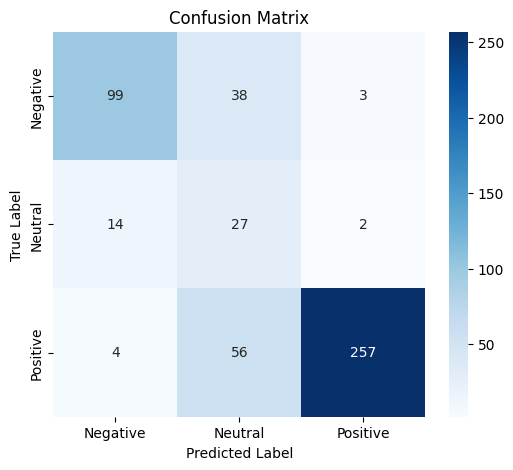


=== Runtime Performance Metrics ===
Total samples processed: 500
Total Inference Time: 1264.54 sec
Average Latency per Review: 1.5334 sec
Throughput: 0.40 reviews/sec
Memory Usage (RSS): 2477.88 MB


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

new_test_df = pd.read_csv("/content/drive/MyDrive/shin_colab/2_epochs_processed_ft.csv")

# Select the first 500 rows
new_test_df_copy = new_test_df.iloc[:500].copy()  # Use .copy() to avoid SettingWithCopyWarning
new_test_df_copy['Predict_sentiment'] = new_test_df_copy['Predict_sentiment'].apply(str.strip)


y_pred = list(new_test_df_copy['Predict_sentiment'])

y_true = list(new_test_df_copy['Sentiment'])


# Compute classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n=== Model Performance Metrics ===")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Macro): {precision:.2f}")
print(f"Recall (Macro): {recall:.2f}")
print(f"F1-Score (Macro): {f1:.2f}")
print(classification_report(y_true, y_pred))

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print performance results
print("\n=== Runtime Performance Metrics ===")
print(f"Total samples processed: {total_samples}")
print(f"Total Inference Time: {total_time:.2f} sec")
print(f"Average Latency per Review: {avg_latency:.4f} sec")
print(f"Throughput: {throughput:.2f} reviews/sec")
print(f"Memory Usage (RSS): {memory_usage:.2f} MB")

In [ ]:
model.save_pretrained("/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs")
tokenizer.save_pretrained("/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs")

('/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs/tokenizer_config.json',
 '/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs/special_tokens_map.json',
 '/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs/tokenizer.model',
 '/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs/added_tokens.json',
 '/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs/tokenizer.json')

In [ ]:
# Test load lora model

max_seq_length = 2048

from unsloth import FastLanguageModel
train_model, train_tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/content/drive/MyDrive/shin_colab/mistral_lora_model_2epochs", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(train_model) # Enable native 2x faster inference


from transformers import TextStreamer
text_streamer = TextStreamer(train_tokenizer)


==((====))==  Unsloth 2025.5.4: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   9%|8         | 409M/4.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

Unsloth 2025.5.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
import re
def inference_model(input_text, model, tokenizer):
  prompt = input_prompt(input_text)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  encodeds = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
  model_inputs = encodeds.to(device)

  generated_ids = model.generate(**model_inputs, max_new_tokens=200, do_sample=False, temperature=0.5)

  decoded = tokenizer.batch_decode(generated_ids,skip_special_tokens=True)
  # print(decoded[0])

  # Get the output only instead of whole prompt
  match = re.search(r'\*\*Sentiment:\*\*\s*(\w+)', decoded[0][len(prompt)-40:])
  return match.group(1) if match else None
  # print("Test", decoded[0][len(prompt)-40:])
  # output_text = decoded[0][len(prompt)-40:].strip().split("\n")[-1]
  # return output_text.strip()

In [ ]:
input_text = 'My son has Crohn&#039;s disease and has done very well on the Asacol. He has no complaints and shows no side effects. He has taken as many as nine tablets per day at one time. I&#039;ve been very happy with the results, reducing his bouts of diarrhea drastically.'
predict_sentiment_2 = inference_model(input_text = input_text, model = train_model, tokenizer=train_tokenizer)
print(predict_sentiment_2)


You are an expert in analyzing sentiment from drug reviews. Your task is to classify a given drug review as **Positive, Negative, or Neutral** based on the user's experience.

### **Criteria for Sentiment Classification:**
- **Positive**: The review expresses satisfaction with the drug, mentioning effectiveness, relief from symptoms, or minimal side effects.
- **Negative**: The review expresses dissatisfaction, describing strong side effects, lack of effectiveness, or worsening of the condition.
- **Neutral**: The review is mixed or inconclusive, mentioning both pros and cons without strong emotions, or if the experience is unclear.

### **Only return one of the following labels: Positive, Negative, or Neutral. Do not provide explanations.

### **Examples:**

#### **Example 1:**
**Review:** "This medication completely stopped my migraines within a week. I haven't had a single headache since!"
**Sentiment:** Positive

#### **Example 2:**
**Review:** "I had high hopes, but this drug did

In [ ]:
input_text = "Ive been on Methadone for over ten years and currently,I am trying to get off of this drug. Ive been decreasing my does 2 mgs per month for over a year. I am at 3 mgs and really starting to feel the withdraw.I don&#039;t plan to get my next 30 doses.because its almost rediculous how little it does for me. I have 3 does doses of 3 mg and Im terrified. Can anyone give me some truthful encouragement?....."
predict_sentiment_2 = inference_model(input_text = input_text, model = train_model, tokenizer=train_tokenizer)
print(predict_sentiment_2)


You are an expert in analyzing sentiment from drug reviews. Your task is to classify a given drug review as **Positive, Negative, or Neutral** based on the user's experience.

### **Criteria for Sentiment Classification:**
- **Positive**: The review expresses satisfaction with the drug, mentioning effectiveness, relief from symptoms, or minimal side effects.
- **Negative**: The review expresses dissatisfaction, describing strong side effects, lack of effectiveness, or worsening of the condition.
- **Neutral**: The review is mixed or inconclusive, mentioning both pros and cons without strong emotions, or if the experience is unclear.

### **Only return one of the following labels: Positive, Negative, or Neutral. Do not provide explanations.

### **Examples:**

#### **Example 1:**
**Review:** "This medication completely stopped my migraines within a week. I haven't had a single headache since!"
**Sentiment:** Positive

#### **Example 2:**
**Review:** "I had high hopes, but this drug did

In [ ]:
input_text = "I was on this pill for almost two years. It does work as far as not getting pregnant however my experience at first was it didn&#039;t make a huge difference then 6 or 7 months into it my sex drive went down, along with being very very dry, my moodiness increased drastically. I would cry one second and then get angry with my husband over anything and everything. My skin has gotten a lot worse, I broke out in places I never had in the last week. So now I am on Yaz"
predict_sentiment_2 = inference_model(input_text = input_text, model = train_model, tokenizer=train_tokenizer)
print(predict_sentiment_2)


You are an expert in analyzing sentiment from drug reviews. Your task is to classify a given drug review as **Positive, Negative, or Neutral** based on the user's experience.

### **Criteria for Sentiment Classification:**
- **Positive**: The review expresses satisfaction with the drug, mentioning effectiveness, relief from symptoms, or minimal side effects.
- **Negative**: The review expresses dissatisfaction, describing strong side effects, lack of effectiveness, or worsening of the condition.
- **Neutral**: The review is mixed or inconclusive, mentioning both pros and cons without strong emotions, or if the experience is unclear.

### **Only return one of the following labels: Positive, Negative, or Neutral. Do not provide explanations.

### **Examples:**

#### **Example 1:**
**Review:** "This medication completely stopped my migraines within a week. I haven't had a single headache since!"
**Sentiment:** Positive

#### **Example 2:**
**Review:** "I had high hopes, but this drug did